In [2]:
# region General Imports
import os
import re
import uuid
import shutil
import time
import random
import datetime
import glob
import pickle
import tqdm
import copy
import optuna
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from rich import print as rprint
from rich.pretty import pprint as rpprint
from tqdm import tqdm
from itertools import chain
from functools import partial
# endregion General Imports

import tempfile
import tensorflow as tf
import numpy as np
from tensorflow import keras

import tensorflow_model_optimization as tfmot
%load_ext tensorboard
    
# os.environ["KERAS_BACKEND"] = "tf"
# os.environ["TF_USE_LEGACY_KERAS"] = "0"
# import jax
# import jax.numpy as jnp
# import keras
    
# region Keras
from keras.models import Model
from keras.layers import Dense, Activation, Permute, Dropout
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Conv1D,
    MaxPooling1D,
    AveragePooling1D,
)
from keras.layers import SeparableConv2D, DepthwiseConv2D
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout2D
from keras.regularizers import l1_l2
from keras.layers import Input, Flatten
from keras.constraints import max_norm
from keras import backend as K
# endregion Keras

from custom_datasets.fatigue_mi import FatigueMI

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from sklearn import preprocessing

from model_optim.utils import channels_to_channels_idx

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
SKLRNG = 42
# RNG = jax.random.PRNGKey(SKLRNG)

In [4]:
# region Helper funcs
def shallow_conv_net_square_layer(x):
    return tf.math.square(x)

def shallow_conv_net_log_layer(x):
    return tf.math.log(tf.clip_by_value(x, 1e-7, 10000))

CUSTOM_OBJECTS = {
    "shallow_conv_net_square_layer": shallow_conv_net_square_layer, 
    "shallow_conv_net_log_layer": shallow_conv_net_log_layer 
}
# endregion Helper funcs


In [5]:
best_models_df = pd.read_csv("./final/best_models.csv").drop(columns=["Unnamed: 0"])

best_models_df.head(5)

trial_number  train_acc  test_acc   val_acc  train_val_acc_diff  \
0             1   0.779412  0.681818  0.777778            0.001634   
1             3   0.970588  0.681818  0.722222            0.248366   
2             0   0.941176  0.727273  0.666667            0.274510   
3            23   0.852941  0.727273  0.888889            0.035948   
4            15   0.955882  0.818182  0.833333            0.122549   

   train_loss  val_loss  train_val_loss_diff  test_loss    scores  \
0    0.451416  0.575806             0.124390   0.658583  0.299783   
1    0.755424  1.030562             0.275138   1.222213  0.077861   
2    0.501189  0.778463             0.277274   0.757358  0.853020   
3    0.388678  0.429204             0.040526   0.646307  0.262646   
4    0.432221  0.737542             0.305321   0.739283  0.028128   

                                   channels_selected  sfreq  batch_size  \
0          ['P3' 'Fz' 'P4' 'Cz' 'T3' 'T5' 'O2' 'T6']  256.0        32.0   
1  ['P3' 'C3' 'F3' 'Fz' 'P4' 'Cz' 'T3' 'T5' 'O1' ...  256.0       256.0   
2          ['P3' 'C3' 'Fz' 'F4' 'C4' 'P4' 'F7' 'F8']    NaN         NaN   
3                   ['C3' 'F3' 'C4' 'Cz' 'Fp2' 'T6']  128.0       128.0   
4              ['P3' 'C3' 'F3' 'C4' 'Cz' 'Pz' 'Fp2']  128.0        32.0   

         model_name  subjects  \
0     deep_conv_net        11   
1           eeg_net        11   
2  shallow_conv_net        11   
3     deep_conv_net        12   
4           eeg_net        12   

                                           file_path  
0  ./temp/FatigueMI/[11]/2e54fc7d125447c096b49ecb...  
1  ./temp/FatigueMI/[11]/6772e2405e6e436faba83820...  
2  ./temp/FatigueMI/[11]/e0643f9a780146a4adc15ddd...  
3  ./temp/FatigueMI/[12]/259f8d3cf7ce4e5283e8e407...  
4  ./temp/FatigueMI/[12]/fa0faed8a6ce4a52a2b9ca5d...

In [6]:
subject_best_file_paths = best_models_df[['file_path']].to_numpy().flatten().tolist()
subject_best_trial_numbers = best_models_df[['trial_number']].to_numpy().flatten().tolist()
subject_best_trials = list(zip(subject_best_file_paths, subject_best_trial_numbers))
rpprint(subject_best_trials)

[
│   ('./temp/FatigueMI/[11]/2e54fc7d125447c096b49ecb93fd4f9a/model/deep_conv_net_study.npy', 1),
│   ('./temp/FatigueMI/[11]/6772e2405e6e436faba8382021d362e4/model/eeg_net_study.npy', 3),
│   ('./temp/FatigueMI/[11]/e0643f9a780146a4adc15ddd4a9ff053/model/shallow_conv_net_study_best_trial.npy', 0),
│   ('./temp/FatigueMI/[12]/259f8d3cf7ce4e5283e8e4071f15f07a/model/deep_conv_net_study.npy', 23),
│   ('./temp/FatigueMI/[12]/fa0faed8a6ce4a52a2b9ca5d120893ed/model/eeg_net_study.npy', 15),
│   ('./temp/FatigueMI/[12]/96dc576945fb4f2db582d66ae1d2c8ce/model/shallow_conv_net_study_best_trial.npy', 0),
│   ('./temp/FatigueMI/[4]/52166a0614d541acb9b9ef965eed5de2/model/deep_conv_net_study.npy', 19),
│   ('./temp/FatigueMI/[4]/72578c4a27b64a8e989fd90727f209ad/model/eeg_net_study.npy', 11),
│   ('./temp/FatigueMI/[4]/3623cb4ba1ad4a908c9098f5297a6778/model/shallow_conv_net_study_best_trial.npy', 0),
│   ('./temp/FatigueMI/[6]/0614f3b1603b4442a2cc79ade04a6a0d/model/deep_conv_net_study.npy', 2),
│   ('./temp/FatigueMI/[6]/969f098d0f9344e5baa14cc429e2471b/model/eeg_net_study.npy', 10),
│   ('./temp/FatigueMI/[6]/7ec6d62fc9a84597a65261efcb6e808a/model/shallow_conv_net_study.npy', 5),
│   ('./temp/FatigueMI/[9]/0113b240ca004b67b81ca0fd5df6dd6e/model/deep_conv_net_study.npy', 13),
│   ('./temp/FatigueMI/[9]/fd4945e8633f4c0ab473e7520efcfee6/model/eeg_net_study.npy', 19),
│   ('./temp/FatigueMI/[9]/63a8c87ffc02471893db5ac9a0781946/model/shallow_conv_net_study_best_trial.npy', 0)
]

In [51]:
#subject_best_trials = glob.glob('./temp_v2/**/model/shallow_conv_net_study_best_trial.npy', recursive=True)
#subject_best_trials = sorted(subject_best_trials, key=lambda x: os.path.getmtime(x))
#subject_best_trials = sorted(subject_best_trials, key=lambda x: int(re.compile(r"\[.*\]").search(x).group(0).strip("[]")))

In [7]:
def data_generator(dataset, subjects = [], channel_idx = [], filters = ([8, 32],), sfreq = 250):

    find_events = lambda raw, event_id: mne.find_events(raw, shortest_event=0, verbose=False) if len(mne.utils._get_stim_channel(None, raw.info, raise_error=False)) > 0 else mne.events_from_annotations(raw, event_id=event_id, verbose=False)[0]
    
    data = dataset.get_data(subjects=subjects)
    
    X = []
    y = []
    metadata = []

    for subject_id in data.keys():
        for session_id in data[subject_id].keys():
            for run_id in data[subject_id][session_id].keys():
                raw = data[subject_id][session_id][run_id]
                
                for fmin, fmax in filters:
                    raw = raw.filter(l_freq = fmin, h_freq = fmax, method = 'iir', picks = 'eeg', verbose = False)
                
                events = find_events(raw, dataset.event_id)

                tmin = dataset.interval[0]
                tmax = dataset.interval[1]

                channels = np.asarray(raw.info['ch_names'])[channel_idx] if len(channel_idx) > 0 else np.asarray(raw.info['ch_names'])

                # rpprint(channels)
                
                stim_channels = mne.utils._get_stim_channel(None, raw.info, raise_error=False)
                picks = mne.pick_channels(raw.info["ch_names"], include=channels, exclude=stim_channels, ordered=True)

                x = mne.Epochs(
                    raw,
                    events,
                    event_id=dataset.event_id,
                    tmin=tmin,
                    tmax=tmax,
                    proj=False,
                    baseline=None,
                    preload=True,
                    verbose=False,
                    picks=picks,
                    event_repeated="drop",
                    on_missing="ignore",
                )
                x_events = x.events
                inv_events = {k: v for v, k in dataset.event_id.items()}
                labels = [inv_events[e] for e in x_events[:, -1]]

                # rpprint({
                #     "X": np.asarray(x.get_data(copy=False)).shape,
                #     "y": np.asarray(labels).shape,
                #     "channels selected": np.asarray(raw.info['ch_names'])[channel_idx]
                # })

                # x.plot(scalings="auto")
                # display(x.info)
                
                x_resampled = x.resample(sfreq) # Resampler_Epoch
                x_resampled_data = x_resampled.get_data(copy=False) # Convert_Epoch_Array
                x_resampled_data_standard_scaler = np.asarray([
                    StandardScaler().fit_transform(x_resampled_data[i])
                    for i in np.arange(x_resampled_data.shape[0])
                ]) # Standard_Scaler_Epoch

                # x_resampled.plot(scalings="auto")
                # display(x_resampled.info)

                n = x_resampled_data_standard_scaler.shape[0]
                # n = x.get_data(copy=False).shape[0]
                met = pd.DataFrame(index=range(n))
                met["subject"] = subject_id
                met["session"] = session_id
                met["run"] = run_id
                x.metadata = met.copy()
                
                # X.append(x_resampled_data_standard_scaler)
                X.append(x)
                y.append(labels)
                metadata.append(met)

    return np.concatenate(X, axis=0), np.concatenate(y), pd.concat(metadata, ignore_index=True)

fat_dataset = FatigueMI()

In [8]:
def load_best_trial_from_study(study_idx, subject_best_trials):
    study_path = subject_best_trials[study_idx][0]
    study = np.load(study_path, allow_pickle=True).item()
    trial = study.trials[subject_best_trials[study_idx][1]] if hasattr(study, "trials") else study

    model_info = {
        "subject": trial.user_attrs["trial_data"]["subject"] if hasattr(trial.user_attrs["trial_data"], "subject") else int(re.compile(r"\[.*\]").search(study_path).group(0).strip("[]")),
        "sfreq": trial.params["sfreq"] if "sfreq" in trial.params and not trial.params["sfreq"] == None else trial.user_attrs['trial_data']['sfreq'] if "sfreq" in trial.user_attrs['trial_data'] else 128,
        "batch_size": trial.params["batch_size"] if "batch_size" in trial.params else 128,
        "channels_selected": trial.user_attrs["trial_data"]["channels_selected"],
        "channels_idx_selected": channels_to_channels_idx(trial.user_attrs["trial_data"]["channels_selected"], fat_dataset.get_data(subjects=[1])[1]['0']['0'].info['ch_names'][:-1]),
        "model": tf.keras.models.model_from_json(trial.user_attrs["trial_data"]["model"], custom_objects=CUSTOM_OBJECTS),
        "test_acc": trial.user_attrs["trial_data"]["test_accuracy"],
        "model_name": trial.user_attrs["trial_data"]['model_name'] if "model_name" in trial.user_attrs["trial_data"] else "shallow_conv_net",
    }
    if "weights" in trial.user_attrs["trial_data"]:
        model_info["model"].set_weights(trial.user_attrs["trial_data"]["weights"])
    elif "model_weights" in trial.user_attrs["trial_data"]:
        model_info["model"].set_weights(trial.user_attrs["trial_data"]["model_weights"])

    return model_info




# def load_best_trial(subject_best_trial):
#     model = np.load(subject_best_trials[0], allow_pickle=True).item()
#     model_info = {
#         "subject": model.user_attrs["trial_data"]["subject"] if hasattr(model.user_attrs["trial_data"], "subject") else int(re.compile(r"\[.*\]").search(model.user_attrs["trial_data"]["data_path"]).group(0).strip("[]")),
#         "sfreq": model.params["sfreq"] if "sfreq" in model.params else 128,
#         "batch_size": model.params["batch_size"] if "batch_size" in model.params else 128,
#         "channels_selected": model.user_attrs["trial_data"]["channels_selected"],
#         "channels_idx_selected": channels_to_channels_idx(model.user_attrs["trial_data"]["channels_selected"], fat_dataset.get_data(subjects=[1])[1]['0']['0'].info['ch_names'][:-1]),
#         "model": tf.keras.models.model_from_json(model.user_attrs["trial_data"]["model"], custom_objects=CUSTOM_OBJECTS),
#         "test_acc": model.user_attrs["trial_data"]["test_accuracy"],
#         "model_name": model.user_attrs["trial_data"]["model_name"] if hasattr(model.user_attrs["trial_data"], "model_name") else "shallow_conv_net"
#     }
#     if "weights" in model.user_attrs["trial_data"]:
#         model_info["model"].set_weights(model.user_attrs["trial_data"]["weights"])
#     elif "model_weights" in model.user_attrs["trial_data"]:
#         model_info["model"].set_weights(model.user_attrs["trial_data"]["model_weights"])
    
#     return model_info

def create_and_save_baseline_model(model_info, train_test_data, results_folder):

    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]

    model_info["model"].compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    baseline_model_test = model_info["model"].evaluate(X_test, y_test, batch_size=model_info["batch_size"])
    rpprint(baseline_model_test)

    baseline_test_acc = baseline_model_test[1]

    _, keras_file = None, results_folder + "baseline_model.h5"
    tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)
    return {
        "keras_file": keras_file,
        "baseline_test_acc": baseline_test_acc,
        "baseline_model": model_info["model"],
    }

def weight_prune_dense_layer(k_weights, b_weights, k_sparsity):
    # Copy the kernel weights and get ranked indeces of the abs
    kernel_weights = np.copy(k_weights)
    kernel_weight_idx_by_magnitude = np.argsort(np.abs(kernel_weights), axis=None) # rank the individual weights in weight matrix according to their magnitude (absolute value)

    kernel_weights_sparse_idx = kernel_weight_idx_by_magnitude[0:int(len(kernel_weight_idx_by_magnitude)*k_sparsity)]
    kernel_weights[np.unravel_index(kernel_weights_sparse_idx, kernel_weights.shape) if len(kernel_weights_sparse_idx) > 0 else kernel_weights_sparse_idx] = 0

    if b_weights is None:
        return kernel_weights, None
    
    bias_weights = np.copy(b_weights)
    bias_weights_idx_by_magnitude = np.argsort(np.abs(bias_weights), axis=None) # rank the individual weights in weight matrix according to their magnitude (absolute value)

    bias_weights_sparse_idx = bias_weights_idx_by_magnitude[0:int(len(bias_weights_idx_by_magnitude)*k_sparsity)]
    bias_weights[np.unravel_index(bias_weights_sparse_idx, bias_weights.shape)] = 0

    return kernel_weights, bias_weights

def prune_model(model_info, train_test_data, target_sparsity, results_folder):

    X_train, y_train = train_test_data["X_train"], train_test_data["y_train"]
    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]

    # prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # batch_size = model_info["batch_size"]
    # epochs = 2
    # end_step = np.ceil(len(X_train) / batch_size).astype(np.int32) * epochs
    # # Define model for pruning.
    # pruning_params = {
    #     # 'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=target_sparsity, begin_step=0, frequency=1),
    #     'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
    #                                                             final_sparsity=target_sparsity,
    #                                                             begin_step=0,
    #                                                             end_step=end_step,
    #                                                             frequency=1)
    # }
    # keras.utils.get_custom_objects().update({
    #     **CUSTOM_OBJECTS
    # })
    # baseline_model_copy = tf.keras.models.clone_model(model_info["model"])
    # model_for_pruning = prune_low_magnitude(baseline_model_copy, **pruning_params)
    # # `prune_low_magnitude` requires a recompile.
    # model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    keras.utils.get_custom_objects().update(CUSTOM_OBJECTS)
    sparse_model = tf.keras.models.clone_model(model_info["model"])
    sparse_model.set_weights(model_info["model"].get_weights())
    for layer in model_info["model"].layers:
        if "input" in layer.name or len(layer.trainable_weights) == 0:
            continue
        if "batch_normalization" in layer.name:
            continue
        W = layer.get_weights()[0]
        b = None
        if "batch_normalization" not in layer.name and layer.use_bias:
            b = layer.get_weights()[1]

        if "separable_conv2d" in layer.name:
            W = layer.get_weights()
            W_0, bias_weights = weight_prune_dense_layer(W[0], b, target_sparsity)
            W_1, _ = weight_prune_dense_layer(W[1], None, target_sparsity)
            kernel_weights = [W_0, W_1]
        else:
            kernel_weights, bias_weights = weight_prune_dense_layer(W, b, target_sparsity)
        # if pruning=='weight':
            # rprint(layer.name, W.shape)
        # elif pruning=='unit':
        #     kernel_weights, bias_weights = unit_prune_dense_layer(W, b, k_sparsity)

        # if "separable_conv2d" in layer.name:
        #     rprint(layer.get_weights()[0].shape, layer.get_weights()[1].shape, kernel_weights.shape)
        #     kernel_weights = kernel_weights[0]
        
        if "separable_conv2d" in layer.name:
            sparse_model.get_layer(layer.name).set_weights(kernel_weights)
        else:
            sparse_model.get_layer(layer.name).set_weights([kernel_weights, bias_weights] if b is not None else [kernel_weights])

    sparse_model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy'])
    model_for_pruning = sparse_model

    # logdir = "logs/pruning/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    # callbacks = [
    #     tfmot.sparsity.keras.UpdatePruningStep(),
    #     tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    # ]

    # model_for_pruning.fit(X_train, y_train, batch_size=model_info["batch_size"], epochs=epochs, validation_split=0.2, callbacks=callbacks)
    _, model_for_pruning_accuracy = model_for_pruning.evaluate(X_test, y_test, verbose=0)

    model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
    _, pruned_keras_file = None, results_folder + "pruned_model.h5"
    tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)

    return {
        "pruned_model": model_for_export,
        "pruned_model_test_acc": model_for_pruning_accuracy,
        "pruned_keras_file": pruned_keras_file
    }

def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    
    return os.path.getsize(zipped_file)

def convert_pruned_model_to_tflite(pruned_model, sparsity, results_folder):
    converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # converter.target_spec.supported_types = [quantization]
    pruned_tflite_model = converter.convert()

    _, pruned_tflite_file = None, results_folder + f"pruned_model_{sparsity}_sparsity.tflite"
    with open(pruned_tflite_file, 'wb') as f:
        f.write(pruned_tflite_model)
    
    return {
        "pruned_tflite_model": pruned_tflite_model,
        "pruned_tflite_file": pruned_tflite_file
    }

def convert_pruned_model_to_tflite_with_quantization(pruned_model, sparsity, quantization, results_folder):
    converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if quantization == 'float16':
        converter.target_spec.supported_types = [tf.float16]
    elif quantization == 'int8':
        pass
    else:
        raise ValueError(f"Quantization type {quantization} not implemented.")
    pruned_tflite_model = converter.convert()

    _, pruned_tflite_file = None, results_folder + f"pruned_model_{sparsity}_sparsity_{quantization}_quant.tflite"
    with open(pruned_tflite_file, 'wb') as f:
        f.write(pruned_tflite_model)
    
    return {
        "pruned_quant_tflite_model": pruned_tflite_model,
        "pruned_quant_tflite_file": pruned_tflite_file
    }

def get_test_acc_non_tf_lite(model, train_test_data):

    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]

    # Evaluate prediction accuracy of pruned model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=0)

    # Evaluate Inference Time of pruned model
    start_time = time.time()
    prediction = model.predict(X_test)
    exec_time = (time.time() - start_time)/X_test.shape[0]
    return {
        "test_accuracy": test_acc,
        "avg_exec_time": exec_time
    }

def get_test_acc(model, train_test_data):
    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]
    def evaluate_model(interpreter):
        input_index = interpreter.get_input_details()[0]["index"]
        output_index = interpreter.get_output_details()[0]["index"]

        # signatures = interpreter.get_signature_list()
        # rprint(interpreter.get_input_details(), interpreter.get_output_details(), signatures)

        # Run predictions on every image in the "test" dataset.
        predictions = []
        exec_times = []
        for i, v in enumerate(X_test):
            v = v[np.newaxis, :, :, np.newaxis].astype(np.float32)
            # if i % 1000 == 0:
            #   rprint('Evaluated on {n} results so far.'.format(n=i))
            # # Pre-processing: add batch dimension and convert to float32 to match with
            # # the model's input data format.
            # v = np.expand_dims(v, axis=0).astype(np.float32)
            interpreter.set_tensor(input_index, v)

            # Run inference.
            start_time = time.time()
            interpreter.invoke()
            exec_time = (time.time() - start_time)
            exec_times.append(exec_time)

            # Post-processing: remove batch dimension and find the digit with highest
            # probability.
            output = interpreter.tensor(output_index)
            class_prediction = np.argmax(output()[0]) # 0 = left, 1 = right
            predictions.append(class_prediction)

        print('\n')
        # Compare prediction results with ground truth labels to calculate accuracy.
        predictions = np.asarray(predictions)
        accuracy = (predictions == y_test).mean()
        avg_exec_time = np.mean(exec_times)
        return accuracy, avg_exec_time

    interpreter = tf.lite.Interpreter(model_content=model)
    interpreter.allocate_tensors()

    test_accuracy, avg_exec_time = evaluate_model(interpreter)

    return {
        "test_accuracy": test_accuracy,
        "avg_exec_time": avg_exec_time
    }

def get_model_weights_sparsity(model):
    sparsity_levels = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights

        for weight in weights:
            # if "kernel" not in weight.name or "centroid" in weight.name:
            #     continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            sparsity_levels.append((
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            ))
    return sparsity_levels

In [9]:
# Folder structure for results: ./results/{subject}/{model}/{sparsity}/{quantization}/

sparsity_levels = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
quantization_levels = [None, 'float16', 'int8']

results_data = {
    "subject": [],
    "model_name": [],
    "sparsity": [],
    "quantization": [],
    "test_acc": [],
    "model_size": [],
    "inf_time": [],
    "weights_sparsity": [],
}

#for study_idx in [2]:
for study_idx in range(len(subject_best_trials)):

    rprint("\n\n\nLoading best trial model...", subject_best_trials[study_idx][0], subject_best_trials[study_idx][1])

    model_info = load_best_trial_from_study(study_idx, subject_best_trials)
    subject = model_info["subject"]
    model_name = model_info["model_name"]

    rpprint(model_info)

    # Make model info folder if not exists
    os.makedirs(f"./results/{subject}/{model_name}/", exist_ok=True) if not os.path.exists(f"./results/{subject}/{model_name}/") else None
    np.save(f"./results/{subject}/{model_name}/model_info.npy", { k: v for k, v in model_info.items() if k != "model"}, allow_pickle=True)

    X, y, _ = data_generator(fat_dataset, subjects=[model_info["subject"]], channel_idx=model_info["channels_idx_selected"], sfreq=model_info["sfreq"])
    y_encoded = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=SKLRNG, shuffle=True, stratify=y_encoded)
    train_test_data = { "X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test }

    for sparsity in sparsity_levels:
        for quantization in quantization_levels:

            rprint(f"\n\n\nSubject: {subject}, Model: {model_name}, Sparsity: {sparsity}, Quantization: {quantization}\n\n")

            results_folder = f"./results/{subject}/{model_name}/{sparsity}/{quantization}/"
            os.makedirs(results_folder, exist_ok=True) if not os.path.exists(results_folder) else None # Make folder if doesn't exist

            # region 1) ------------- Build & save baseline model ------------- 
            rprint("Building & saving baseline model...")
            baseline_model_info = create_and_save_baseline_model(**{
                "model_info": model_info,
                "results_folder": results_folder,
                "train_test_data": train_test_data
            })
            keras_file, baseline_test_acc = baseline_model_info["keras_file"], baseline_model_info["baseline_test_acc"]
            rprint('Saved baseline model to:', keras_file)
            # endregion

            # region 2) ------------- Pruning the baseline model -------------
            rprint("Pruning the baseline model...")
            pruned_model_info = prune_model(**{
                "target_sparsity": sparsity,
                "model_info": model_info,
                "train_test_data": train_test_data,
                "results_folder": results_folder
            })
            
            pruned_model = pruned_model_info["pruned_model"]
            pruned_model_test_acc, pruned_keras_file = pruned_model_info["pruned_model_test_acc"], pruned_model_info["pruned_keras_file"]
            pruned_model_weights_sparsity = get_model_weights_sparsity(pruned_model)
            model_weights_sparsity = pruned_model_weights_sparsity

            rprint(f'Saved pruned Keras model with {sparsity*100}% sparsity to:', pruned_keras_file)
            rpprint({
                'Baseline test accuracy': baseline_test_acc,
                'Pruned test accuracy': pruned_model_test_acc
            })
            # endregion

            # region 3) ------------- Converting pruned model to TFLite -------------        
            if quantization != None:
                tflite_model_info = convert_pruned_model_to_tflite(**{
                    "pruned_model": pruned_model,
                    "sparsity": sparsity,
                    "results_folder": results_folder
                })
                pruned_tflite_model, pruned_tflite_file = tflite_model_info["pruned_tflite_model"], tflite_model_info["pruned_tflite_file"]
                
                rprint('Saved pruned TFLite model to:', pruned_tflite_file)
                rprint("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
                rprint("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
                rprint("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))
            else:
                pruned_tflite_model, pruned_tflite_file = None, None
            # endregion

            # region 4) ------------- Quantizing pruned TFLite model ------------- 
            if quantization != None:
                tflite_quant_model_info = convert_pruned_model_to_tflite_with_quantization(**{
                    "pruned_model": pruned_model,
                    "sparsity": sparsity,
                    "quantization": quantization,
                    "results_folder": results_folder
                })
                quantized_and_pruned_tflite_model = tflite_quant_model_info["pruned_quant_tflite_model"]
                quantized_and_pruned_tflite_file = tflite_quant_model_info["pruned_quant_tflite_file"]

                rprint('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)
                rprint("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
                rprint("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))
            else:
                quantized_and_pruned_tflite_model, quantized_and_pruned_tflite_file = None, None
            
            # endregion

            # region 5) ------------- Evaluation check -------------
            if quantization != None:
                tflite_quant_model_test_acc_results = get_test_acc(**{
                    "model": quantized_and_pruned_tflite_model, 
                    "train_test_data": train_test_data
                })
                tflite_quant_model_test_acc = tflite_quant_model_test_acc_results["test_accuracy"]

                rprint('Pruned and quantized TFLite test_accuracy:', tflite_quant_model_test_acc)
                rprint('Pruned TF test accuracy:', pruned_model_test_acc)
            # endregion
            
            # region 6) ------------- Saving results -------------
            if quantization != None:
                model_objs = [{ "model": quantized_and_pruned_tflite_model, "file": quantized_and_pruned_tflite_file, "tf_lite": True, "weights_sparsity": model_weights_sparsity }]
            else:
                model_objs = [{ "model": pruned_model, "file": pruned_keras_file, "tf_lite": False, "weights_sparsity": model_weights_sparsity }]
                
            for model_obj in model_objs:
                model_to_evaluate = model_obj["model"]
                model_file_to_evaluate = model_obj["file"]
                model_is_tf_lite = model_obj["tf_lite"]
                model_weights_sparsity = model_obj["weights_sparsity"]

                if model_to_evaluate == None or model_file_to_evaluate == None:
                    continue

                # 1) Test accuracy & inference time
                if model_is_tf_lite:
                    eval_res = get_test_acc(**{
                        "model": model_to_evaluate, 
                        "train_test_data": train_test_data
                    })
                else:
                    eval_res = get_test_acc_non_tf_lite(**{
                        "model": model_to_evaluate, 
                        "train_test_data": train_test_data
                    })
                test_acc = eval_res["test_accuracy"]
                inf_time = eval_res["avg_exec_time"]
                # 2) Model size
                model_size = get_gzipped_model_size(model_file_to_evaluate)

                results_data["subject"].append(subject)
                results_data["model_name"].append(model_name)
                results_data["sparsity"].append(sparsity)
                results_data["quantization"].append(quantization)
                
                results_data["test_acc"].append(test_acc)
                results_data["model_size"].append(model_size)
                results_data["inf_time"].append(inf_time)

                results_data["weights_sparsity"].append(model_weights_sparsity)
            # endregion
    

Loading best trial model... ./temp/FatigueMI/[11]/2e54fc7d125447c096b49ecb93fd4f9a/model/deep_conv_net_study.npy 1

2024-05-03 09:56:09.180345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 09:56:09.180749: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


{
│   'subject': 11,
│   'sfreq': 256,
│   'batch_size': 32,
│   'channels_selected': array(['P3', 'Fz', 'P4', 'Cz', 'T3', 'T5', 'O2', 'T6'], dtype='<U3'),
│   'channels_idx_selected': [0, 3, 6, 7, 11, 12, 14, 18],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f33a1d30850>,
│   'test_acc': 0.6818181872367859,
│   'model_name': 'deep_conv_net'
}

Adding metadata with 3 columns


Subject: 11, Model: deep_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 10s 10s/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/11/deep_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 432ms/step


Subject: 11, Model: deep_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 866ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

Saved baseline model to: ./results/11/deep_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/11/deep_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpbpg6vo5p/assets


INFO:tensorflow:Assets written to: /tmp/tmpbpg6vo5p/assets
2024-05-03 09:56:27.301514: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:56:27.301576: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:56:27.302354: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbpg6vo5p
2024-05-03 09:56:27.305369: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:56:27.305397: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpbpg6vo5p
2024-05-03 09:56:27.313045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-03 09:56:27.314464: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:56:27.366275: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

Saved pruned TFLite model to: ./results/11/deep_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 558932.00 bytes

Size of gzipped pruned Keras model: 558928.00 bytes

Size of gzipped pruned TFlite model: 549773.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp8pq_l5v_/assets


INFO:tensorflow:Assets written to: /tmp/tmp8pq_l5v_/assets
2024-05-03 09:56:29.351082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:56:29.351140: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:56:29.351300: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8pq_l5v_
2024-05-03 09:56:29.353856: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:56:29.353879: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8pq_l5v_
2024-05-03 09:56:29.359942: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:56:29.397671: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8pq_l5v_
2024-05-03 09:56:29.412043: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 558932.00 bytes

Size of gzipped pruned and quantized TFlite model: 272537.00 bytes

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: deep_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 866ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/11/deep_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmphf_d_rbd/assets


INFO:tensorflow:Assets written to: /tmp/tmphf_d_rbd/assets
2024-05-03 09:56:33.782522: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:56:33.782594: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:56:33.782751: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphf_d_rbd
2024-05-03 09:56:33.784607: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:56:33.784629: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphf_d_rbd
2024-05-03 09:56:33.788859: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:56:33.828526: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphf_d_rbd
2024-05-03 09:56:33.844570: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 558926.00 bytes

Size of gzipped pruned Keras model: 558922.00 bytes

Size of gzipped pruned TFlite model: 549767.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpy1ciwrae/assets


INFO:tensorflow:Assets written to: /tmp/tmpy1ciwrae/assets
2024-05-03 09:56:35.734142: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:56:35.734206: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:56:35.734356: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpy1ciwrae
2024-05-03 09:56:35.735907: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:56:35.735940: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpy1ciwrae
2024-05-03 09:56:35.739773: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:56:35.779960: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpy1ciwrae
2024-05-03 09:56:35.795974: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 558926.00 bytes

Size of gzipped pruned and quantized TFlite model: 151485.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: deep_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 917ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/11/deep_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 362ms/step


Subject: 11, Model: deep_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 863ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

Saved baseline model to: ./results/11/deep_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/11/deep_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpn1986mci/assets


INFO:tensorflow:Assets written to: /tmp/tmpn1986mci/assets
2024-05-03 09:56:43.318823: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:56:43.318893: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:56:43.319098: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn1986mci
2024-05-03 09:56:43.320714: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:56:43.320753: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpn1986mci
2024-05-03 09:56:43.325164: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:56:43.363053: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpn1986mci
2024-05-03 09:56:43.377291: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned Keras model: 520823.00 bytes

Size of gzipped pruned TFlite model: 512072.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmponh9gpzd/assets


INFO:tensorflow:Assets written to: /tmp/tmponh9gpzd/assets
2024-05-03 09:56:45.204467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:56:45.204535: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:56:45.204694: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmponh9gpzd
2024-05-03 09:56:45.206169: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:56:45.206185: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmponh9gpzd
2024-05-03 09:56:45.210490: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:56:45.246815: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmponh9gpzd
2024-05-03 09:56:45.259343: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned and quantized TFlite model: 259821.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: deep_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 839ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/11/deep_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpl9ixw1lt/assets


INFO:tensorflow:Assets written to: /tmp/tmpl9ixw1lt/assets
2024-05-03 09:56:49.545502: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:56:49.545568: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:56:49.545737: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpl9ixw1lt
2024-05-03 09:56:49.547439: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:56:49.547473: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpl9ixw1lt
2024-05-03 09:56:49.551839: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:56:49.592955: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpl9ixw1lt
2024-05-03 09:56:49.608165: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned Keras model: 520817.00 bytes

Size of gzipped pruned TFlite model: 512066.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp6xz1ufs1/assets


INFO:tensorflow:Assets written to: /tmp/tmp6xz1ufs1/assets
2024-05-03 09:56:51.573862: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:56:51.573930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:56:51.574089: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6xz1ufs1
2024-05-03 09:56:51.575655: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:56:51.575674: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6xz1ufs1
2024-05-03 09:56:51.581661: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:56:51.619253: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6xz1ufs1
2024-05-03 09:56:51.634533: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned and quantized TFlite model: 144510.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: deep_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 891ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/11/deep_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5909090638160706}

1/1 [==============================] - 0s 394ms/step


Subject: 11, Model: deep_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 928ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

Saved baseline model to: ./results/11/deep_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/11/deep_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmpfp45ug9o/assets


INFO:tensorflow:Assets written to: /tmp/tmpfp45ug9o/assets
2024-05-03 09:56:59.758024: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:56:59.758143: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:56:59.758333: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfp45ug9o
2024-05-03 09:56:59.760179: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:56:59.760227: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfp45ug9o
2024-05-03 09:56:59.767790: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:56:59.810124: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpfp45ug9o
2024-05-03 09:56:59.827348: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned Keras model: 428410.00 bytes

Size of gzipped pruned TFlite model: 420259.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpaydvi1lh/assets


INFO:tensorflow:Assets written to: /tmp/tmpaydvi1lh/assets
2024-05-03 09:57:01.921442: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:01.921543: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:01.921850: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpaydvi1lh
2024-05-03 09:57:01.924546: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:01.924579: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpaydvi1lh
2024-05-03 09:57:01.929919: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:01.972354: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpaydvi1lh
2024-05-03 09:57:01.986722: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned and quantized TFlite model: 218444.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Subject: 11, Model: deep_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 956ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/11/deep_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmpsszmp37l/assets


INFO:tensorflow:Assets written to: /tmp/tmpsszmp37l/assets
2024-05-03 09:57:06.465462: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:06.465526: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:06.465688: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsszmp37l
2024-05-03 09:57:06.467272: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:06.467291: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsszmp37l
2024-05-03 09:57:06.471822: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:06.510319: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsszmp37l
2024-05-03 09:57:06.524616: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned Keras model: 428404.00 bytes

Size of gzipped pruned TFlite model: 420253.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpe1q9p85_/assets


INFO:tensorflow:Assets written to: /tmp/tmpe1q9p85_/assets
2024-05-03 09:57:08.326078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:08.326152: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:08.326319: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpe1q9p85_
2024-05-03 09:57:08.327897: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:08.327923: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpe1q9p85_
2024-05-03 09:57:08.332026: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:08.373131: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpe1q9p85_
2024-05-03 09:57:08.386533: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned and quantized TFlite model: 127604.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Subject: 11, Model: deep_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 848ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/11/deep_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5454545617103577}

1/1 [==============================] - 0s 352ms/step


Subject: 11, Model: deep_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 844ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

Saved baseline model to: ./results/11/deep_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/11/deep_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmp39hs10nz/assets


INFO:tensorflow:Assets written to: /tmp/tmp39hs10nz/assets
2024-05-03 09:57:16.110161: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:16.110228: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:16.110392: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp39hs10nz
2024-05-03 09:57:16.112105: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:16.112124: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp39hs10nz
2024-05-03 09:57:16.116947: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:16.160401: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp39hs10nz
2024-05-03 09:57:16.176844: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned Keras model: 322376.00 bytes

Size of gzipped pruned TFlite model: 315338.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp3bdxqtvy/assets


INFO:tensorflow:Assets written to: /tmp/tmp3bdxqtvy/assets
2024-05-03 09:57:18.276129: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:18.276201: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:18.276360: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3bdxqtvy
2024-05-03 09:57:18.277969: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:18.277992: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3bdxqtvy
2024-05-03 09:57:18.282089: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:18.321027: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3bdxqtvy
2024-05-03 09:57:18.338870: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned and quantized TFlite model: 169890.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 11, Model: deep_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 974ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/11/deep_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmp8aomo_pz/assets


INFO:tensorflow:Assets written to: /tmp/tmp8aomo_pz/assets
2024-05-03 09:57:23.088019: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:23.088089: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:23.088250: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8aomo_pz
2024-05-03 09:57:23.089938: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:23.089954: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8aomo_pz
2024-05-03 09:57:23.094445: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:23.134002: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8aomo_pz
2024-05-03 09:57:23.148198: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned Keras model: 322370.00 bytes

Size of gzipped pruned TFlite model: 315332.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp8e1xqcnu/assets


INFO:tensorflow:Assets written to: /tmp/tmp8e1xqcnu/assets
2024-05-03 09:57:25.131641: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:25.131706: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:25.131858: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8e1xqcnu
2024-05-03 09:57:25.133367: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:25.133383: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8e1xqcnu
2024-05-03 09:57:25.137667: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:25.175069: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8e1xqcnu
2024-05-03 09:57:25.190435: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned and quantized TFlite model: 104031.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 11, Model: deep_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 928ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/11/deep_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 379ms/step


Subject: 11, Model: deep_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 880ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

Saved baseline model to: ./results/11/deep_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/11/deep_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp_4wirkmr/assets


INFO:tensorflow:Assets written to: /tmp/tmp_4wirkmr/assets
2024-05-03 09:57:33.449514: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:33.449597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:33.449757: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_4wirkmr
2024-05-03 09:57:33.451549: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:33.451579: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_4wirkmr
2024-05-03 09:57:33.456040: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:33.497459: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_4wirkmr
2024-05-03 09:57:33.513641: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned Keras model: 211936.00 bytes

Size of gzipped pruned TFlite model: 204626.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpkvd81eaz/assets


INFO:tensorflow:Assets written to: /tmp/tmpkvd81eaz/assets
2024-05-03 09:57:35.620304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:35.620377: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:35.620546: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkvd81eaz
2024-05-03 09:57:35.622190: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:35.622208: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkvd81eaz
2024-05-03 09:57:35.626426: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:35.667880: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkvd81eaz
2024-05-03 09:57:35.682217: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned and quantized TFlite model: 114920.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 11, Model: deep_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/11/deep_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpjrxj_507/assets


INFO:tensorflow:Assets written to: /tmp/tmpjrxj_507/assets
2024-05-03 09:57:40.394252: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:40.394329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:40.394512: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjrxj_507
2024-05-03 09:57:40.396352: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:40.396372: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpjrxj_507
2024-05-03 09:57:40.401167: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:40.442406: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpjrxj_507
2024-05-03 09:57:40.459043: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned Keras model: 211930.00 bytes

Size of gzipped pruned TFlite model: 204620.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpeacv3xh5/assets


INFO:tensorflow:Assets written to: /tmp/tmpeacv3xh5/assets
2024-05-03 09:57:42.485994: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:42.486063: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:42.486236: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpeacv3xh5
2024-05-03 09:57:42.488069: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:42.488122: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpeacv3xh5
2024-05-03 09:57:42.493996: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:42.534588: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpeacv3xh5
2024-05-03 09:57:42.550804: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned and quantized TFlite model: 73448.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 11, Model: deep_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 976ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/11/deep_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 377ms/step


Subject: 11, Model: deep_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 885ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

Saved baseline model to: ./results/11/deep_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/11/deep_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp31emdf2g/assets


INFO:tensorflow:Assets written to: /tmp/tmp31emdf2g/assets
2024-05-03 09:57:50.826812: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:50.826879: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:50.827080: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp31emdf2g
2024-05-03 09:57:50.828884: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:50.828913: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp31emdf2g
2024-05-03 09:57:50.833877: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:50.873935: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp31emdf2g
2024-05-03 09:57:50.889355: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned Keras model: 86540.00 bytes

Size of gzipped pruned TFlite model: 79799.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpdibs2mmt/assets


INFO:tensorflow:Assets written to: /tmp/tmpdibs2mmt/assets
2024-05-03 09:57:52.993311: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:52.993374: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:52.993531: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdibs2mmt
2024-05-03 09:57:52.995365: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:52.995387: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpdibs2mmt
2024-05-03 09:57:52.999872: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:53.043275: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpdibs2mmt
2024-05-03 09:57:53.062262: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 558936.00 bytes

Size of gzipped pruned and quantized TFlite model: 48884.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 11, Model: deep_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 981ms/step - loss: 0.6586 - accuracy: 0.6818


[0.6585825085639954, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/deep_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/11/deep_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmprok2yh2k/assets


INFO:tensorflow:Assets written to: /tmp/tmprok2yh2k/assets
2024-05-03 09:57:57.725708: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:57.725768: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:57.725918: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprok2yh2k
2024-05-03 09:57:57.727982: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:57.728014: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmprok2yh2k
2024-05-03 09:57:57.734626: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:57.774929: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmprok2yh2k
2024-05-03 09:57:57.790667: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned Keras model: 86534.00 bytes

Size of gzipped pruned TFlite model: 79793.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpva4ye228/assets


INFO:tensorflow:Assets written to: /tmp/tmpva4ye228/assets
2024-05-03 09:57:59.775506: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:57:59.775570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:57:59.775728: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpva4ye228
2024-05-03 09:57:59.777335: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:57:59.777362: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpva4ye228
2024-05-03 09:57:59.781408: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:57:59.819574: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpva4ye228
2024-05-03 09:57:59.833442: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 558930.00 bytes

Size of gzipped pruned and quantized TFlite model: 34894.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... ./temp/FatigueMI/[11]/6772e2405e6e436faba8382021d362e4/model/eeg_net_study.npy 3

{
│   'subject': 11,
│   'sfreq': 256,
│   'batch_size': 256,
│   'channels_selected': array(['P3', 'C3', 'F3', 'Fz', 'P4', 'Cz', 'T3', 'T5', 'O1', 'F7', 'F8',
│      'A2', 'T6', 'T4'], dtype='<U3'),
│   'channels_idx_selected': [0, 1, 2, 3, 6, 7, 11, 12, 13, 15, 16, 17, 18, 19],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f33684c7110>,
│   'test_acc': 0.6818181872367859,
│   'model_name': 'eeg_net'
}

Adding metadata with 3 columns


Subject: 11, Model: eeg_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 994ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/11/eeg_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 493ms/step


Subject: 11, Model: eeg_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 913ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

Saved baseline model to: ./results/11/eeg_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/11/eeg_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmp30n3qqns/assets


INFO:tensorflow:Assets written to: /tmp/tmp30n3qqns/assets
2024-05-03 09:58:08.590082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:08.590161: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:08.590343: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp30n3qqns
2024-05-03 09:58:08.591937: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:08.591956: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp30n3qqns
2024-05-03 09:58:08.596284: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:08.626805: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp30n3qqns
2024-05-03 09:58:08.638941: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 219300.00 bytes

Size of gzipped pruned Keras model: 219296.00 bytes

Size of gzipped pruned TFlite model: 211645.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp9dyfb8n0/assets


INFO:tensorflow:Assets written to: /tmp/tmp9dyfb8n0/assets
2024-05-03 09:58:10.042239: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:10.042308: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:10.042467: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9dyfb8n0
2024-05-03 09:58:10.043677: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:10.043707: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9dyfb8n0
2024-05-03 09:58:10.046844: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:10.075429: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp9dyfb8n0
2024-05-03 09:58:10.085631: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 219300.00 bytes

Size of gzipped pruned and quantized TFlite model: 106783.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: eeg_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 854ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/11/eeg_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpt6tz8jof/assets


INFO:tensorflow:Assets written to: /tmp/tmpt6tz8jof/assets
2024-05-03 09:58:13.679918: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:13.679996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:13.680189: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt6tz8jof
2024-05-03 09:58:13.681509: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:13.681538: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpt6tz8jof
2024-05-03 09:58:13.684933: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:13.715361: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpt6tz8jof
2024-05-03 09:58:13.726219: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 219294.00 bytes

Size of gzipped pruned Keras model: 219290.00 bytes

Size of gzipped pruned TFlite model: 211639.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpxedvywvn/assets


INFO:tensorflow:Assets written to: /tmp/tmpxedvywvn/assets
2024-05-03 09:58:15.541201: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:15.541264: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:15.541432: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxedvywvn
2024-05-03 09:58:15.543159: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:15.543183: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxedvywvn
2024-05-03 09:58:15.547950: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:15.581803: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpxedvywvn
2024-05-03 09:58:15.594885: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: ./results/11/eeg_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 219294.00 bytes

Size of gzipped pruned and quantized TFlite model: 62913.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: eeg_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/11/eeg_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 471ms/step


Subject: 11, Model: eeg_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 960ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

Saved baseline model to: ./results/11/eeg_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/11/eeg_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmp08x83n9_/assets


INFO:tensorflow:Assets written to: /tmp/tmp08x83n9_/assets
2024-05-03 09:58:23.586184: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:23.586289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:23.586457: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp08x83n9_
2024-05-03 09:58:23.587718: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:23.587760: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp08x83n9_
2024-05-03 09:58:23.590652: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:23.618163: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp08x83n9_
2024-05-03 09:58:23.628455: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned Keras model: 205153.00 bytes

Size of gzipped pruned TFlite model: 197299.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpc5o3w5eg/assets


INFO:tensorflow:Assets written to: /tmp/tmpc5o3w5eg/assets
2024-05-03 09:58:24.942149: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:24.942200: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:24.942357: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpc5o3w5eg
2024-05-03 09:58:24.943629: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:24.943685: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpc5o3w5eg
2024-05-03 09:58:24.947244: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:24.973177: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpc5o3w5eg
2024-05-03 09:58:24.982801: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned and quantized TFlite model: 101961.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: eeg_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 879ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/11/eeg_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpef0c00q_/assets


INFO:tensorflow:Assets written to: /tmp/tmpef0c00q_/assets
2024-05-03 09:58:28.871436: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:28.871510: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:28.871670: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpef0c00q_
2024-05-03 09:58:28.872846: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:28.872862: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpef0c00q_
2024-05-03 09:58:28.875955: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:28.903099: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpef0c00q_
2024-05-03 09:58:28.912488: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned Keras model: 205147.00 bytes

Size of gzipped pruned TFlite model: 197293.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp3kelol28/assets


INFO:tensorflow:Assets written to: /tmp/tmp3kelol28/assets
2024-05-03 09:58:30.260400: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:30.260491: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:30.260675: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3kelol28
2024-05-03 09:58:30.262020: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:30.262070: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3kelol28
2024-05-03 09:58:30.265582: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:30.296853: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3kelol28
2024-05-03 09:58:30.308524: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned and quantized TFlite model: 60347.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: eeg_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 906ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/11/eeg_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 473ms/step


Subject: 11, Model: eeg_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 861ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

Saved baseline model to: ./results/11/eeg_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/11/eeg_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmp1a1_pckd/assets


INFO:tensorflow:Assets written to: /tmp/tmp1a1_pckd/assets
2024-05-03 09:58:37.379396: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:37.379463: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:37.379621: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1a1_pckd
2024-05-03 09:58:37.380777: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:37.380804: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1a1_pckd
2024-05-03 09:58:37.383668: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:37.413803: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1a1_pckd
2024-05-03 09:58:37.423150: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned Keras model: 170011.00 bytes

Size of gzipped pruned TFlite model: 162491.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpuj3m5mlv/assets


INFO:tensorflow:Assets written to: /tmp/tmpuj3m5mlv/assets
2024-05-03 09:58:39.153536: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:39.153602: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:39.153890: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuj3m5mlv
2024-05-03 09:58:39.155314: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:39.155333: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuj3m5mlv
2024-05-03 09:58:39.158692: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:39.186249: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpuj3m5mlv
2024-05-03 09:58:39.196324: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned and quantized TFlite model: 86728.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: eeg_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 975ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/11/eeg_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpmzcm32w9/assets


INFO:tensorflow:Assets written to: /tmp/tmpmzcm32w9/assets
2024-05-03 09:58:42.974263: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:42.974372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:42.974782: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmzcm32w9
2024-05-03 09:58:42.976921: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:42.976964: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmzcm32w9
2024-05-03 09:58:42.980418: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:43.005824: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmzcm32w9
2024-05-03 09:58:43.018006: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned Keras model: 170005.00 bytes

Size of gzipped pruned TFlite model: 162485.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpcurjtt4d/assets


INFO:tensorflow:Assets written to: /tmp/tmpcurjtt4d/assets
2024-05-03 09:58:44.333249: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:44.333312: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:44.333481: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcurjtt4d
2024-05-03 09:58:44.335238: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:44.335321: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcurjtt4d
2024-05-03 09:58:44.340271: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:44.365530: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcurjtt4d
2024-05-03 09:58:44.375716: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned and quantized TFlite model: 54074.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: eeg_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 801ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/11/eeg_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 466ms/step


Subject: 11, Model: eeg_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 876ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

Saved baseline model to: ./results/11/eeg_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/11/eeg_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpcgwwqcn3/assets


INFO:tensorflow:Assets written to: /tmp/tmpcgwwqcn3/assets
2024-05-03 09:58:51.807963: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:51.808012: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:51.808158: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcgwwqcn3
2024-05-03 09:58:51.809349: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:51.809391: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcgwwqcn3
2024-05-03 09:58:51.812459: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:51.840245: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcgwwqcn3
2024-05-03 09:58:51.851001: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned Keras model: 130532.00 bytes

Size of gzipped pruned TFlite model: 122954.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp1ligp6cy/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ligp6cy/assets
2024-05-03 09:58:53.188022: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:53.188099: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:53.188264: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1ligp6cy
2024-05-03 09:58:53.189587: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:53.189615: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1ligp6cy
2024-05-03 09:58:53.195155: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:53.225506: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1ligp6cy
2024-05-03 09:58:53.236062: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned and quantized TFlite model: 67973.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: eeg_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 814ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/11/eeg_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmp61rz2qto/assets


INFO:tensorflow:Assets written to: /tmp/tmp61rz2qto/assets
2024-05-03 09:58:57.094969: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:57.095045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:57.095294: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp61rz2qto
2024-05-03 09:58:57.099470: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:57.099506: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp61rz2qto
2024-05-03 09:58:57.108589: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:57.146870: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp61rz2qto
2024-05-03 09:58:57.164478: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned Keras model: 130526.00 bytes

Size of gzipped pruned TFlite model: 122948.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpd0txzqnx/assets


INFO:tensorflow:Assets written to: /tmp/tmpd0txzqnx/assets
2024-05-03 09:58:58.663749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:58:58.663820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:58:58.663987: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpd0txzqnx
2024-05-03 09:58:58.665277: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:58:58.665294: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpd0txzqnx
2024-05-03 09:58:58.668617: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:58:58.697352: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpd0txzqnx
2024-05-03 09:58:58.708069: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned and quantized TFlite model: 44948.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 11, Model: eeg_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 828ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/11/eeg_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 435ms/step


Subject: 11, Model: eeg_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 927ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

Saved baseline model to: ./results/11/eeg_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/11/eeg_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpgeyzelv2/assets


INFO:tensorflow:Assets written to: /tmp/tmpgeyzelv2/assets
2024-05-03 09:59:06.020374: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:06.020442: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:06.020608: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgeyzelv2
2024-05-03 09:59:06.021865: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:06.021899: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgeyzelv2
2024-05-03 09:59:06.024836: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:06.053863: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpgeyzelv2
2024-05-03 09:59:06.066679: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned Keras model: 88163.00 bytes

Size of gzipped pruned TFlite model: 80767.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp7w8h5gpn/assets


INFO:tensorflow:Assets written to: /tmp/tmp7w8h5gpn/assets
2024-05-03 09:59:07.875911: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:07.875978: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:07.876194: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7w8h5gpn
2024-05-03 09:59:07.880017: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:07.880042: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp7w8h5gpn
2024-05-03 09:59:07.888840: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:07.926082: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp7w8h5gpn
2024-05-03 09:59:07.946110: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned and quantized TFlite model: 46760.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 11, Model: eeg_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 926ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/11/eeg_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpsjtcukmn/assets


INFO:tensorflow:Assets written to: /tmp/tmpsjtcukmn/assets
2024-05-03 09:59:11.584378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:11.584454: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:11.584627: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsjtcukmn
2024-05-03 09:59:11.585819: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:11.585848: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsjtcukmn
2024-05-03 09:59:11.588692: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:11.614904: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsjtcukmn
2024-05-03 09:59:11.625788: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned Keras model: 88157.00 bytes

Size of gzipped pruned TFlite model: 80761.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmplrtq3wc0/assets


INFO:tensorflow:Assets written to: /tmp/tmplrtq3wc0/assets
2024-05-03 09:59:12.952666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:12.952727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:12.952903: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmplrtq3wc0
2024-05-03 09:59:12.954109: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:12.954139: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmplrtq3wc0
2024-05-03 09:59:12.957010: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:12.984383: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmplrtq3wc0
2024-05-03 09:59:12.994835: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned and quantized TFlite model: 33055.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 11, Model: eeg_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 816ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/11/eeg_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 468ms/step


Subject: 11, Model: eeg_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 866ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

Saved baseline model to: ./results/11/eeg_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/11/eeg_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp_7z6vjfe/assets


INFO:tensorflow:Assets written to: /tmp/tmp_7z6vjfe/assets
2024-05-03 09:59:20.216683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:20.216749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:20.216905: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_7z6vjfe
2024-05-03 09:59:20.218783: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:20.218810: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_7z6vjfe
2024-05-03 09:59:20.223459: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:20.252205: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_7z6vjfe
2024-05-03 09:59:20.265544: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned Keras model: 40003.00 bytes

Size of gzipped pruned TFlite model: 32426.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmphq700eyy/assets


INFO:tensorflow:Assets written to: /tmp/tmphq700eyy/assets
2024-05-03 09:59:21.600365: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:21.600434: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:21.600602: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphq700eyy
2024-05-03 09:59:21.601867: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:21.601883: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphq700eyy
2024-05-03 09:59:21.605108: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:21.632025: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphq700eyy
2024-05-03 09:59:21.642597: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 219304.00 bytes

Size of gzipped pruned and quantized TFlite model: 20531.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 11, Model: eeg_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 788ms/step - loss: 1.2222 - accuracy: 0.6818


[1.222212553024292, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/eeg_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/11/eeg_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmprlw19u7p/assets


INFO:tensorflow:Assets written to: /tmp/tmprlw19u7p/assets
2024-05-03 09:59:24.963046: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:24.963136: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:24.963323: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprlw19u7p
2024-05-03 09:59:24.964517: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:24.964538: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmprlw19u7p
2024-05-03 09:59:24.967780: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:24.993507: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmprlw19u7p
2024-05-03 09:59:25.004120: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/eeg_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned Keras model: 39997.00 bytes

Size of gzipped pruned TFlite model: 32420.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp84nmyq_j/assets


INFO:tensorflow:Assets written to: /tmp/tmp84nmyq_j/assets
2024-05-03 09:59:26.225509: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:26.225577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:26.225737: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp84nmyq_j
2024-05-03 09:59:26.227036: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:26.227067: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp84nmyq_j
2024-05-03 09:59:26.230233: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:26.256454: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp84nmyq_j
2024-05-03 09:59:26.266449: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/eeg_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 219298.00 bytes

Size of gzipped pruned and quantized TFlite model: 18289.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... 
./temp/FatigueMI/[11]/e0643f9a780146a4adc15ddd4a9ff053/model/shallow_conv_net_study_best_trial.npy 0

{
│   'subject': 11,
│   'sfreq': 256,
│   'batch_size': 96,
│   'channels_selected': array(['P3', 'C3', 'Fz', 'F4', 'C4', 'P4', 'F7', 'F8'], dtype='<U3'),
│   'channels_idx_selected': [0, 1, 3, 4, 5, 6, 15, 16],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f32f4414150>,
│   'test_acc': 0.7272727489471436,
│   'model_name': 'shallow_conv_net'
}

Adding metadata with 3 columns


Subject: 11, Model: shallow_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 634ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/11/shallow_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 172ms/step


Subject: 11, Model: shallow_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 0s 492ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

Saved baseline model to: ./results/11/shallow_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/11/shallow_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmp9cqnfchq/assets


INFO:tensorflow:Assets written to: /tmp/tmp9cqnfchq/assets
2024-05-03 09:59:31.876464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:31.876649: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:31.876953: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9cqnfchq
2024-05-03 09:59:31.878026: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:31.878057: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9cqnfchq
2024-05-03 09:59:31.879956: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:31.897178: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp9cqnfchq
2024-05-03 09:59:31.903861: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 13119.00 bytes

Size of gzipped pruned Keras model: 13115.00 bytes

Size of gzipped pruned TFlite model: 11431.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp3_8197nz/assets


INFO:tensorflow:Assets written to: /tmp/tmp3_8197nz/assets
2024-05-03 09:59:32.698577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:32.698630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:32.698774: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3_8197nz
2024-05-03 09:59:32.699634: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:32.699656: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3_8197nz
2024-05-03 09:59:32.701594: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:32.717191: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3_8197nz
2024-05-03 09:59:32.723949: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 13119.00 bytes

Size of gzipped pruned and quantized TFlite model: 7048.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 11, Model: shallow_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 0s 498ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/11/shallow_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpqmenrd2u/assets


INFO:tensorflow:Assets written to: /tmp/tmpqmenrd2u/assets
2024-05-03 09:59:34.733321: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:34.733390: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:34.733550: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqmenrd2u
2024-05-03 09:59:34.734335: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:34.734361: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqmenrd2u
2024-05-03 09:59:34.736244: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:34.752153: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqmenrd2u
2024-05-03 09:59:34.758622: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 13113.00 bytes

Size of gzipped pruned Keras model: 13109.00 bytes

Size of gzipped pruned TFlite model: 11425.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp5ldcnbl2/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ldcnbl2/assets
2024-05-03 09:59:35.562742: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:35.562785: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:35.562937: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5ldcnbl2
2024-05-03 09:59:35.563702: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:35.563723: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5ldcnbl2
2024-05-03 09:59:35.565389: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:35.581029: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp5ldcnbl2
2024-05-03 09:59:35.587249: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 13113.00 bytes

Size of gzipped pruned and quantized TFlite model: 6998.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 11, Model: shallow_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 512ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/11/shallow_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 169ms/step


Subject: 11, Model: shallow_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 616ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

Saved baseline model to: ./results/11/shallow_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/11/shallow_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmphy59jpj3/assets


INFO:tensorflow:Assets written to: /tmp/tmphy59jpj3/assets
2024-05-03 09:59:40.212096: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:40.212487: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:40.212725: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphy59jpj3
2024-05-03 09:59:40.213905: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:40.213922: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphy59jpj3
2024-05-03 09:59:40.216049: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:40.232864: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphy59jpj3
2024-05-03 09:59:40.239566: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned Keras model: 12442.00 bytes

Size of gzipped pruned TFlite model: 10779.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpukolycbh/assets


INFO:tensorflow:Assets written to: /tmp/tmpukolycbh/assets
2024-05-03 09:59:41.094073: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:41.094123: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:41.094317: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpukolycbh
2024-05-03 09:59:41.095277: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:41.095294: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpukolycbh
2024-05-03 09:59:41.097618: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:41.114357: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpukolycbh
2024-05-03 09:59:41.121229: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned and quantized TFlite model: 6827.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 11, Model: shallow_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 0s 496ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/11/shallow_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmploof9e3h/assets


INFO:tensorflow:Assets written to: /tmp/tmploof9e3h/assets
2024-05-03 09:59:43.149598: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:43.149653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:43.149825: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmploof9e3h
2024-05-03 09:59:43.150621: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:43.150635: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmploof9e3h
2024-05-03 09:59:43.152547: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:43.168667: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmploof9e3h
2024-05-03 09:59:43.176301: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned Keras model: 12436.00 bytes

Size of gzipped pruned TFlite model: 10773.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpymmx5a3a/assets


INFO:tensorflow:Assets written to: /tmp/tmpymmx5a3a/assets
2024-05-03 09:59:44.046006: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:44.046063: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:44.046440: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpymmx5a3a
2024-05-03 09:59:44.047445: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:44.047467: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpymmx5a3a
2024-05-03 09:59:44.050456: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:44.066867: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpymmx5a3a
2024-05-03 09:59:44.073703: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned and quantized TFlite model: 6728.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 11, Model: shallow_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 515ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/11/shallow_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 197ms/step


Subject: 11, Model: shallow_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 531ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

Saved baseline model to: ./results/11/shallow_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/11/shallow_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpmy609a50/assets


INFO:tensorflow:Assets written to: /tmp/tmpmy609a50/assets
2024-05-03 09:59:48.761554: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:48.761822: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:48.762059: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmy609a50
2024-05-03 09:59:48.763296: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:48.763331: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmy609a50
2024-05-03 09:59:48.766151: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:48.788114: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmy609a50
2024-05-03 09:59:48.797612: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned Keras model: 10821.00 bytes

Size of gzipped pruned TFlite model: 9188.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp_0c9hh47/assets


INFO:tensorflow:Assets written to: /tmp/tmp_0c9hh47/assets
2024-05-03 09:59:49.742208: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:49.742273: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:49.742437: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_0c9hh47
2024-05-03 09:59:49.743313: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:49.743326: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_0c9hh47
2024-05-03 09:59:49.745405: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:49.761922: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_0c9hh47
2024-05-03 09:59:49.769319: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned and quantized TFlite model: 6115.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 11, Model: shallow_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 522ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/11/shallow_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpeiszj72s/assets


INFO:tensorflow:Assets written to: /tmp/tmpeiszj72s/assets
2024-05-03 09:59:51.872080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:51.872155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:51.872326: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpeiszj72s
2024-05-03 09:59:51.873724: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:51.873818: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpeiszj72s
2024-05-03 09:59:51.876597: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:51.893988: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpeiszj72s
2024-05-03 09:59:51.901747: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned Keras model: 10815.00 bytes

Size of gzipped pruned TFlite model: 9182.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp4adazrm9/assets


INFO:tensorflow:Assets written to: /tmp/tmp4adazrm9/assets
2024-05-03 09:59:52.824274: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:52.824329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:52.824492: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4adazrm9
2024-05-03 09:59:52.825328: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:52.825343: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4adazrm9
2024-05-03 09:59:52.827257: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:52.843762: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4adazrm9
2024-05-03 09:59:52.850675: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned and quantized TFlite model: 5965.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 11, Model: shallow_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 0s 475ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/11/shallow_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 170ms/step


Subject: 11, Model: shallow_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 0s 484ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

Saved baseline model to: ./results/11/shallow_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/11/shallow_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmp57z_51bq/assets


INFO:tensorflow:Assets written to: /tmp/tmp57z_51bq/assets
2024-05-03 09:59:56.973447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:56.973525: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:56.973737: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp57z_51bq
2024-05-03 09:59:56.974694: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:56.974710: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp57z_51bq
2024-05-03 09:59:56.977139: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:56.998012: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp57z_51bq
2024-05-03 09:59:57.006606: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned Keras model: 8960.00 bytes

Size of gzipped pruned TFlite model: 7348.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp0bgo5vs3/assets


INFO:tensorflow:Assets written to: /tmp/tmp0bgo5vs3/assets
2024-05-03 09:59:58.515224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 09:59:58.515291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 09:59:58.515490: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0bgo5vs3
2024-05-03 09:59:58.516642: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 09:59:58.516662: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp0bgo5vs3
2024-05-03 09:59:58.519422: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 09:59:58.539435: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp0bgo5vs3
2024-05-03 09:59:58.547563: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned and quantized TFlite model: 5208.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 11, Model: shallow_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 537ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/11/shallow_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpxtn2acqc/assets


INFO:tensorflow:Assets written to: /tmp/tmpxtn2acqc/assets
2024-05-03 10:00:00.641196: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:00.641265: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:00.641437: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxtn2acqc
2024-05-03 10:00:00.642315: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:00.642333: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxtn2acqc
2024-05-03 10:00:00.644468: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:00.660157: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpxtn2acqc
2024-05-03 10:00:00.666597: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned Keras model: 8954.00 bytes

Size of gzipped pruned TFlite model: 7342.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpev85lo3y/assets


INFO:tensorflow:Assets written to: /tmp/tmpev85lo3y/assets
2024-05-03 10:00:01.477389: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:01.477443: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:01.477638: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpev85lo3y
2024-05-03 10:00:01.478614: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:01.478633: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpev85lo3y
2024-05-03 10:00:01.480760: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:01.496791: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpev85lo3y
2024-05-03 10:00:01.502775: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned and quantized TFlite model: 5022.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 11, Model: shallow_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 586ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/11/shallow_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5909090638160706}

1/1 [==============================] - 0s 154ms/step


Subject: 11, Model: shallow_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 0s 457ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

Saved baseline model to: ./results/11/shallow_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/11/shallow_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmpnislseua/assets


INFO:tensorflow:Assets written to: /tmp/tmpnislseua/assets
2024-05-03 10:00:05.555355: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:05.555436: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:05.555626: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnislseua
2024-05-03 10:00:05.556489: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:05.556505: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpnislseua
2024-05-03 10:00:05.558600: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:05.576596: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpnislseua
2024-05-03 10:00:05.585258: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned Keras model: 6901.00 bytes

Size of gzipped pruned TFlite model: 5415.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpet61cx64/assets


INFO:tensorflow:Assets written to: /tmp/tmpet61cx64/assets
2024-05-03 10:00:06.925229: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:06.925305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:06.925490: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpet61cx64
2024-05-03 10:00:06.928442: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:06.928474: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpet61cx64
2024-05-03 10:00:06.934042: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:06.962540: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpet61cx64
2024-05-03 10:00:06.976730: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned and quantized TFlite model: 4192.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Subject: 11, Model: shallow_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 639ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/11/shallow_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmp32m7x6on/assets


INFO:tensorflow:Assets written to: /tmp/tmp32m7x6on/assets
2024-05-03 10:00:09.339541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:09.339597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:09.339765: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp32m7x6on
2024-05-03 10:00:09.340636: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:09.340649: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp32m7x6on
2024-05-03 10:00:09.342978: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:09.361902: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp32m7x6on
2024-05-03 10:00:09.369678: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned Keras model: 6895.00 bytes

Size of gzipped pruned TFlite model: 5409.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpthucrvos/assets


INFO:tensorflow:Assets written to: /tmp/tmpthucrvos/assets
2024-05-03 10:00:10.387364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:10.387423: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:10.387620: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpthucrvos
2024-05-03 10:00:10.388567: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:10.388586: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpthucrvos
2024-05-03 10:00:10.390837: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:10.409771: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpthucrvos
2024-05-03 10:00:10.417298: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned and quantized TFlite model: 3983.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Subject: 11, Model: shallow_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 566ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/11/shallow_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5909090638160706}

1/1 [==============================] - 0s 173ms/step


Subject: 11, Model: shallow_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 503ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

Saved baseline model to: ./results/11/shallow_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/11/shallow_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmp11pehjdv/assets


INFO:tensorflow:Assets written to: /tmp/tmp11pehjdv/assets
2024-05-03 10:00:14.564636: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:14.564719: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:14.564948: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp11pehjdv
2024-05-03 10:00:14.565880: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:14.565893: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp11pehjdv
2024-05-03 10:00:14.568139: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:14.584309: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp11pehjdv
2024-05-03 10:00:14.590367: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned Keras model: 4649.00 bytes

Size of gzipped pruned TFlite model: 3153.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpbv5rnryj/assets


INFO:tensorflow:Assets written to: /tmp/tmpbv5rnryj/assets
2024-05-03 10:00:15.420811: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:15.420881: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:15.421042: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbv5rnryj
2024-05-03 10:00:15.421849: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:15.421861: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpbv5rnryj
2024-05-03 10:00:15.424006: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:15.440907: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpbv5rnryj
2024-05-03 10:00:15.447781: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 13123.00 bytes

Size of gzipped pruned and quantized TFlite model: 2957.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Subject: 11, Model: shallow_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 0s 475ms/step - loss: 0.6916 - accuracy: 0.7273


[0.6916385889053345, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/11/shallow_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/11/shallow_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmp1qivtdpa/assets


INFO:tensorflow:Assets written to: /tmp/tmp1qivtdpa/assets
2024-05-03 10:00:18.013879: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:18.013973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:18.014131: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1qivtdpa
2024-05-03 10:00:18.015078: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:18.015094: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1qivtdpa
2024-05-03 10:00:18.017388: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:18.033307: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1qivtdpa
2024-05-03 10:00:18.039510: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/11/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned Keras model: 4643.00 bytes

Size of gzipped pruned TFlite model: 3147.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpk1e6ssdo/assets


INFO:tensorflow:Assets written to: /tmp/tmpk1e6ssdo/assets
2024-05-03 10:00:18.912417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:18.912468: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:18.912642: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpk1e6ssdo
2024-05-03 10:00:18.913503: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:18.913519: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpk1e6ssdo
2024-05-03 10:00:18.915698: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:18.932968: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpk1e6ssdo
2024-05-03 10:00:18.940119: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/11/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 13117.00 bytes

Size of gzipped pruned and quantized TFlite model: 2734.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Loading best trial model... ./temp/FatigueMI/[12]/259f8d3cf7ce4e5283e8e4071f15f07a/model/deep_conv_net_study.npy 23

{
│   'subject': 12,
│   'sfreq': 128,
│   'batch_size': 128,
│   'channels_selected': array(['C3', 'F3', 'C4', 'Cz', 'Fp2', 'T6'], dtype='<U3'),
│   'channels_idx_selected': [1, 2, 5, 7, 10, 18],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f32b42ee390>,
│   'test_acc': 0.7272727489471436,
│   'model_name': 'deep_conv_net'
}

Adding metadata with 3 columns


Subject: 12, Model: deep_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 840ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/12/deep_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 336ms/step


Subject: 12, Model: deep_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 863ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

Saved baseline model to: ./results/12/deep_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/12/deep_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmp3vz35abq/assets


INFO:tensorflow:Assets written to: /tmp/tmp3vz35abq/assets
2024-05-03 10:00:27.686513: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:27.686573: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:27.686762: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3vz35abq
2024-05-03 10:00:27.688460: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:27.688481: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3vz35abq
2024-05-03 10:00:27.692567: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:27.730038: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3vz35abq
2024-05-03 10:00:27.743124: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 530397.00 bytes

Size of gzipped pruned Keras model: 530393.00 bytes

Size of gzipped pruned TFlite model: 520606.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpmcual36x/assets


INFO:tensorflow:Assets written to: /tmp/tmpmcual36x/assets
2024-05-03 10:00:30.177000: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:30.177060: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:30.177284: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmcual36x
2024-05-03 10:00:30.178974: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:30.178999: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmcual36x
2024-05-03 10:00:30.182891: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:30.220145: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmcual36x
2024-05-03 10:00:30.233870: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 530397.00 bytes

Size of gzipped pruned and quantized TFlite model: 257932.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 12, Model: deep_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 893ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/12/deep_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpcmkc_z19/assets


INFO:tensorflow:Assets written to: /tmp/tmpcmkc_z19/assets
2024-05-03 10:00:33.948652: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:33.948748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:33.949015: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcmkc_z19
2024-05-03 10:00:33.952289: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:33.952318: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcmkc_z19
2024-05-03 10:00:33.957549: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:33.995578: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcmkc_z19
2024-05-03 10:00:34.010504: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 530391.00 bytes

Size of gzipped pruned Keras model: 530387.00 bytes

Size of gzipped pruned TFlite model: 520600.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp7th03_p3/assets


INFO:tensorflow:Assets written to: /tmp/tmp7th03_p3/assets
2024-05-03 10:00:36.497984: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:36.498052: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:36.498248: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7th03_p3
2024-05-03 10:00:36.500027: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:36.500054: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp7th03_p3
2024-05-03 10:00:36.504895: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:36.548583: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp7th03_p3
2024-05-03 10:00:36.563536: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 530391.00 bytes

Size of gzipped pruned and quantized TFlite model: 145132.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 12, Model: deep_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/12/deep_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 388ms/step


Subject: 12, Model: deep_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 877ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

Saved baseline model to: ./results/12/deep_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/12/deep_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmp8uc7rnds/assets


INFO:tensorflow:Assets written to: /tmp/tmp8uc7rnds/assets
2024-05-03 10:00:43.977916: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:43.977988: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:43.978231: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8uc7rnds
2024-05-03 10:00:43.980560: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:43.980617: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8uc7rnds
2024-05-03 10:00:43.986516: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:44.030941: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8uc7rnds
2024-05-03 10:00:44.048254: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned Keras model: 494268.00 bytes

Size of gzipped pruned TFlite model: 484636.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpmjr1_hry/assets


INFO:tensorflow:Assets written to: /tmp/tmpmjr1_hry/assets
2024-05-03 10:00:46.673989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:46.674058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:46.674234: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmjr1_hry
2024-05-03 10:00:46.676386: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:46.676431: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmjr1_hry
2024-05-03 10:00:46.681548: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:46.722026: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmjr1_hry
2024-05-03 10:00:46.738862: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned and quantized TFlite model: 245820.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 12, Model: deep_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/12/deep_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpuarqvkmj/assets


INFO:tensorflow:Assets written to: /tmp/tmpuarqvkmj/assets
2024-05-03 10:00:51.231193: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:51.231277: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:51.231455: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuarqvkmj
2024-05-03 10:00:51.233265: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:51.233304: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuarqvkmj
2024-05-03 10:00:51.238465: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:51.282374: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpuarqvkmj
2024-05-03 10:00:51.300549: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned Keras model: 494262.00 bytes

Size of gzipped pruned TFlite model: 484630.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpxe8tsplk/assets


INFO:tensorflow:Assets written to: /tmp/tmpxe8tsplk/assets
2024-05-03 10:00:53.823180: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:00:53.823232: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:00:53.823484: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxe8tsplk
2024-05-03 10:00:53.825180: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:00:53.825215: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxe8tsplk
2024-05-03 10:00:53.829809: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:00:53.870292: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpxe8tsplk
2024-05-03 10:00:53.888175: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned and quantized TFlite model: 138237.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6818181872367859

Subject: 12, Model: deep_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 856ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/12/deep_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5909090638160706}

1/1 [==============================] - 0s 360ms/step


Subject: 12, Model: deep_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 999ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

Saved baseline model to: ./results/12/deep_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/12/deep_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmp96xt6kms/assets


INFO:tensorflow:Assets written to: /tmp/tmp96xt6kms/assets
2024-05-03 10:01:02.239438: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:02.239518: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:02.239713: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp96xt6kms
2024-05-03 10:01:02.244443: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:02.244483: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp96xt6kms
2024-05-03 10:01:02.256923: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:02.314245: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp96xt6kms
2024-05-03 10:01:02.339562: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned Keras model: 406326.00 bytes

Size of gzipped pruned TFlite model: 397596.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpv1b1rkpc/assets


INFO:tensorflow:Assets written to: /tmp/tmpv1b1rkpc/assets
2024-05-03 10:01:04.346967: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:04.347033: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:04.347188: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpv1b1rkpc
2024-05-03 10:01:04.348864: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:04.348894: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpv1b1rkpc
2024-05-03 10:01:04.352911: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:04.389778: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpv1b1rkpc
2024-05-03 10:01:04.402490: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned and quantized TFlite model: 206498.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Subject: 12, Model: deep_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 828ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/12/deep_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmppp518836/assets


INFO:tensorflow:Assets written to: /tmp/tmppp518836/assets
2024-05-03 10:01:08.495508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:08.495587: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:08.495760: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppp518836
2024-05-03 10:01:08.500404: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:08.500442: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppp518836
2024-05-03 10:01:08.508717: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:08.554985: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmppp518836
2024-05-03 10:01:08.576395: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned Keras model: 406320.00 bytes

Size of gzipped pruned TFlite model: 397590.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmppb2yr52p/assets


INFO:tensorflow:Assets written to: /tmp/tmppb2yr52p/assets
2024-05-03 10:01:10.464771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:10.464824: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:10.464967: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppb2yr52p
2024-05-03 10:01:10.466433: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:10.466456: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppb2yr52p
2024-05-03 10:01:10.470238: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:10.508814: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmppb2yr52p
2024-05-03 10:01:10.520935: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned and quantized TFlite model: 121819.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Subject: 12, Model: deep_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 826ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/12/deep_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.4545454680919647}

1/1 [==============================] - 0s 330ms/step


Subject: 12, Model: deep_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 813ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

Saved baseline model to: ./results/12/deep_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/12/deep_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.4545454680919647}

INFO:tensorflow:Assets written to: /tmp/tmpkw2a9qv5/assets


INFO:tensorflow:Assets written to: /tmp/tmpkw2a9qv5/assets
2024-05-03 10:01:17.780453: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:17.780512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:17.780660: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkw2a9qv5
2024-05-03 10:01:17.783176: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:17.783197: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkw2a9qv5
2024-05-03 10:01:17.789580: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:17.833040: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkw2a9qv5
2024-05-03 10:01:17.849621: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned Keras model: 305146.00 bytes

Size of gzipped pruned TFlite model: 297108.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpognocwbm/assets


INFO:tensorflow:Assets written to: /tmp/tmpognocwbm/assets
2024-05-03 10:01:19.739406: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:19.739467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:19.739617: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpognocwbm
2024-05-03 10:01:19.741110: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:19.741134: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpognocwbm
2024-05-03 10:01:19.744874: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:19.780752: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpognocwbm
2024-05-03 10:01:19.792879: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned and quantized TFlite model: 159836.00 bytes

Pruned and quantized TFLite test_accuracy: 0.45454545454545453

Pruned TF test accuracy: 0.4545454680919647

Subject: 12, Model: deep_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 835ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/12/deep_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.4545454680919647}

INFO:tensorflow:Assets written to: /tmp/tmpohf467oc/assets


INFO:tensorflow:Assets written to: /tmp/tmpohf467oc/assets
2024-05-03 10:01:23.837170: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:23.837219: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:23.837360: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpohf467oc
2024-05-03 10:01:23.839955: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:23.839985: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpohf467oc
2024-05-03 10:01:23.846500: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:23.892311: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpohf467oc
2024-05-03 10:01:23.910575: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned Keras model: 305140.00 bytes

Size of gzipped pruned TFlite model: 297102.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmppiw4vja5/assets


INFO:tensorflow:Assets written to: /tmp/tmppiw4vja5/assets
2024-05-03 10:01:25.773662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:25.773724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:25.773870: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppiw4vja5
2024-05-03 10:01:25.775460: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:25.775483: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppiw4vja5
2024-05-03 10:01:25.779387: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:25.815675: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmppiw4vja5
2024-05-03 10:01:25.830422: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned and quantized TFlite model: 98491.00 bytes

Pruned and quantized TFLite test_accuracy: 0.45454545454545453

Pruned TF test accuracy: 0.4545454680919647

Subject: 12, Model: deep_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 872ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/12/deep_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 335ms/step


Subject: 12, Model: deep_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 817ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

Saved baseline model to: ./results/12/deep_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/12/deep_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpuqjx1mvz/assets


INFO:tensorflow:Assets written to: /tmp/tmpuqjx1mvz/assets
2024-05-03 10:01:33.091989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:33.092062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:33.092227: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuqjx1mvz
2024-05-03 10:01:33.094234: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:33.094271: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuqjx1mvz
2024-05-03 10:01:33.099270: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:33.143525: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpuqjx1mvz
2024-05-03 10:01:33.159073: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned Keras model: 200949.00 bytes

Size of gzipped pruned TFlite model: 192892.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmplmwppa06/assets


INFO:tensorflow:Assets written to: /tmp/tmplmwppa06/assets
2024-05-03 10:01:35.177909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:35.177991: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:35.178154: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmplmwppa06
2024-05-03 10:01:35.179722: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:35.179751: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmplmwppa06
2024-05-03 10:01:35.183765: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:35.221374: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmplmwppa06
2024-05-03 10:01:35.234475: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned and quantized TFlite model: 107968.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 12, Model: deep_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 976ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/12/deep_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp4k9gnsi2/assets


INFO:tensorflow:Assets written to: /tmp/tmp4k9gnsi2/assets
2024-05-03 10:01:39.926001: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:39.926068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:39.926246: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4k9gnsi2
2024-05-03 10:01:39.933419: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:39.933469: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4k9gnsi2
2024-05-03 10:01:39.948615: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:40.024903: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4k9gnsi2
2024-05-03 10:01:40.059388: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned Keras model: 200943.00 bytes

Size of gzipped pruned TFlite model: 192886.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpuu_gdql2/assets


INFO:tensorflow:Assets written to: /tmp/tmpuu_gdql2/assets
2024-05-03 10:01:42.375752: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:42.375820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:42.375986: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuu_gdql2
2024-05-03 10:01:42.377852: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:42.377872: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuu_gdql2
2024-05-03 10:01:42.382824: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:42.427756: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpuu_gdql2
2024-05-03 10:01:42.441823: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned and quantized TFlite model: 69027.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 12, Model: deep_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 891ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/12/deep_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 359ms/step


Subject: 12, Model: deep_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 987ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

Saved baseline model to: ./results/12/deep_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/12/deep_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp1wi22yby/assets


INFO:tensorflow:Assets written to: /tmp/tmp1wi22yby/assets
2024-05-03 10:01:50.573206: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:50.573269: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:50.573451: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1wi22yby
2024-05-03 10:01:50.576303: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:50.576333: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1wi22yby
2024-05-03 10:01:50.584412: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:50.635085: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1wi22yby
2024-05-03 10:01:50.656803: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned Keras model: 82168.00 bytes

Size of gzipped pruned TFlite model: 75009.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp2id5e719/assets


INFO:tensorflow:Assets written to: /tmp/tmp2id5e719/assets
2024-05-03 10:01:52.739008: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:52.739082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:52.739227: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2id5e719
2024-05-03 10:01:52.740708: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:52.740725: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2id5e719
2024-05-03 10:01:52.744425: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:52.779823: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2id5e719
2024-05-03 10:01:52.791923: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 530401.00 bytes

Size of gzipped pruned and quantized TFlite model: 45505.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 12, Model: deep_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 877ms/step - loss: 0.6463 - accuracy: 0.7273


[0.6463073492050171, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/deep_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/12/deep_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp1p0dusqz/assets


INFO:tensorflow:Assets written to: /tmp/tmp1p0dusqz/assets
2024-05-03 10:01:57.196080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:57.196142: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:57.196300: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1p0dusqz
2024-05-03 10:01:57.200007: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:57.200036: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1p0dusqz
2024-05-03 10:01:57.208346: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:57.260121: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1p0dusqz
2024-05-03 10:01:57.284969: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned Keras model: 82162.00 bytes

Size of gzipped pruned TFlite model: 75003.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp6thxxrjl/assets


INFO:tensorflow:Assets written to: /tmp/tmp6thxxrjl/assets
2024-05-03 10:01:59.362457: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:01:59.362520: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:01:59.362671: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6thxxrjl
2024-05-03 10:01:59.364417: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:01:59.364434: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6thxxrjl
2024-05-03 10:01:59.368510: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:01:59.408844: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6thxxrjl
2024-05-03 10:01:59.422667: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 530395.00 bytes

Size of gzipped pruned and quantized TFlite model: 32931.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... ./temp/FatigueMI/[12]/fa0faed8a6ce4a52a2b9ca5d120893ed/model/eeg_net_study.npy 15

{
│   'subject': 12,
│   'sfreq': 128,
│   'batch_size': 32,
│   'channels_selected': array(['P3', 'C3', 'F3', 'C4', 'Cz', 'Pz', 'Fp2'], dtype='<U3'),
│   'channels_idx_selected': [0, 1, 2, 5, 7, 8, 10],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f3256fcbdd0>,
│   'test_acc': 0.8181818127632141,
│   'model_name': 'eeg_net'
}

Adding metadata with 3 columns


Subject: 12, Model: eeg_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 749ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/12/eeg_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 284ms/step


Subject: 12, Model: eeg_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 745ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

Saved baseline model to: ./results/12/eeg_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/12/eeg_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpo76zw80x/assets


INFO:tensorflow:Assets written to: /tmp/tmpo76zw80x/assets
2024-05-03 10:02:06.080786: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:06.080853: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:06.081011: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpo76zw80x
2024-05-03 10:02:06.082181: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:06.082196: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpo76zw80x
2024-05-03 10:02:06.085084: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:06.112540: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpo76zw80x
2024-05-03 10:02:06.123098: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 155856.00 bytes

Size of gzipped pruned Keras model: 155852.00 bytes

Size of gzipped pruned TFlite model: 149456.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpsvhadb72/assets


INFO:tensorflow:Assets written to: /tmp/tmpsvhadb72/assets
2024-05-03 10:02:08.065155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:08.065223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:08.065417: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsvhadb72
2024-05-03 10:02:08.066812: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:08.066827: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsvhadb72
2024-05-03 10:02:08.070480: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:08.105743: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsvhadb72
2024-05-03 10:02:08.117343: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 155856.00 bytes

Size of gzipped pruned and quantized TFlite model: 75766.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 12, Model: eeg_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 699ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/12/eeg_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmp0xjjp5go/assets


INFO:tensorflow:Assets written to: /tmp/tmp0xjjp5go/assets
2024-05-03 10:02:11.182769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:11.182832: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:11.182980: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0xjjp5go
2024-05-03 10:02:11.184145: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:11.184160: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp0xjjp5go
2024-05-03 10:02:11.187041: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:11.216600: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp0xjjp5go
2024-05-03 10:02:11.226120: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 155850.00 bytes

Size of gzipped pruned Keras model: 155846.00 bytes

Size of gzipped pruned TFlite model: 149450.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp3kotit6y/assets


INFO:tensorflow:Assets written to: /tmp/tmp3kotit6y/assets
2024-05-03 10:02:12.473521: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:12.473583: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:12.473740: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3kotit6y
2024-05-03 10:02:12.474992: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:12.475006: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3kotit6y
2024-05-03 10:02:12.478121: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:12.506353: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3kotit6y
2024-05-03 10:02:12.515683: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: ./results/12/eeg_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 155850.00 bytes

Size of gzipped pruned and quantized TFlite model: 43940.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 12, Model: eeg_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 698ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/12/eeg_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 283ms/step


Subject: 12, Model: eeg_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 722ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

Saved baseline model to: ./results/12/eeg_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/12/eeg_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpdwawpf1e/assets


INFO:tensorflow:Assets written to: /tmp/tmpdwawpf1e/assets
2024-05-03 10:02:18.611049: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:18.611126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:18.611288: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdwawpf1e
2024-05-03 10:02:18.612488: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:18.612507: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpdwawpf1e
2024-05-03 10:02:18.615674: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:18.643516: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpdwawpf1e
2024-05-03 10:02:18.653471: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned Keras model: 145811.00 bytes

Size of gzipped pruned TFlite model: 139527.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpe4w3x7hw/assets


INFO:tensorflow:Assets written to: /tmp/tmpe4w3x7hw/assets
2024-05-03 10:02:19.933971: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:19.934040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:19.934222: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpe4w3x7hw
2024-05-03 10:02:19.935927: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:19.935953: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpe4w3x7hw
2024-05-03 10:02:19.939711: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:19.969568: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpe4w3x7hw
2024-05-03 10:02:19.982623: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned and quantized TFlite model: 72313.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 12, Model: eeg_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 785ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/12/eeg_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpkbwww80h/assets


INFO:tensorflow:Assets written to: /tmp/tmpkbwww80h/assets
2024-05-03 10:02:23.337056: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:23.337114: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:23.337263: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkbwww80h
2024-05-03 10:02:23.339468: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:23.339494: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkbwww80h
2024-05-03 10:02:23.345082: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:23.376431: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkbwww80h
2024-05-03 10:02:23.389704: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned Keras model: 145805.00 bytes

Size of gzipped pruned TFlite model: 139521.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpqbwzqcrf/assets


INFO:tensorflow:Assets written to: /tmp/tmpqbwzqcrf/assets
2024-05-03 10:02:24.738090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:24.738168: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:24.738337: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqbwzqcrf
2024-05-03 10:02:24.739686: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:24.739700: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqbwzqcrf
2024-05-03 10:02:24.743541: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:24.774125: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqbwzqcrf
2024-05-03 10:02:24.785863: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned and quantized TFlite model: 42367.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 12, Model: eeg_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 782ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/12/eeg_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 285ms/step


Subject: 12, Model: eeg_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 745ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

Saved baseline model to: ./results/12/eeg_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/12/eeg_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpanmtkiq2/assets


INFO:tensorflow:Assets written to: /tmp/tmpanmtkiq2/assets
2024-05-03 10:02:30.691245: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:30.691313: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:30.691533: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpanmtkiq2
2024-05-03 10:02:30.692667: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:30.692685: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpanmtkiq2
2024-05-03 10:02:30.695635: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:30.721195: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpanmtkiq2
2024-05-03 10:02:30.731329: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned Keras model: 121411.00 bytes

Size of gzipped pruned TFlite model: 115091.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpn8yn9w_x/assets


INFO:tensorflow:Assets written to: /tmp/tmpn8yn9w_x/assets
2024-05-03 10:02:32.576528: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:32.576622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:32.576874: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn8yn9w_x
2024-05-03 10:02:32.578425: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:32.578447: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpn8yn9w_x
2024-05-03 10:02:32.582191: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:32.613822: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpn8yn9w_x
2024-05-03 10:02:32.626407: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned and quantized TFlite model: 61181.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 12, Model: eeg_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 821ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/12/eeg_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpsxm02u7e/assets


INFO:tensorflow:Assets written to: /tmp/tmpsxm02u7e/assets
2024-05-03 10:02:35.949379: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:35.949440: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:35.949712: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsxm02u7e
2024-05-03 10:02:35.950859: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:35.950873: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsxm02u7e
2024-05-03 10:02:35.953649: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:35.978754: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsxm02u7e
2024-05-03 10:02:35.988833: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned Keras model: 121405.00 bytes

Size of gzipped pruned TFlite model: 115085.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp3rbmwh1j/assets


INFO:tensorflow:Assets written to: /tmp/tmp3rbmwh1j/assets
2024-05-03 10:02:37.559092: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:37.559165: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:37.559366: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3rbmwh1j
2024-05-03 10:02:37.560780: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:37.560809: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3rbmwh1j
2024-05-03 10:02:37.564296: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:37.596580: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3rbmwh1j
2024-05-03 10:02:37.609068: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned and quantized TFlite model: 38239.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 12, Model: eeg_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 687ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/12/eeg_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.6363636255264282}

1/1 [==============================] - 0s 379ms/step


Subject: 12, Model: eeg_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 769ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

Saved baseline model to: ./results/12/eeg_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/12/eeg_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmpl71w14q7/assets


INFO:tensorflow:Assets written to: /tmp/tmpl71w14q7/assets
2024-05-03 10:02:44.442062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:44.442133: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:44.442304: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpl71w14q7
2024-05-03 10:02:44.443746: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:44.443772: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpl71w14q7
2024-05-03 10:02:44.447755: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:44.479039: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpl71w14q7
2024-05-03 10:02:44.491096: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned Keras model: 93420.00 bytes

Size of gzipped pruned TFlite model: 87109.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpmuvcry8p/assets


INFO:tensorflow:Assets written to: /tmp/tmpmuvcry8p/assets
2024-05-03 10:02:45.912026: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:45.912100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:45.912261: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmuvcry8p
2024-05-03 10:02:45.913515: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:45.913532: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmuvcry8p
2024-05-03 10:02:45.916609: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:45.945441: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmuvcry8p
2024-05-03 10:02:45.956549: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned and quantized TFlite model: 48203.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 12, Model: eeg_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 815ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/12/eeg_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmp2enessxn/assets


INFO:tensorflow:Assets written to: /tmp/tmp2enessxn/assets
2024-05-03 10:02:49.250342: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:49.250423: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:49.250605: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2enessxn
2024-05-03 10:02:49.252100: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:49.252142: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2enessxn
2024-05-03 10:02:49.256197: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:49.287231: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2enessxn
2024-05-03 10:02:49.298905: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned Keras model: 93414.00 bytes

Size of gzipped pruned TFlite model: 87103.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpf2dvb1bb/assets


INFO:tensorflow:Assets written to: /tmp/tmpf2dvb1bb/assets
2024-05-03 10:02:51.118004: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:51.118083: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:51.118283: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpf2dvb1bb
2024-05-03 10:02:51.120661: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:51.120700: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpf2dvb1bb
2024-05-03 10:02:51.127473: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:51.163687: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpf2dvb1bb
2024-05-03 10:02:51.182307: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned and quantized TFlite model: 32420.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 12, Model: eeg_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 825ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/12/eeg_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 309ms/step


Subject: 12, Model: eeg_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 719ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

Saved baseline model to: ./results/12/eeg_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/12/eeg_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpgr3hqgm9/assets


INFO:tensorflow:Assets written to: /tmp/tmpgr3hqgm9/assets
2024-05-03 10:02:57.518712: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:57.518790: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:57.519028: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgr3hqgm9
2024-05-03 10:02:57.520503: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:57.520528: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgr3hqgm9
2024-05-03 10:02:57.523986: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:57.556271: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpgr3hqgm9
2024-05-03 10:02:57.567332: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned Keras model: 63145.00 bytes

Size of gzipped pruned TFlite model: 57045.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpjfvs4qta/assets


INFO:tensorflow:Assets written to: /tmp/tmpjfvs4qta/assets
2024-05-03 10:02:59.055457: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:02:59.055529: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:02:59.055722: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjfvs4qta
2024-05-03 10:02:59.057282: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:02:59.057314: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpjfvs4qta
2024-05-03 10:02:59.060863: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:02:59.096512: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpjfvs4qta
2024-05-03 10:02:59.108448: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned and quantized TFlite model: 33232.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 12, Model: eeg_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 766ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/12/eeg_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp07v4hzvl/assets


INFO:tensorflow:Assets written to: /tmp/tmp07v4hzvl/assets
2024-05-03 10:03:02.968493: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:02.968561: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:02.968725: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp07v4hzvl
2024-05-03 10:03:02.970147: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:02.970168: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp07v4hzvl
2024-05-03 10:03:02.973729: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:03.006344: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp07v4hzvl
2024-05-03 10:03:03.017995: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned Keras model: 63139.00 bytes

Size of gzipped pruned TFlite model: 57039.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpiixmcmup/assets


INFO:tensorflow:Assets written to: /tmp/tmpiixmcmup/assets
2024-05-03 10:03:04.508193: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:04.508371: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:04.508599: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpiixmcmup
2024-05-03 10:03:04.509989: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:04.510013: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpiixmcmup
2024-05-03 10:03:04.516861: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:04.547033: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpiixmcmup
2024-05-03 10:03:04.557059: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned and quantized TFlite model: 24529.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 12, Model: eeg_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 766ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/12/eeg_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 307ms/step


Subject: 12, Model: eeg_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 748ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

Saved baseline model to: ./results/12/eeg_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/12/eeg_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmprrl1ptse/assets


INFO:tensorflow:Assets written to: /tmp/tmprrl1ptse/assets
2024-05-03 10:03:10.588240: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:10.588322: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:10.588482: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprrl1ptse
2024-05-03 10:03:10.589756: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:10.589778: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmprrl1ptse
2024-05-03 10:03:10.592944: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:10.618992: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmprrl1ptse
2024-05-03 10:03:10.628582: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned Keras model: 29019.00 bytes

Size of gzipped pruned TFlite model: 23058.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpkhuioss3/assets


INFO:tensorflow:Assets written to: /tmp/tmpkhuioss3/assets
2024-05-03 10:03:12.573925: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:12.573989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:12.574153: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkhuioss3
2024-05-03 10:03:12.575514: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:12.575531: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkhuioss3
2024-05-03 10:03:12.578834: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:12.607724: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkhuioss3
2024-05-03 10:03:12.619616: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 155860.00 bytes

Size of gzipped pruned and quantized TFlite model: 14830.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 12, Model: eeg_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 759ms/step - loss: 0.7393 - accuracy: 0.8182


[0.7392832040786743, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/eeg_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/12/eeg_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpvomg2oyp/assets


INFO:tensorflow:Assets written to: /tmp/tmpvomg2oyp/assets
2024-05-03 10:03:15.843730: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:15.843800: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:15.843969: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvomg2oyp
2024-05-03 10:03:15.845444: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:15.845473: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvomg2oyp
2024-05-03 10:03:15.849746: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:15.879141: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvomg2oyp
2024-05-03 10:03:15.889672: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/eeg_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned Keras model: 29013.00 bytes

Size of gzipped pruned TFlite model: 23052.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpj8cx3n7u/assets


INFO:tensorflow:Assets written to: /tmp/tmpj8cx3n7u/assets
2024-05-03 10:03:17.409849: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:17.409934: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:17.410128: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpj8cx3n7u
2024-05-03 10:03:17.411810: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:17.411849: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpj8cx3n7u
2024-05-03 10:03:17.415968: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:17.446254: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpj8cx3n7u
2024-05-03 10:03:17.458793: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/eeg_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 155854.00 bytes

Size of gzipped pruned and quantized TFlite model: 13169.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... 
./temp/FatigueMI/[12]/96dc576945fb4f2db582d66ae1d2c8ce/model/shallow_conv_net_study_best_trial.npy 0

{
│   'subject': 12,
│   'sfreq': 128,
│   'batch_size': 96,
│   'channels_selected': array(['P3', 'C3', 'F3', 'C4', 'Cz', 'T5', 'O2', 'F7', 'T6'], dtype='<U3'),
│   'channels_idx_selected': [0, 1, 2, 5, 7, 12, 14, 15, 18],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f32f40efad0>,
│   'test_acc': 0.7727273106575012,
│   'model_name': 'shallow_conv_net'
}

Adding metadata with 3 columns


Subject: 12, Model: shallow_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 545ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/12/shallow_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7727272510528564}

1/1 [==============================] - 0s 199ms/step


Subject: 12, Model: shallow_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 641ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

Saved baseline model to: ./results/12/shallow_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/12/shallow_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmphyyi8r92/assets


INFO:tensorflow:Assets written to: /tmp/tmphyyi8r92/assets
2024-05-03 10:03:23.363242: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:23.363313: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:23.363475: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphyyi8r92
2024-05-03 10:03:23.368664: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:23.368755: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphyyi8r92
2024-05-03 10:03:23.374455: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:23.399202: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphyyi8r92
2024-05-03 10:03:23.410455: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 598563.00 bytes

Size of gzipped pruned Keras model: 598559.00 bytes

Size of gzipped pruned TFlite model: 595254.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpkbe1ic1v/assets


INFO:tensorflow:Assets written to: /tmp/tmpkbe1ic1v/assets
2024-05-03 10:03:24.484425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:24.484497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:24.484675: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkbe1ic1v
2024-05-03 10:03:24.485700: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:24.485717: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkbe1ic1v
2024-05-03 10:03:24.488365: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:24.513653: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkbe1ic1v
2024-05-03 10:03:24.523256: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 598563.00 bytes

Size of gzipped pruned and quantized TFlite model: 300884.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 12, Model: shallow_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 622ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/12/shallow_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmpvsgxop2c/assets


INFO:tensorflow:Assets written to: /tmp/tmpvsgxop2c/assets
2024-05-03 10:03:27.103922: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:27.103989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:27.104177: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvsgxop2c
2024-05-03 10:03:27.105041: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:27.105060: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvsgxop2c
2024-05-03 10:03:27.107369: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:27.125269: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvsgxop2c
2024-05-03 10:03:27.135154: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 598557.00 bytes

Size of gzipped pruned Keras model: 598553.00 bytes

Size of gzipped pruned TFlite model: 595248.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpcw5_bhwu/assets


INFO:tensorflow:Assets written to: /tmp/tmpcw5_bhwu/assets
2024-05-03 10:03:28.164981: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:28.165047: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:28.165234: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcw5_bhwu
2024-05-03 10:03:28.166036: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:28.166053: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcw5_bhwu
2024-05-03 10:03:28.167974: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:28.184438: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcw5_bhwu
2024-05-03 10:03:28.191284: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 598557.00 bytes

Size of gzipped pruned and quantized TFlite model: 90743.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 12, Model: shallow_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 584ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/12/shallow_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7727272510528564}

1/1 [==============================] - 0s 180ms/step


Subject: 12, Model: shallow_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 560ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

Saved baseline model to: ./results/12/shallow_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/12/shallow_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmpa087g426/assets


INFO:tensorflow:Assets written to: /tmp/tmpa087g426/assets
2024-05-03 10:03:32.899055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:32.899124: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:32.899316: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpa087g426
2024-05-03 10:03:32.900224: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:32.900244: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpa087g426
2024-05-03 10:03:32.902463: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:32.921535: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpa087g426
2024-05-03 10:03:32.930262: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned Keras model: 558327.00 bytes

Size of gzipped pruned TFlite model: 554950.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpw0sl_jzk/assets


INFO:tensorflow:Assets written to: /tmp/tmpw0sl_jzk/assets
2024-05-03 10:03:34.427518: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:34.427590: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:34.427757: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpw0sl_jzk
2024-05-03 10:03:34.428870: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:34.428895: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpw0sl_jzk
2024-05-03 10:03:34.431339: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:34.450054: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpw0sl_jzk
2024-05-03 10:03:34.457918: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned and quantized TFlite model: 287834.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 12, Model: shallow_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 604ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/12/shallow_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmp_0bi18h5/assets


INFO:tensorflow:Assets written to: /tmp/tmp_0bi18h5/assets
2024-05-03 10:03:36.823306: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:36.823369: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:36.823519: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_0bi18h5
2024-05-03 10:03:36.824339: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:36.824354: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_0bi18h5
2024-05-03 10:03:36.826376: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:36.842757: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_0bi18h5
2024-05-03 10:03:36.849519: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned Keras model: 558321.00 bytes

Size of gzipped pruned TFlite model: 554944.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpl8iyw4r1/assets


INFO:tensorflow:Assets written to: /tmp/tmpl8iyw4r1/assets
2024-05-03 10:03:37.792748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:37.792811: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:37.792958: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpl8iyw4r1
2024-05-03 10:03:37.793733: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:37.793751: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpl8iyw4r1
2024-05-03 10:03:37.795563: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:37.811908: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpl8iyw4r1
2024-05-03 10:03:37.818178: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned and quantized TFlite model: 90684.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 12, Model: shallow_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 524ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/12/shallow_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7727272510528564}

1/1 [==============================] - 0s 185ms/step


Subject: 12, Model: shallow_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 576ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

Saved baseline model to: ./results/12/shallow_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/12/shallow_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmpu_wbxp3f/assets


INFO:tensorflow:Assets written to: /tmp/tmpu_wbxp3f/assets
2024-05-03 10:03:42.363769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:42.363834: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:42.364016: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpu_wbxp3f
2024-05-03 10:03:42.364899: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:42.364937: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpu_wbxp3f
2024-05-03 10:03:42.366875: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:42.383666: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpu_wbxp3f
2024-05-03 10:03:42.390690: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned Keras model: 456544.00 bytes

Size of gzipped pruned TFlite model: 453938.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpfh6fs3y1/assets


INFO:tensorflow:Assets written to: /tmp/tmpfh6fs3y1/assets
2024-05-03 10:03:43.901520: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:43.901577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:43.901737: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfh6fs3y1
2024-05-03 10:03:43.904446: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:43.904466: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfh6fs3y1
2024-05-03 10:03:43.910400: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:43.939283: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpfh6fs3y1
2024-05-03 10:03:43.954126: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned and quantized TFlite model: 243031.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 12, Model: shallow_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 645ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/12/shallow_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmpqaxmej88/assets


INFO:tensorflow:Assets written to: /tmp/tmpqaxmej88/assets
2024-05-03 10:03:46.471709: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:46.471777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:46.471936: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqaxmej88
2024-05-03 10:03:46.472817: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:46.472828: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqaxmej88
2024-05-03 10:03:46.474952: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:46.493253: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqaxmej88
2024-05-03 10:03:46.500931: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned Keras model: 456538.00 bytes

Size of gzipped pruned TFlite model: 453932.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp3kkreo0o/assets


INFO:tensorflow:Assets written to: /tmp/tmp3kkreo0o/assets
2024-05-03 10:03:47.478102: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:47.478155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:47.478319: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3kkreo0o
2024-05-03 10:03:47.479206: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:47.479221: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3kkreo0o
2024-05-03 10:03:47.481596: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:47.501885: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3kkreo0o
2024-05-03 10:03:47.509341: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned and quantized TFlite model: 89773.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 12, Model: shallow_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 576ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/12/shallow_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 170ms/step


Subject: 12, Model: shallow_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 552ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

Saved baseline model to: ./results/12/shallow_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/12/shallow_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpqllxwesc/assets


INFO:tensorflow:Assets written to: /tmp/tmpqllxwesc/assets
2024-05-03 10:03:52.116939: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:52.116996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:52.117148: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqllxwesc
2024-05-03 10:03:52.117992: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:52.118009: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqllxwesc
2024-05-03 10:03:52.119998: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:52.139488: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqllxwesc
2024-05-03 10:03:52.146664: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned Keras model: 344542.00 bytes

Size of gzipped pruned TFlite model: 342695.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpp_7q3f0n/assets


INFO:tensorflow:Assets written to: /tmp/tmpp_7q3f0n/assets
2024-05-03 10:03:53.119630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:53.119697: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:53.119872: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpp_7q3f0n
2024-05-03 10:03:53.120827: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:53.120861: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpp_7q3f0n
2024-05-03 10:03:53.123031: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:53.142025: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpp_7q3f0n
2024-05-03 10:03:53.149515: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned and quantized TFlite model: 189517.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 12, Model: shallow_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 562ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/12/shallow_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpju3uziyg/assets


INFO:tensorflow:Assets written to: /tmp/tmpju3uziyg/assets
2024-05-03 10:03:56.120941: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:56.121020: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:56.121188: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpju3uziyg
2024-05-03 10:03:56.122230: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:56.122252: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpju3uziyg
2024-05-03 10:03:56.125267: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:56.145179: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpju3uziyg
2024-05-03 10:03:56.153787: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned Keras model: 344536.00 bytes

Size of gzipped pruned TFlite model: 342689.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmphleqiduz/assets


INFO:tensorflow:Assets written to: /tmp/tmphleqiduz/assets
2024-05-03 10:03:57.204220: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:03:57.204283: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:03:57.204459: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphleqiduz
2024-05-03 10:03:57.205369: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:03:57.205395: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphleqiduz
2024-05-03 10:03:57.207930: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:03:57.226709: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphleqiduz
2024-05-03 10:03:57.233445: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned and quantized TFlite model: 81638.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 12, Model: shallow_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 636ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/12/shallow_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.5909090638160706}

1/1 [==============================] - 0s 194ms/step


Subject: 12, Model: shallow_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 663ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

Saved baseline model to: ./results/12/shallow_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/12/shallow_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmpy9znk5ig/assets


INFO:tensorflow:Assets written to: /tmp/tmpy9znk5ig/assets
2024-05-03 10:04:02.189336: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:02.189397: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:02.189576: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpy9znk5ig
2024-05-03 10:04:02.190679: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:02.190714: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpy9znk5ig
2024-05-03 10:04:02.192855: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:02.212013: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpy9znk5ig
2024-05-03 10:04:02.219269: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned Keras model: 219062.00 bytes

Size of gzipped pruned TFlite model: 222549.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpim4tph2x/assets


INFO:tensorflow:Assets written to: /tmp/tmpim4tph2x/assets
2024-05-03 10:04:03.237354: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:03.237415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:03.237570: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpim4tph2x
2024-05-03 10:04:03.238370: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:03.238386: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpim4tph2x
2024-05-03 10:04:03.240351: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:03.257241: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpim4tph2x
2024-05-03 10:04:03.266477: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned and quantized TFlite model: 128550.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Subject: 12, Model: shallow_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 648ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/12/shallow_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.5909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmph7eo6nfm/assets


INFO:tensorflow:Assets written to: /tmp/tmph7eo6nfm/assets
2024-05-03 10:04:05.871774: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:05.871841: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:05.871997: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmph7eo6nfm
2024-05-03 10:04:05.872778: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:05.872793: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmph7eo6nfm
2024-05-03 10:04:05.874856: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:05.891466: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmph7eo6nfm
2024-05-03 10:04:05.901721: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned Keras model: 219056.00 bytes

Size of gzipped pruned TFlite model: 222543.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpdam61f3p/assets


INFO:tensorflow:Assets written to: /tmp/tmpdam61f3p/assets
2024-05-03 10:04:07.265206: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:07.265270: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:07.265419: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdam61f3p
2024-05-03 10:04:07.266357: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:07.266370: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpdam61f3p
2024-05-03 10:04:07.268679: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:07.286218: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpdam61f3p
2024-05-03 10:04:07.294315: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned and quantized TFlite model: 63639.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5909090909090909

Pruned TF test accuracy: 0.5909090638160706

Subject: 12, Model: shallow_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 596ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/12/shallow_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.4545454680919647}

1/1 [==============================] - 0s 177ms/step


Subject: 12, Model: shallow_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 543ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

Saved baseline model to: ./results/12/shallow_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/12/shallow_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.4545454680919647}

INFO:tensorflow:Assets written to: /tmp/tmprj3z7mp2/assets


INFO:tensorflow:Assets written to: /tmp/tmprj3z7mp2/assets
2024-05-03 10:04:11.929246: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:11.929318: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:11.929510: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprj3z7mp2
2024-05-03 10:04:11.930354: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:11.930374: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmprj3z7mp2
2024-05-03 10:04:11.932510: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:11.950036: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmprj3z7mp2
2024-05-03 10:04:11.957442: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned Keras model: 82636.00 bytes

Size of gzipped pruned TFlite model: 87131.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpy8uw6puf/assets


INFO:tensorflow:Assets written to: /tmp/tmpy8uw6puf/assets
2024-05-03 10:04:13.086930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:13.087073: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:13.087313: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpy8uw6puf
2024-05-03 10:04:13.088348: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:13.088384: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpy8uw6puf
2024-05-03 10:04:13.091261: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:13.109861: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpy8uw6puf
2024-05-03 10:04:13.117993: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 598567.00 bytes

Size of gzipped pruned and quantized TFlite model: 54240.00 bytes

Pruned and quantized TFLite test_accuracy: 0.45454545454545453

Pruned TF test accuracy: 0.4545454680919647

Subject: 12, Model: shallow_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 592ms/step - loss: 0.6558 - accuracy: 0.7727


[0.6557666659355164, 0.7727272510528564]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/12/shallow_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/12/shallow_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.7727272510528564, 'Pruned test accuracy': 0.4545454680919647}

INFO:tensorflow:Assets written to: /tmp/tmpsnk3fzs7/assets


INFO:tensorflow:Assets written to: /tmp/tmpsnk3fzs7/assets
2024-05-03 10:04:15.469373: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:15.469429: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:15.469572: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsnk3fzs7
2024-05-03 10:04:15.470476: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:15.470495: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsnk3fzs7
2024-05-03 10:04:15.472493: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:15.489613: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsnk3fzs7
2024-05-03 10:04:15.496477: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/12/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned Keras model: 82630.00 bytes

Size of gzipped pruned TFlite model: 87125.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpc808a_3e/assets


INFO:tensorflow:Assets written to: /tmp/tmpc808a_3e/assets
2024-05-03 10:04:16.834549: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:16.834613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:16.834799: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpc808a_3e
2024-05-03 10:04:16.836361: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:16.836380: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpc808a_3e
2024-05-03 10:04:16.840456: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:16.861083: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpc808a_3e
2024-05-03 10:04:16.870178: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/12/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 598561.00 bytes

Size of gzipped pruned and quantized TFlite model: 33860.00 bytes

Pruned and quantized TFLite test_accuracy: 0.45454545454545453

Pruned TF test accuracy: 0.4545454680919647

Loading best trial model... ./temp/FatigueMI/[4]/52166a0614d541acb9b9ef965eed5de2/model/deep_conv_net_study.npy 19

{
│   'subject': 4,
│   'sfreq': 300.0,
│   'batch_size': 32,
│   'channels_selected': array(['F3', 'P4', 'Pz', 'F7', 'F8', 'A2'], dtype='<U3'),
│   'channels_idx_selected': [2, 6, 8, 15, 16, 17],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f32f4197110>,
│   'test_acc': 0.8181818127632141,
│   'model_name': 'deep_conv_net'
}

Sampling frequency of the instance is already 300.0, returning unmodified.
Adding metadata with 3 columns


Subject: 4, Model: deep_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/4/deep_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 397ms/step


Subject: 4, Model: deep_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

Saved baseline model to: ./results/4/deep_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/4/deep_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmp44eugs6r/assets


INFO:tensorflow:Assets written to: /tmp/tmp44eugs6r/assets
2024-05-03 10:04:26.804036: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:26.804108: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:26.804289: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp44eugs6r
2024-05-03 10:04:26.805975: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:26.806004: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp44eugs6r
2024-05-03 10:04:26.810466: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:26.849505: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp44eugs6r
2024-05-03 10:04:26.862543: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 561824.00 bytes

Size of gzipped pruned Keras model: 561820.00 bytes

Size of gzipped pruned TFlite model: 553065.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpeodby10g/assets


INFO:tensorflow:Assets written to: /tmp/tmpeodby10g/assets
2024-05-03 10:04:29.699445: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:29.699531: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:29.699810: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpeodby10g
2024-05-03 10:04:29.702218: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:29.702242: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpeodby10g
2024-05-03 10:04:29.708603: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:29.755811: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpeodby10g
2024-05-03 10:04:29.777475: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 561824.00 bytes

Size of gzipped pruned and quantized TFlite model: 274577.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: deep_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/4/deep_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpfibx0qqm/assets


INFO:tensorflow:Assets written to: /tmp/tmpfibx0qqm/assets
2024-05-03 10:04:34.718714: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:34.718817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:34.719038: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfibx0qqm
2024-05-03 10:04:34.720974: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:34.721006: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfibx0qqm
2024-05-03 10:04:34.726598: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:34.776322: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpfibx0qqm
2024-05-03 10:04:34.793293: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 561818.00 bytes

Size of gzipped pruned Keras model: 561814.00 bytes

Size of gzipped pruned TFlite model: 553059.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpptsubn64/assets


INFO:tensorflow:Assets written to: /tmp/tmpptsubn64/assets
2024-05-03 10:04:37.274263: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:37.274327: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:37.274505: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpptsubn64
2024-05-03 10:04:37.276345: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:37.276364: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpptsubn64
2024-05-03 10:04:37.281001: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:37.324103: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpptsubn64
2024-05-03 10:04:37.339516: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 561818.00 bytes

Size of gzipped pruned and quantized TFlite model: 151880.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: deep_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 950ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/4/deep_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 378ms/step


Subject: 4, Model: deep_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 967ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

Saved baseline model to: ./results/4/deep_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/4/deep_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpahc_fvx5/assets


INFO:tensorflow:Assets written to: /tmp/tmpahc_fvx5/assets
2024-05-03 10:04:45.153305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:45.153367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:45.153530: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpahc_fvx5
2024-05-03 10:04:45.156121: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:45.156163: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpahc_fvx5
2024-05-03 10:04:45.160788: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:45.200677: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpahc_fvx5
2024-05-03 10:04:45.215549: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned Keras model: 523751.00 bytes

Size of gzipped pruned TFlite model: 515313.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmppbq9ms_u/assets


INFO:tensorflow:Assets written to: /tmp/tmppbq9ms_u/assets
2024-05-03 10:04:47.686162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:47.686243: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:47.686433: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppbq9ms_u
2024-05-03 10:04:47.688202: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:47.688223: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppbq9ms_u
2024-05-03 10:04:47.693094: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:47.735028: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmppbq9ms_u
2024-05-03 10:04:47.749376: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned and quantized TFlite model: 261970.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: deep_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 978ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/4/deep_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpuyr_wui3/assets


INFO:tensorflow:Assets written to: /tmp/tmpuyr_wui3/assets
2024-05-03 10:04:51.988169: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:51.988237: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:51.988411: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuyr_wui3
2024-05-03 10:04:51.990017: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:51.990043: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuyr_wui3
2024-05-03 10:04:51.994335: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:52.032407: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpuyr_wui3
2024-05-03 10:04:52.046994: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned Keras model: 523745.00 bytes

Size of gzipped pruned TFlite model: 515307.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpkx4ch86_/assets


INFO:tensorflow:Assets written to: /tmp/tmpkx4ch86_/assets
2024-05-03 10:04:54.814819: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:04:54.814881: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:04:54.815053: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkx4ch86_
2024-05-03 10:04:54.817136: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:04:54.817170: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkx4ch86_
2024-05-03 10:04:54.822662: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:04:54.867008: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkx4ch86_
2024-05-03 10:04:54.884387: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned and quantized TFlite model: 144993.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: deep_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/4/deep_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 364ms/step


Subject: 4, Model: deep_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

Saved baseline model to: ./results/4/deep_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/4/deep_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpt5vfbss6/assets


INFO:tensorflow:Assets written to: /tmp/tmpt5vfbss6/assets
2024-05-03 10:05:03.116139: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:03.116188: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:03.116319: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt5vfbss6
2024-05-03 10:05:03.117826: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:03.117843: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpt5vfbss6
2024-05-03 10:05:03.121729: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:03.158997: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpt5vfbss6
2024-05-03 10:05:03.172338: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned Keras model: 430554.00 bytes

Size of gzipped pruned TFlite model: 423313.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpie90cz5d/assets


INFO:tensorflow:Assets written to: /tmp/tmpie90cz5d/assets
2024-05-03 10:05:05.687690: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:05.687759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:05.687923: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpie90cz5d
2024-05-03 10:05:05.689643: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:05.689659: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpie90cz5d
2024-05-03 10:05:05.694261: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:05.735671: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpie90cz5d
2024-05-03 10:05:05.749517: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned and quantized TFlite model: 220316.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: deep_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 957ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/4/deep_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpmbq5nf1y/assets


INFO:tensorflow:Assets written to: /tmp/tmpmbq5nf1y/assets
2024-05-03 10:05:10.017118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:10.017220: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:10.017415: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmbq5nf1y
2024-05-03 10:05:10.019340: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:10.019379: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmbq5nf1y
2024-05-03 10:05:10.024853: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:10.070277: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmbq5nf1y
2024-05-03 10:05:10.085707: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned Keras model: 430548.00 bytes

Size of gzipped pruned TFlite model: 423307.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpmx5do8xs/assets


INFO:tensorflow:Assets written to: /tmp/tmpmx5do8xs/assets
2024-05-03 10:05:12.768788: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:12.768851: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:12.769008: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmx5do8xs
2024-05-03 10:05:12.771605: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:12.771653: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmx5do8xs
2024-05-03 10:05:12.776672: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:12.819118: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmx5do8xs
2024-05-03 10:05:12.832883: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned and quantized TFlite model: 128185.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: deep_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/4/deep_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 394ms/step


Subject: 4, Model: deep_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 940ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

Saved baseline model to: ./results/4/deep_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/4/deep_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpzjr1pg_y/assets


INFO:tensorflow:Assets written to: /tmp/tmpzjr1pg_y/assets
2024-05-03 10:05:20.722060: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:20.722127: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:20.722314: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzjr1pg_y
2024-05-03 10:05:20.724040: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:20.724062: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpzjr1pg_y
2024-05-03 10:05:20.728359: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:20.772067: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpzjr1pg_y
2024-05-03 10:05:20.785996: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned Keras model: 323923.00 bytes

Size of gzipped pruned TFlite model: 319090.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp4qaa5i0q/assets


INFO:tensorflow:Assets written to: /tmp/tmp4qaa5i0q/assets
2024-05-03 10:05:23.351542: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:23.351604: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:23.351757: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4qaa5i0q
2024-05-03 10:05:23.353405: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:23.353423: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4qaa5i0q
2024-05-03 10:05:23.357669: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:23.398327: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4qaa5i0q
2024-05-03 10:05:23.413175: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned and quantized TFlite model: 172075.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 4, Model: deep_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/4/deep_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpdphmn8yv/assets


INFO:tensorflow:Assets written to: /tmp/tmpdphmn8yv/assets
2024-05-03 10:05:27.959186: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:27.959269: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:27.959443: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdphmn8yv
2024-05-03 10:05:27.961374: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:27.961413: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpdphmn8yv
2024-05-03 10:05:27.967319: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:28.010643: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpdphmn8yv
2024-05-03 10:05:28.026400: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned Keras model: 323917.00 bytes

Size of gzipped pruned TFlite model: 319084.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpb_12ccvg/assets


INFO:tensorflow:Assets written to: /tmp/tmpb_12ccvg/assets
2024-05-03 10:05:30.614128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:30.614191: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:30.614340: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpb_12ccvg
2024-05-03 10:05:30.615954: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:30.615969: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpb_12ccvg
2024-05-03 10:05:30.620529: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:30.661175: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpb_12ccvg
2024-05-03 10:05:30.677839: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned and quantized TFlite model: 104542.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 4, Model: deep_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/4/deep_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5454545617103577}

1/1 [==============================] - 0s 387ms/step


Subject: 4, Model: deep_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 940ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

Saved baseline model to: ./results/4/deep_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/4/deep_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmptq9vsxea/assets


INFO:tensorflow:Assets written to: /tmp/tmptq9vsxea/assets
2024-05-03 10:05:38.581155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:38.581217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:38.581366: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptq9vsxea
2024-05-03 10:05:38.582972: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:38.582993: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmptq9vsxea
2024-05-03 10:05:38.587264: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:38.624217: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmptq9vsxea
2024-05-03 10:05:38.637705: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned Keras model: 213062.00 bytes

Size of gzipped pruned TFlite model: 206733.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpyd1zi8yv/assets


INFO:tensorflow:Assets written to: /tmp/tmpyd1zi8yv/assets
2024-05-03 10:05:41.136398: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:41.136460: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:41.136610: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyd1zi8yv
2024-05-03 10:05:41.138266: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:41.138282: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpyd1zi8yv
2024-05-03 10:05:41.142552: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:41.179382: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpyd1zi8yv
2024-05-03 10:05:41.192576: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned and quantized TFlite model: 116802.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 4, Model: deep_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 987ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/4/deep_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmpajfa3b47/assets


INFO:tensorflow:Assets written to: /tmp/tmpajfa3b47/assets
2024-05-03 10:05:45.394503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:45.394573: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:45.394738: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpajfa3b47
2024-05-03 10:05:45.396344: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:45.396368: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpajfa3b47
2024-05-03 10:05:45.400572: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:45.439579: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpajfa3b47
2024-05-03 10:05:45.454499: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned Keras model: 213056.00 bytes

Size of gzipped pruned TFlite model: 206727.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpgj4vjtch/assets


INFO:tensorflow:Assets written to: /tmp/tmpgj4vjtch/assets
2024-05-03 10:05:47.967502: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:47.967577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:47.967737: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgj4vjtch
2024-05-03 10:05:47.969606: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:47.969629: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgj4vjtch
2024-05-03 10:05:47.973939: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:48.014355: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpgj4vjtch
2024-05-03 10:05:48.027783: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned and quantized TFlite model: 73939.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 4, Model: deep_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 954ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/4/deep_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 365ms/step


Subject: 4, Model: deep_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 903ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

Saved baseline model to: ./results/4/deep_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/4/deep_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpm25_feun/assets


INFO:tensorflow:Assets written to: /tmp/tmpm25_feun/assets
2024-05-03 10:05:55.693530: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:55.693603: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:55.693771: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpm25_feun
2024-05-03 10:05:55.695665: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:55.695695: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpm25_feun
2024-05-03 10:05:55.700120: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:55.744191: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpm25_feun
2024-05-03 10:05:55.758316: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned Keras model: 86933.00 bytes

Size of gzipped pruned TFlite model: 81261.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp9ax1w3u2/assets


INFO:tensorflow:Assets written to: /tmp/tmp9ax1w3u2/assets
2024-05-03 10:05:58.163665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:05:58.163729: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:05:58.163882: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9ax1w3u2
2024-05-03 10:05:58.165507: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:05:58.165527: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9ax1w3u2
2024-05-03 10:05:58.170866: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:05:58.206654: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp9ax1w3u2
2024-05-03 10:05:58.221631: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 561828.00 bytes

Size of gzipped pruned and quantized TFlite model: 49871.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 4, Model: deep_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 947ms/step - loss: 0.5106 - accuracy: 0.8182


[0.5106451511383057, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/deep_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/4/deep_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpbqftcye1/assets


INFO:tensorflow:Assets written to: /tmp/tmpbqftcye1/assets
2024-05-03 10:06:02.304858: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:02.304968: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:02.305151: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbqftcye1
2024-05-03 10:06:02.306700: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:02.306725: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpbqftcye1
2024-05-03 10:06:02.310684: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:02.346458: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpbqftcye1
2024-05-03 10:06:02.358721: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned Keras model: 86927.00 bytes

Size of gzipped pruned TFlite model: 81255.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpty0t260u/assets


INFO:tensorflow:Assets written to: /tmp/tmpty0t260u/assets
2024-05-03 10:06:04.632607: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:04.632672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:04.632860: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpty0t260u
2024-05-03 10:06:04.636056: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:04.636082: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpty0t260u
2024-05-03 10:06:04.644843: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:04.692706: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpty0t260u
2024-05-03 10:06:04.714602: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 561822.00 bytes

Size of gzipped pruned and quantized TFlite model: 35021.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... ./temp/FatigueMI/[4]/72578c4a27b64a8e989fd90727f209ad/model/eeg_net_study.npy 11

{
│   'subject': 4,
│   'sfreq': 256,
│   'batch_size': 160,
│   'channels_selected': array(['C3', 'F3', 'P4', 'Cz', 'Pz', 'T3', 'T6', 'T4'], dtype='<U3'),
│   'channels_idx_selected': [1, 2, 6, 7, 8, 11, 18, 19],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f32d45de810>,
│   'test_acc': 0.8181818127632141,
│   'model_name': 'eeg_net'
}

Adding metadata with 3 columns


Subject: 4, Model: eeg_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 761ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/4/eeg_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 272ms/step


Subject: 4, Model: eeg_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 717ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

Saved baseline model to: ./results/4/eeg_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/4/eeg_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmperph124a/assets


INFO:tensorflow:Assets written to: /tmp/tmperph124a/assets
2024-05-03 10:06:11.324542: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:11.324613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:11.324777: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmperph124a
2024-05-03 10:06:11.325940: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:11.325971: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmperph124a
2024-05-03 10:06:11.328826: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:11.354010: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmperph124a
2024-05-03 10:06:11.363440: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 22141.00 bytes

Size of gzipped pruned Keras model: 22137.00 bytes

Size of gzipped pruned TFlite model: 18714.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpuma3uwz6/assets


INFO:tensorflow:Assets written to: /tmp/tmpuma3uwz6/assets
2024-05-03 10:06:12.622049: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:12.622119: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:12.622287: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuma3uwz6
2024-05-03 10:06:12.623582: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:12.623603: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuma3uwz6
2024-05-03 10:06:12.626615: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:12.652985: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpuma3uwz6
2024-05-03 10:06:12.663295: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 22141.00 bytes

Size of gzipped pruned and quantized TFlite model: 10921.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: eeg_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 802ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/4/eeg_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpgo2ze9du/assets


INFO:tensorflow:Assets written to: /tmp/tmpgo2ze9du/assets
2024-05-03 10:06:16.355446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:16.355497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:16.355644: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgo2ze9du
2024-05-03 10:06:16.357221: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:16.357244: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgo2ze9du
2024-05-03 10:06:16.361921: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:16.391551: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpgo2ze9du
2024-05-03 10:06:16.403551: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 22135.00 bytes

Size of gzipped pruned Keras model: 22131.00 bytes

Size of gzipped pruned TFlite model: 18708.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp_lygb737/assets


INFO:tensorflow:Assets written to: /tmp/tmp_lygb737/assets
2024-05-03 10:06:17.759487: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:17.759540: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:17.759721: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_lygb737
2024-05-03 10:06:17.761561: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:17.761582: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_lygb737
2024-05-03 10:06:17.764829: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:17.793807: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_lygb737
2024-05-03 10:06:17.805319: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: ./results/4/eeg_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 22135.00 bytes

Size of gzipped pruned and quantized TFlite model: 13891.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: eeg_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 697ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/4/eeg_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 283ms/step


Subject: 4, Model: eeg_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 725ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

Saved baseline model to: ./results/4/eeg_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/4/eeg_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmph_6x_sla/assets


INFO:tensorflow:Assets written to: /tmp/tmph_6x_sla/assets
2024-05-03 10:06:23.362317: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:23.362451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:23.362628: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmph_6x_sla
2024-05-03 10:06:23.363751: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:23.363761: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmph_6x_sla
2024-05-03 10:06:23.367088: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:23.393880: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmph_6x_sla
2024-05-03 10:06:23.403248: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned Keras model: 20984.00 bytes

Size of gzipped pruned TFlite model: 17540.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpbol2w5d0/assets


INFO:tensorflow:Assets written to: /tmp/tmpbol2w5d0/assets
2024-05-03 10:06:25.096909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:25.096970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:25.097135: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbol2w5d0
2024-05-03 10:06:25.098767: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:25.098798: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpbol2w5d0
2024-05-03 10:06:25.102841: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:25.131319: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpbol2w5d0
2024-05-03 10:06:25.144767: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned and quantized TFlite model: 10533.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: eeg_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 711ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/4/eeg_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpfdr0gg6d/assets


INFO:tensorflow:Assets written to: /tmp/tmpfdr0gg6d/assets
2024-05-03 10:06:28.084676: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:28.084737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:28.084958: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfdr0gg6d
2024-05-03 10:06:28.086287: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:28.086315: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfdr0gg6d
2024-05-03 10:06:28.090794: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:28.116830: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpfdr0gg6d
2024-05-03 10:06:28.128014: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned Keras model: 20978.00 bytes

Size of gzipped pruned TFlite model: 17534.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpjet0cvv7/assets


INFO:tensorflow:Assets written to: /tmp/tmpjet0cvv7/assets
2024-05-03 10:06:29.421430: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:29.421500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:29.421659: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjet0cvv7
2024-05-03 10:06:29.423036: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:29.423058: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpjet0cvv7
2024-05-03 10:06:29.426123: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:29.453785: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpjet0cvv7
2024-05-03 10:06:29.464365: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned and quantized TFlite model: 13197.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: eeg_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 683ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/4/eeg_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 247ms/step


Subject: 4, Model: eeg_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 687ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

Saved baseline model to: ./results/4/eeg_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/4/eeg_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmp28nbp853/assets


INFO:tensorflow:Assets written to: /tmp/tmp28nbp853/assets
2024-05-03 10:06:35.472282: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:35.472339: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:35.472501: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp28nbp853
2024-05-03 10:06:35.473799: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:35.473814: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp28nbp853
2024-05-03 10:06:35.477006: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:35.503975: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp28nbp853
2024-05-03 10:06:35.515627: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned Keras model: 18270.00 bytes

Size of gzipped pruned TFlite model: 14945.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmprm_em1j9/assets


INFO:tensorflow:Assets written to: /tmp/tmprm_em1j9/assets
2024-05-03 10:06:36.792028: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:36.792084: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:36.792264: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprm_em1j9
2024-05-03 10:06:36.793543: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:36.793560: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmprm_em1j9
2024-05-03 10:06:36.796789: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:36.823473: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmprm_em1j9
2024-05-03 10:06:36.833882: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned and quantized TFlite model: 9266.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: eeg_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 720ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/4/eeg_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmp1z92cf5f/assets


INFO:tensorflow:Assets written to: /tmp/tmp1z92cf5f/assets
2024-05-03 10:06:40.106208: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:40.106261: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:40.106420: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1z92cf5f
2024-05-03 10:06:40.111293: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:40.111328: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1z92cf5f
2024-05-03 10:06:40.120372: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:40.158773: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1z92cf5f
2024-05-03 10:06:40.177370: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned Keras model: 18264.00 bytes

Size of gzipped pruned TFlite model: 14939.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp2pxp9o9b/assets


INFO:tensorflow:Assets written to: /tmp/tmp2pxp9o9b/assets
2024-05-03 10:06:41.619800: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:41.619868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:41.620050: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2pxp9o9b
2024-05-03 10:06:41.621474: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:41.621493: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2pxp9o9b
2024-05-03 10:06:41.625144: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:41.653633: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2pxp9o9b
2024-05-03 10:06:41.664753: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned and quantized TFlite model: 11406.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: eeg_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 705ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/4/eeg_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 265ms/step


Subject: 4, Model: eeg_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 706ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

Saved baseline model to: ./results/4/eeg_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/4/eeg_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpvoaz7fwz/assets


INFO:tensorflow:Assets written to: /tmp/tmpvoaz7fwz/assets
2024-05-03 10:06:47.245160: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:47.245217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:47.245367: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvoaz7fwz
2024-05-03 10:06:47.246539: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:47.246548: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvoaz7fwz
2024-05-03 10:06:47.250493: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:47.275864: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvoaz7fwz
2024-05-03 10:06:47.285643: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned Keras model: 15002.00 bytes

Size of gzipped pruned TFlite model: 11730.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpxt3d79c7/assets


INFO:tensorflow:Assets written to: /tmp/tmpxt3d79c7/assets
2024-05-03 10:06:48.984255: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:48.984323: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:48.984491: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxt3d79c7
2024-05-03 10:06:48.988857: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:48.988882: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxt3d79c7
2024-05-03 10:06:48.998822: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:49.042256: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpxt3d79c7
2024-05-03 10:06:49.064775: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned and quantized TFlite model: 7706.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 4, Model: eeg_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 838ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/4/eeg_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpkxc43b0r/assets


INFO:tensorflow:Assets written to: /tmp/tmpkxc43b0r/assets
2024-05-03 10:06:52.229654: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:52.229716: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:52.229867: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkxc43b0r
2024-05-03 10:06:52.231144: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:52.231162: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkxc43b0r
2024-05-03 10:06:52.234383: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:52.262480: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkxc43b0r
2024-05-03 10:06:52.274749: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned Keras model: 14996.00 bytes

Size of gzipped pruned TFlite model: 11724.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpsyitpk9u/assets


INFO:tensorflow:Assets written to: /tmp/tmpsyitpk9u/assets
2024-05-03 10:06:53.569112: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:53.569173: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:53.569414: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsyitpk9u
2024-05-03 10:06:53.570617: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:53.570637: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsyitpk9u
2024-05-03 10:06:53.573692: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:53.600704: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsyitpk9u
2024-05-03 10:06:53.612004: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned and quantized TFlite model: 9232.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 4, Model: eeg_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 700ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/4/eeg_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 264ms/step


Subject: 4, Model: eeg_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 717ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

Saved baseline model to: ./results/4/eeg_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/4/eeg_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp553cl_51/assets


INFO:tensorflow:Assets written to: /tmp/tmp553cl_51/assets
2024-05-03 10:06:59.580773: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:06:59.580836: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:06:59.580985: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp553cl_51
2024-05-03 10:06:59.582603: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:06:59.582628: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp553cl_51
2024-05-03 10:06:59.587257: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:06:59.615949: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp553cl_51
2024-05-03 10:06:59.627335: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned Keras model: 11572.00 bytes

Size of gzipped pruned TFlite model: 8391.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpjxawb3y5/assets


INFO:tensorflow:Assets written to: /tmp/tmpjxawb3y5/assets
2024-05-03 10:07:00.941155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:00.941221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:00.941475: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjxawb3y5
2024-05-03 10:07:00.943127: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:00.943157: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpjxawb3y5
2024-05-03 10:07:00.946886: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:00.975461: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpjxawb3y5
2024-05-03 10:07:00.985557: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned and quantized TFlite model: 5927.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 4, Model: eeg_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 697ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/4/eeg_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp2orm8mw7/assets


INFO:tensorflow:Assets written to: /tmp/tmp2orm8mw7/assets
2024-05-03 10:07:03.890508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:03.890562: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:03.890789: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2orm8mw7
2024-05-03 10:07:03.891931: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:03.891946: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2orm8mw7
2024-05-03 10:07:03.895373: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:03.920564: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2orm8mw7
2024-05-03 10:07:03.932222: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned Keras model: 11566.00 bytes

Size of gzipped pruned TFlite model: 8385.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpaiqoot43/assets


INFO:tensorflow:Assets written to: /tmp/tmpaiqoot43/assets
2024-05-03 10:07:05.721111: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:05.721176: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:05.721357: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpaiqoot43
2024-05-03 10:07:05.724914: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:05.724939: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpaiqoot43
2024-05-03 10:07:05.731535: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:05.764613: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpaiqoot43
2024-05-03 10:07:05.785510: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned and quantized TFlite model: 6834.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 4, Model: eeg_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 766ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/4/eeg_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 264ms/step


Subject: 4, Model: eeg_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 739ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

Saved baseline model to: ./results/4/eeg_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/4/eeg_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpzniqqckc/assets


INFO:tensorflow:Assets written to: /tmp/tmpzniqqckc/assets
2024-05-03 10:07:11.571572: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:11.571648: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:11.571870: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzniqqckc
2024-05-03 10:07:11.573040: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:11.573051: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpzniqqckc
2024-05-03 10:07:11.575932: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:11.601811: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpzniqqckc
2024-05-03 10:07:11.613444: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned Keras model: 7734.00 bytes

Size of gzipped pruned TFlite model: 4561.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpdjs2ip6r/assets


INFO:tensorflow:Assets written to: /tmp/tmpdjs2ip6r/assets
2024-05-03 10:07:12.900283: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:12.900355: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:12.900579: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdjs2ip6r
2024-05-03 10:07:12.901770: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:12.901786: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpdjs2ip6r
2024-05-03 10:07:12.904860: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:12.931912: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpdjs2ip6r
2024-05-03 10:07:12.942805: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 22145.00 bytes

Size of gzipped pruned and quantized TFlite model: 3892.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 4, Model: eeg_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 757ms/step - loss: 1.1522 - accuracy: 0.8182


[1.1522444486618042, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/eeg_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/4/eeg_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpj5myp59v/assets


INFO:tensorflow:Assets written to: /tmp/tmpj5myp59v/assets
2024-05-03 10:07:16.374242: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:16.374316: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:16.374500: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpj5myp59v
2024-05-03 10:07:16.378402: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:16.378436: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpj5myp59v
2024-05-03 10:07:16.384932: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:16.416844: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpj5myp59v
2024-05-03 10:07:16.430852: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/eeg_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned Keras model: 7728.00 bytes

Size of gzipped pruned TFlite model: 4555.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp6ykcgpms/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ykcgpms/assets
2024-05-03 10:07:18.014230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:18.014429: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:18.014727: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6ykcgpms
2024-05-03 10:07:18.016739: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:18.016757: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6ykcgpms
2024-05-03 10:07:18.021772: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:18.051388: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6ykcgpms
2024-05-03 10:07:18.062275: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/eeg_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 22139.00 bytes

Size of gzipped pruned and quantized TFlite model: 4052.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... 
./temp/FatigueMI/[4]/3623cb4ba1ad4a908c9098f5297a6778/model/shallow_conv_net_study_best_trial.npy 0

{
│   'subject': 4,
│   'sfreq': 128,
│   'batch_size': 160,
│   'channels_selected': array(['C3', 'F3', 'F4', 'P4', 'Cz', 'Fp1', 'Fp2', 'T5', 'O2', 'A2', 'T6',
│      'T4'], dtype='<U3'),
│   'channels_idx_selected': [1, 2, 4, 6, 7, 9, 10, 12, 14, 17, 18, 19],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f32f4043810>,
│   'test_acc': 0.8636363744735718,
│   'model_name': 'shallow_conv_net'
}

Adding metadata with 3 columns


Subject: 4, Model: shallow_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 545ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/4/shallow_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

1/1 [==============================] - 0s 181ms/step


Subject: 4, Model: shallow_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 624ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

Saved baseline model to: ./results/4/shallow_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/4/shallow_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpxddb4cpw/assets


INFO:tensorflow:Assets written to: /tmp/tmpxddb4cpw/assets
2024-05-03 10:07:22.989253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:22.989313: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:22.989474: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxddb4cpw
2024-05-03 10:07:22.990265: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:22.990277: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxddb4cpw
2024-05-03 10:07:22.992178: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:23.007720: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpxddb4cpw
2024-05-03 10:07:23.014682: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 139410.00 bytes

Size of gzipped pruned Keras model: 139406.00 bytes

Size of gzipped pruned TFlite model: 136754.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp6xp939tq/assets


INFO:tensorflow:Assets written to: /tmp/tmp6xp939tq/assets
2024-05-03 10:07:23.864428: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:23.864496: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:23.864676: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6xp939tq
2024-05-03 10:07:23.865501: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:23.865516: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6xp939tq
2024-05-03 10:07:23.867454: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:23.882754: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6xp939tq
2024-05-03 10:07:23.889887: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 139410.00 bytes

Size of gzipped pruned and quantized TFlite model: 69971.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 4, Model: shallow_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 566ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/4/shallow_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpg5orvu93/assets


INFO:tensorflow:Assets written to: /tmp/tmpg5orvu93/assets
2024-05-03 10:07:26.652675: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:26.652734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:26.652951: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpg5orvu93
2024-05-03 10:07:26.655653: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:26.655731: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpg5orvu93
2024-05-03 10:07:26.660181: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:26.684180: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpg5orvu93
2024-05-03 10:07:26.697095: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 139404.00 bytes

Size of gzipped pruned Keras model: 139400.00 bytes

Size of gzipped pruned TFlite model: 136748.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp6o18039r/assets


INFO:tensorflow:Assets written to: /tmp/tmp6o18039r/assets
2024-05-03 10:07:27.678938: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:27.679007: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:27.679169: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6o18039r
2024-05-03 10:07:27.680222: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:27.680237: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6o18039r
2024-05-03 10:07:27.682834: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:27.701246: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6o18039r
2024-05-03 10:07:27.708616: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 139404.00 bytes

Size of gzipped pruned and quantized TFlite model: 34075.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 4, Model: shallow_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 593ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/4/shallow_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

1/1 [==============================] - 0s 169ms/step


Subject: 4, Model: shallow_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 530ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

Saved baseline model to: ./results/4/shallow_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/4/shallow_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpil5okf9e/assets


INFO:tensorflow:Assets written to: /tmp/tmpil5okf9e/assets
2024-05-03 10:07:31.976078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:31.976133: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:31.976272: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpil5okf9e
2024-05-03 10:07:31.977064: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:31.977078: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpil5okf9e
2024-05-03 10:07:31.979209: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:31.995352: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpil5okf9e
2024-05-03 10:07:32.002634: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned Keras model: 130250.00 bytes

Size of gzipped pruned TFlite model: 127825.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpn4tlnfdj/assets


INFO:tensorflow:Assets written to: /tmp/tmpn4tlnfdj/assets
2024-05-03 10:07:32.903365: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:32.903407: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:32.903562: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn4tlnfdj
2024-05-03 10:07:32.904386: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:32.904403: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpn4tlnfdj
2024-05-03 10:07:32.906423: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:32.923846: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpn4tlnfdj
2024-05-03 10:07:32.930579: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned and quantized TFlite model: 67175.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 4, Model: shallow_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 574ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/4/shallow_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmp8y6gqtu3/assets


INFO:tensorflow:Assets written to: /tmp/tmp8y6gqtu3/assets
2024-05-03 10:07:35.251997: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:35.252053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:35.252219: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8y6gqtu3
2024-05-03 10:07:35.253089: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:35.253107: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8y6gqtu3
2024-05-03 10:07:35.255171: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:35.272946: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8y6gqtu3
2024-05-03 10:07:35.279878: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned Keras model: 130244.00 bytes

Size of gzipped pruned TFlite model: 127819.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpsh60mhnb/assets


INFO:tensorflow:Assets written to: /tmp/tmpsh60mhnb/assets
2024-05-03 10:07:36.606149: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:36.606431: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:36.606607: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsh60mhnb
2024-05-03 10:07:36.607635: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:36.607647: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsh60mhnb
2024-05-03 10:07:36.610149: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:36.626911: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsh60mhnb
2024-05-03 10:07:36.634386: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned and quantized TFlite model: 33908.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 4, Model: shallow_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 638ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/4/shallow_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

1/1 [==============================] - 0s 176ms/step


Subject: 4, Model: shallow_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 536ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

Saved baseline model to: ./results/4/shallow_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/4/shallow_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpfblicj2a/assets


INFO:tensorflow:Assets written to: /tmp/tmpfblicj2a/assets
2024-05-03 10:07:40.988901: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:40.988966: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:40.989218: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfblicj2a
2024-05-03 10:07:40.990126: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:40.990144: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfblicj2a
2024-05-03 10:07:40.992646: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:41.012104: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpfblicj2a
2024-05-03 10:07:41.019600: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned Keras model: 107490.00 bytes

Size of gzipped pruned TFlite model: 105585.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpsx7kvm56/assets


INFO:tensorflow:Assets written to: /tmp/tmpsx7kvm56/assets
2024-05-03 10:07:41.913148: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:41.913196: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:41.913402: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsx7kvm56
2024-05-03 10:07:41.914187: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:41.914199: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsx7kvm56
2024-05-03 10:07:41.916149: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:41.936032: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsx7kvm56
2024-05-03 10:07:41.943948: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned and quantized TFlite model: 57545.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 4, Model: shallow_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 528ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/4/shallow_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpio5td00t/assets


INFO:tensorflow:Assets written to: /tmp/tmpio5td00t/assets
2024-05-03 10:07:44.102101: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:44.102167: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:44.102389: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpio5td00t
2024-05-03 10:07:44.103187: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:44.103205: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpio5td00t
2024-05-03 10:07:44.105201: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:44.122329: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpio5td00t
2024-05-03 10:07:44.129546: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned Keras model: 107484.00 bytes

Size of gzipped pruned TFlite model: 105579.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp604_epq6/assets


INFO:tensorflow:Assets written to: /tmp/tmp604_epq6/assets
2024-05-03 10:07:45.028329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:45.028391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:45.028555: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp604_epq6
2024-05-03 10:07:45.029377: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:45.029392: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp604_epq6
2024-05-03 10:07:45.031548: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:45.048726: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp604_epq6
2024-05-03 10:07:45.057297: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned and quantized TFlite model: 31480.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 4, Model: shallow_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 583ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/4/shallow_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

1/1 [==============================] - 0s 179ms/step


Subject: 4, Model: shallow_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 582ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

Saved baseline model to: ./results/4/shallow_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/4/shallow_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpcydtwtyu/assets


INFO:tensorflow:Assets written to: /tmp/tmpcydtwtyu/assets
2024-05-03 10:07:49.903478: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:49.903531: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:49.903715: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcydtwtyu
2024-05-03 10:07:49.904548: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:49.904561: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcydtwtyu
2024-05-03 10:07:49.906552: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:49.923039: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcydtwtyu
2024-05-03 10:07:49.930634: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned Keras model: 81301.00 bytes

Size of gzipped pruned TFlite model: 80569.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpt2ar5rmg/assets


INFO:tensorflow:Assets written to: /tmp/tmpt2ar5rmg/assets
2024-05-03 10:07:50.833027: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:50.833085: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:50.833275: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt2ar5rmg
2024-05-03 10:07:50.834149: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:50.834164: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpt2ar5rmg
2024-05-03 10:07:50.836204: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:50.854197: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpt2ar5rmg
2024-05-03 10:07:50.861358: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned and quantized TFlite model: 45542.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 4, Model: shallow_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 574ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/4/shallow_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmprnuqror6/assets


INFO:tensorflow:Assets written to: /tmp/tmprnuqror6/assets
2024-05-03 10:07:53.094589: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:53.094648: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:53.094847: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprnuqror6
2024-05-03 10:07:53.095731: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:53.095749: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmprnuqror6
2024-05-03 10:07:53.097795: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:53.114477: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmprnuqror6
2024-05-03 10:07:53.122367: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned Keras model: 81295.00 bytes

Size of gzipped pruned TFlite model: 80563.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpwn1agw5f/assets


INFO:tensorflow:Assets written to: /tmp/tmpwn1agw5f/assets
2024-05-03 10:07:54.010854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:54.010910: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:54.011056: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpwn1agw5f
2024-05-03 10:07:54.011828: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:54.011840: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpwn1agw5f
2024-05-03 10:07:54.013676: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:54.029381: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpwn1agw5f
2024-05-03 10:07:54.036396: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned and quantized TFlite model: 26448.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 4, Model: shallow_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 565ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/4/shallow_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 169ms/step


Subject: 4, Model: shallow_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 533ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

Saved baseline model to: ./results/4/shallow_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/4/shallow_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpwiy8hrfn/assets


INFO:tensorflow:Assets written to: /tmp/tmpwiy8hrfn/assets
2024-05-03 10:07:58.721879: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:58.721940: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:58.722128: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpwiy8hrfn
2024-05-03 10:07:58.723077: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:58.723102: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpwiy8hrfn
2024-05-03 10:07:58.725520: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:58.741837: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpwiy8hrfn
2024-05-03 10:07:58.748604: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned Keras model: 53770.00 bytes

Size of gzipped pruned TFlite model: 52870.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp0alino7c/assets


INFO:tensorflow:Assets written to: /tmp/tmp0alino7c/assets
2024-05-03 10:07:59.629013: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:07:59.629072: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:07:59.629220: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0alino7c
2024-05-03 10:07:59.630097: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:07:59.630109: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp0alino7c
2024-05-03 10:07:59.632253: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:07:59.649882: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp0alino7c
2024-05-03 10:07:59.656609: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned and quantized TFlite model: 31637.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: shallow_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 586ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/4/shallow_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpdi1wpodl/assets


INFO:tensorflow:Assets written to: /tmp/tmpdi1wpodl/assets
2024-05-03 10:08:01.985307: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:01.985368: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:01.985608: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdi1wpodl
2024-05-03 10:08:01.986419: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:01.986428: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpdi1wpodl
2024-05-03 10:08:01.988422: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:02.003792: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpdi1wpodl
2024-05-03 10:08:02.011236: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned Keras model: 53764.00 bytes

Size of gzipped pruned TFlite model: 52864.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp4wnae6ve/assets


INFO:tensorflow:Assets written to: /tmp/tmp4wnae6ve/assets
2024-05-03 10:08:02.925578: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:02.925649: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:02.925856: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4wnae6ve
2024-05-03 10:08:02.926755: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:02.926773: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4wnae6ve
2024-05-03 10:08:02.929064: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:02.948320: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4wnae6ve
2024-05-03 10:08:02.955910: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned and quantized TFlite model: 20239.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 4, Model: shallow_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 618ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/4/shallow_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.7727272510528564}

1/1 [==============================] - 0s 182ms/step


Subject: 4, Model: shallow_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 556ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

Saved baseline model to: ./results/4/shallow_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/4/shallow_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmpw08hpzrz/assets


INFO:tensorflow:Assets written to: /tmp/tmpw08hpzrz/assets
2024-05-03 10:08:07.385481: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:07.385533: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:07.385684: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpw08hpzrz
2024-05-03 10:08:07.386503: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:07.386523: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpw08hpzrz
2024-05-03 10:08:07.388625: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:07.405303: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpw08hpzrz
2024-05-03 10:08:07.412922: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned Keras model: 22449.00 bytes

Size of gzipped pruned TFlite model: 21638.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmplhipn5fp/assets


INFO:tensorflow:Assets written to: /tmp/tmplhipn5fp/assets
2024-05-03 10:08:08.791802: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:08.791868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:08.792100: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmplhipn5fp
2024-05-03 10:08:08.793152: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:08.793167: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmplhipn5fp
2024-05-03 10:08:08.795578: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:08.815256: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmplhipn5fp
2024-05-03 10:08:08.822972: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 139414.00 bytes

Size of gzipped pruned and quantized TFlite model: 14186.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 4, Model: shallow_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 654ms/step - loss: 0.4787 - accuracy: 0.8636


[0.4787159264087677, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/4/shallow_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/4/shallow_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmpycv929vy/assets


INFO:tensorflow:Assets written to: /tmp/tmpycv929vy/assets
2024-05-03 10:08:11.210071: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:11.210141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:11.210321: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpycv929vy
2024-05-03 10:08:11.211226: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:11.211245: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpycv929vy
2024-05-03 10:08:11.213369: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:11.230234: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpycv929vy
2024-05-03 10:08:11.236800: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/4/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned Keras model: 22443.00 bytes

Size of gzipped pruned TFlite model: 21632.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp2i7x64eq/assets


INFO:tensorflow:Assets written to: /tmp/tmp2i7x64eq/assets
2024-05-03 10:08:12.176690: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:12.176751: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:12.176960: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2i7x64eq
2024-05-03 10:08:12.178458: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:12.178494: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2i7x64eq
2024-05-03 10:08:12.180905: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:12.199280: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2i7x64eq
2024-05-03 10:08:12.207600: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/4/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 139408.00 bytes

Size of gzipped pruned and quantized TFlite model: 10814.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Loading best trial model... ./temp/FatigueMI/[6]/0614f3b1603b4442a2cc79ade04a6a0d/model/deep_conv_net_study.npy 2

{
│   'subject': 6,
│   'sfreq': 300.0,
│   'batch_size': 64,
│   'channels_selected': array(['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'Cz', 'Pz', 'Fp2', 'O1', 'T4'],
│     dtype='<U3'),
│   'channels_idx_selected': [0, 1, 2, 3, 4, 5, 7, 8, 10, 13, 19],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f32b4687550>,
│   'test_acc': 0.6818181872367859,
│   'model_name': 'deep_conv_net'
}

Sampling frequency of the instance is already 300.0, returning unmodified.
Adding metadata with 3 columns


Subject: 6, Model: deep_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/6/deep_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 376ms/step


Subject: 6, Model: deep_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 927ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

Saved baseline model to: ./results/6/deep_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/6/deep_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmplb67g9c8/assets


INFO:tensorflow:Assets written to: /tmp/tmplb67g9c8/assets
2024-05-03 10:08:21.973424: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:21.973480: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:21.973636: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmplb67g9c8
2024-05-03 10:08:21.976141: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:21.976162: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmplb67g9c8
2024-05-03 10:08:21.981822: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:22.027927: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmplb67g9c8
2024-05-03 10:08:22.043463: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 572962.00 bytes

Size of gzipped pruned Keras model: 572958.00 bytes

Size of gzipped pruned TFlite model: 563728.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmphsbs79de/assets


INFO:tensorflow:Assets written to: /tmp/tmphsbs79de/assets
2024-05-03 10:08:24.185281: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:24.185342: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:24.185497: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphsbs79de
2024-05-03 10:08:24.187318: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:24.187340: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphsbs79de
2024-05-03 10:08:24.191847: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:24.234043: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphsbs79de
2024-05-03 10:08:24.251213: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 572962.00 bytes

Size of gzipped pruned and quantized TFlite model: 279313.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 6, Model: deep_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/6/deep_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmp317eeoyd/assets


INFO:tensorflow:Assets written to: /tmp/tmp317eeoyd/assets
2024-05-03 10:08:29.024601: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:29.024666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:29.024822: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp317eeoyd
2024-05-03 10:08:29.026871: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:29.026891: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp317eeoyd
2024-05-03 10:08:29.032311: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:29.074136: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp317eeoyd
2024-05-03 10:08:29.089833: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 572956.00 bytes

Size of gzipped pruned Keras model: 572952.00 bytes

Size of gzipped pruned TFlite model: 563722.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpof713vtb/assets


INFO:tensorflow:Assets written to: /tmp/tmpof713vtb/assets
2024-05-03 10:08:31.202080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:31.202145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:31.202364: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpof713vtb
2024-05-03 10:08:31.204102: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:31.204128: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpof713vtb
2024-05-03 10:08:31.209890: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:31.250738: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpof713vtb
2024-05-03 10:08:31.265055: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 572956.00 bytes

Size of gzipped pruned and quantized TFlite model: 155682.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 6, Model: deep_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 955ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/6/deep_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 441ms/step


Subject: 6, Model: deep_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 944ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

Saved baseline model to: ./results/6/deep_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/6/deep_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmp58rv9u5k/assets


INFO:tensorflow:Assets written to: /tmp/tmp58rv9u5k/assets
2024-05-03 10:08:39.701578: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:39.701646: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:39.701844: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp58rv9u5k
2024-05-03 10:08:39.703789: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:39.703809: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp58rv9u5k
2024-05-03 10:08:39.708823: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:39.749797: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp58rv9u5k
2024-05-03 10:08:39.764944: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned Keras model: 534105.00 bytes

Size of gzipped pruned TFlite model: 524953.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpi5ot3gzy/assets


INFO:tensorflow:Assets written to: /tmp/tmpi5ot3gzy/assets
2024-05-03 10:08:41.913411: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:41.913469: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:41.913675: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpi5ot3gzy
2024-05-03 10:08:41.915464: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:41.915487: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpi5ot3gzy
2024-05-03 10:08:41.920182: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:41.961021: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpi5ot3gzy
2024-05-03 10:08:41.976015: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned and quantized TFlite model: 266297.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 6, Model: deep_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/6/deep_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpw7b7c94r/assets


INFO:tensorflow:Assets written to: /tmp/tmpw7b7c94r/assets
2024-05-03 10:08:46.728492: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:46.728571: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:46.728747: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpw7b7c94r
2024-05-03 10:08:46.731387: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:46.731422: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpw7b7c94r
2024-05-03 10:08:46.736278: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:46.777054: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpw7b7c94r
2024-05-03 10:08:46.792226: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned Keras model: 534099.00 bytes

Size of gzipped pruned TFlite model: 524947.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpvv87m6m8/assets


INFO:tensorflow:Assets written to: /tmp/tmpvv87m6m8/assets
2024-05-03 10:08:48.772651: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:48.772733: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:48.772894: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvv87m6m8
2024-05-03 10:08:48.774912: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:48.774947: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvv87m6m8
2024-05-03 10:08:48.780311: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:48.817486: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvv87m6m8
2024-05-03 10:08:48.831214: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned and quantized TFlite model: 148324.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 6, Model: deep_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 956ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/6/deep_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5454545617103577}

1/1 [==============================] - 0s 372ms/step


Subject: 6, Model: deep_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

Saved baseline model to: ./results/6/deep_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/6/deep_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmp2b0pbn8w/assets


INFO:tensorflow:Assets written to: /tmp/tmp2b0pbn8w/assets
2024-05-03 10:08:57.374473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:57.374536: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:57.374696: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2b0pbn8w
2024-05-03 10:08:57.377123: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:57.377149: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2b0pbn8w
2024-05-03 10:08:57.383685: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:57.429371: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2b0pbn8w
2024-05-03 10:08:57.446049: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned Keras model: 439174.00 bytes

Size of gzipped pruned TFlite model: 430368.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpirc15vu8/assets


INFO:tensorflow:Assets written to: /tmp/tmpirc15vu8/assets
2024-05-03 10:08:59.551291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:08:59.551359: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:08:59.551564: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpirc15vu8
2024-05-03 10:08:59.553328: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:08:59.553352: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpirc15vu8
2024-05-03 10:08:59.558317: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:08:59.599452: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpirc15vu8
2024-05-03 10:08:59.613372: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned and quantized TFlite model: 223859.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 6, Model: deep_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/6/deep_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmp0aofmtjy/assets


INFO:tensorflow:Assets written to: /tmp/tmp0aofmtjy/assets
2024-05-03 10:09:04.535510: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:04.535574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:04.535729: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0aofmtjy
2024-05-03 10:09:04.537780: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:04.537802: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp0aofmtjy
2024-05-03 10:09:04.543629: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:04.589668: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp0aofmtjy
2024-05-03 10:09:04.605759: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned Keras model: 439168.00 bytes

Size of gzipped pruned TFlite model: 430362.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp1r9iqca1/assets


INFO:tensorflow:Assets written to: /tmp/tmp1r9iqca1/assets
2024-05-03 10:09:06.708059: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:06.708124: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:06.708320: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1r9iqca1
2024-05-03 10:09:06.709876: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:06.709895: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1r9iqca1
2024-05-03 10:09:06.713905: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:06.752419: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1r9iqca1
2024-05-03 10:09:06.765812: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned and quantized TFlite model: 130947.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 6, Model: deep_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 953ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/6/deep_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6363636255264282}

1/1 [==============================] - 0s 367ms/step


Subject: 6, Model: deep_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 919ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

Saved baseline model to: ./results/6/deep_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/6/deep_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmpp2u9s8vj/assets


INFO:tensorflow:Assets written to: /tmp/tmpp2u9s8vj/assets
2024-05-03 10:09:15.140564: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:15.140638: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:15.140803: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpp2u9s8vj
2024-05-03 10:09:15.142862: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:15.142882: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpp2u9s8vj
2024-05-03 10:09:15.149387: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:15.201506: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpp2u9s8vj
2024-05-03 10:09:15.223772: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned Keras model: 330273.00 bytes

Size of gzipped pruned TFlite model: 322877.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp9ilif7vv/assets


INFO:tensorflow:Assets written to: /tmp/tmp9ilif7vv/assets
2024-05-03 10:09:17.882087: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:17.882157: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:17.882323: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9ilif7vv
2024-05-03 10:09:17.884221: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:17.884244: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9ilif7vv
2024-05-03 10:09:17.888976: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:17.931407: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp9ilif7vv
2024-05-03 10:09:17.945497: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned and quantized TFlite model: 173746.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: deep_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/6/deep_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmpjft0ta7i/assets


INFO:tensorflow:Assets written to: /tmp/tmpjft0ta7i/assets
2024-05-03 10:09:22.863309: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:22.863372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:22.863531: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjft0ta7i
2024-05-03 10:09:22.865476: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:22.865500: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpjft0ta7i
2024-05-03 10:09:22.870585: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:22.909264: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpjft0ta7i
2024-05-03 10:09:22.923414: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned Keras model: 330267.00 bytes

Size of gzipped pruned TFlite model: 322871.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp2qf59rvz/assets


INFO:tensorflow:Assets written to: /tmp/tmp2qf59rvz/assets
2024-05-03 10:09:24.922897: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:24.922969: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:24.923154: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2qf59rvz
2024-05-03 10:09:24.924810: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:24.924828: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2qf59rvz
2024-05-03 10:09:24.930526: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:24.967802: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2qf59rvz
2024-05-03 10:09:24.982169: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned and quantized TFlite model: 106201.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: deep_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/6/deep_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 361ms/step


Subject: 6, Model: deep_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

Saved baseline model to: ./results/6/deep_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/6/deep_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpcmxe33gs/assets


INFO:tensorflow:Assets written to: /tmp/tmpcmxe33gs/assets
2024-05-03 10:09:33.956093: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:33.956148: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:33.956304: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcmxe33gs
2024-05-03 10:09:33.958303: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:33.958323: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcmxe33gs
2024-05-03 10:09:33.963442: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:34.011587: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcmxe33gs
2024-05-03 10:09:34.026939: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned Keras model: 216943.00 bytes

Size of gzipped pruned TFlite model: 209305.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpmlgj3d1s/assets


INFO:tensorflow:Assets written to: /tmp/tmpmlgj3d1s/assets
2024-05-03 10:09:36.044035: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:36.044094: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:36.044241: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmlgj3d1s
2024-05-03 10:09:36.045797: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:36.045819: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmlgj3d1s
2024-05-03 10:09:36.049730: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:36.089193: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmlgj3d1s
2024-05-03 10:09:36.102383: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned and quantized TFlite model: 117335.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 6, Model: deep_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 976ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/6/deep_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpwrm8vx9h/assets


INFO:tensorflow:Assets written to: /tmp/tmpwrm8vx9h/assets
2024-05-03 10:09:40.740470: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:40.740589: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:40.740946: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpwrm8vx9h
2024-05-03 10:09:40.743149: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:40.743169: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpwrm8vx9h
2024-05-03 10:09:40.748127: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:40.788084: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpwrm8vx9h
2024-05-03 10:09:40.802963: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned Keras model: 216937.00 bytes

Size of gzipped pruned TFlite model: 209299.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpn3g4948d/assets


INFO:tensorflow:Assets written to: /tmp/tmpn3g4948d/assets
2024-05-03 10:09:42.840208: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:42.840267: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:42.840428: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn3g4948d
2024-05-03 10:09:42.841929: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:42.841947: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpn3g4948d
2024-05-03 10:09:42.845864: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:42.885826: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpn3g4948d
2024-05-03 10:09:42.899973: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned and quantized TFlite model: 74785.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 6, Model: deep_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 922ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/6/deep_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 343ms/step


Subject: 6, Model: deep_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 918ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

Saved baseline model to: ./results/6/deep_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/6/deep_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpsiji75d5/assets


INFO:tensorflow:Assets written to: /tmp/tmpsiji75d5/assets
2024-05-03 10:09:51.018596: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:51.018665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:51.018824: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsiji75d5
2024-05-03 10:09:51.020785: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:51.020809: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsiji75d5
2024-05-03 10:09:51.025793: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:51.065835: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsiji75d5
2024-05-03 10:09:51.082299: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned Keras model: 88434.00 bytes

Size of gzipped pruned TFlite model: 81375.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp12dpr473/assets


INFO:tensorflow:Assets written to: /tmp/tmp12dpr473/assets
2024-05-03 10:09:53.080404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:53.080470: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:53.080636: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp12dpr473
2024-05-03 10:09:53.082356: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:53.082390: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp12dpr473
2024-05-03 10:09:53.086737: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:53.123660: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp12dpr473
2024-05-03 10:09:53.137963: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 572966.00 bytes

Size of gzipped pruned and quantized TFlite model: 49636.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 6, Model: deep_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 973ms/step - loss: 0.6736 - accuracy: 0.6818


[0.6735571026802063, 0.6818181872367859]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/deep_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/6/deep_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.6818181872367859, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpxnxe870q/assets


INFO:tensorflow:Assets written to: /tmp/tmpxnxe870q/assets
2024-05-03 10:09:57.842367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:57.842445: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:57.842632: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxnxe870q
2024-05-03 10:09:57.844951: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:57.844976: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxnxe870q
2024-05-03 10:09:57.851128: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:57.893738: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpxnxe870q
2024-05-03 10:09:57.910957: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned Keras model: 88428.00 bytes

Size of gzipped pruned TFlite model: 81369.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp_mtec8e6/assets


INFO:tensorflow:Assets written to: /tmp/tmp_mtec8e6/assets
2024-05-03 10:09:59.922721: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:09:59.922847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:09:59.923056: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_mtec8e6
2024-05-03 10:09:59.925036: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:09:59.925081: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_mtec8e6
2024-05-03 10:09:59.929710: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:09:59.976664: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_mtec8e6
2024-05-03 10:09:59.994324: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 572960.00 bytes

Size of gzipped pruned and quantized TFlite model: 35121.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... ./temp/FatigueMI/[6]/969f098d0f9344e5baa14cc429e2471b/model/eeg_net_study.npy 10

{
│   'subject': 6,
│   'sfreq': 256,
│   'batch_size': 32,
│   'channels_selected': array(['P3', 'F3', 'Fz', 'Cz', 'Pz', 'Fp1', 'F7', 'A2', 'T6', 'T4'],
│     dtype='<U3'),
│   'channels_idx_selected': [0, 2, 3, 7, 8, 9, 15, 17, 18, 19],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f336836c190>,
│   'test_acc': 0.6363636255264282,
│   'model_name': 'eeg_net'
}

Adding metadata with 3 columns


Subject: 6, Model: eeg_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 728ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/6/eeg_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.6363636255264282}

1/1 [==============================] - 0s 355ms/step


Subject: 6, Model: eeg_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 912ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

Saved baseline model to: ./results/6/eeg_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/6/eeg_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmp6ohxshx0/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ohxshx0/assets
2024-05-03 10:10:08.960685: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:08.960779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:08.960982: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6ohxshx0
2024-05-03 10:10:08.963198: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:08.963249: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6ohxshx0
2024-05-03 10:10:08.970472: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:09.006528: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6ohxshx0
2024-05-03 10:10:09.024636: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 45061.00 bytes

Size of gzipped pruned Keras model: 45057.00 bytes

Size of gzipped pruned TFlite model: 41488.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpixd36bex/assets


INFO:tensorflow:Assets written to: /tmp/tmpixd36bex/assets
2024-05-03 10:10:10.577907: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:10.578007: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:10.578222: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpixd36bex
2024-05-03 10:10:10.579806: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:10.579829: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpixd36bex
2024-05-03 10:10:10.583791: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:10.619978: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpixd36bex
2024-05-03 10:10:10.634196: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45061.00 bytes

Size of gzipped pruned and quantized TFlite model: 22260.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: eeg_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 873ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/6/eeg_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmp5he30gp0/assets


INFO:tensorflow:Assets written to: /tmp/tmp5he30gp0/assets
2024-05-03 10:10:14.018869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:14.018931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:14.019155: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5he30gp0
2024-05-03 10:10:14.020525: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:14.020549: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5he30gp0
2024-05-03 10:10:14.024217: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:14.052098: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp5he30gp0
2024-05-03 10:10:14.063148: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 45055.00 bytes

Size of gzipped pruned Keras model: 45051.00 bytes

Size of gzipped pruned TFlite model: 41482.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpakdzbwm5/assets


INFO:tensorflow:Assets written to: /tmp/tmpakdzbwm5/assets
2024-05-03 10:10:15.831756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:15.831822: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:15.831975: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpakdzbwm5
2024-05-03 10:10:15.834184: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:15.834210: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpakdzbwm5
2024-05-03 10:10:15.839991: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:15.877027: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpakdzbwm5
2024-05-03 10:10:15.894074: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: ./results/6/eeg_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45055.00 bytes

Size of gzipped pruned and quantized TFlite model: 16777.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: eeg_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 843ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/6/eeg_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.6363636255264282}

1/1 [==============================] - 0s 305ms/step


Subject: 6, Model: eeg_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 754ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

Saved baseline model to: ./results/6/eeg_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/6/eeg_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmppsqamwmx/assets


INFO:tensorflow:Assets written to: /tmp/tmppsqamwmx/assets
2024-05-03 10:10:22.280611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:22.280659: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:22.280808: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppsqamwmx
2024-05-03 10:10:22.282171: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:22.282187: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppsqamwmx
2024-05-03 10:10:22.285669: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:22.314885: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmppsqamwmx
2024-05-03 10:10:22.326744: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned Keras model: 42410.00 bytes

Size of gzipped pruned TFlite model: 38806.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp6c6diz6u/assets


INFO:tensorflow:Assets written to: /tmp/tmp6c6diz6u/assets
2024-05-03 10:10:23.631644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:23.631706: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:23.631946: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6c6diz6u
2024-05-03 10:10:23.633965: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:23.633999: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6c6diz6u
2024-05-03 10:10:23.637384: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:23.668167: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6c6diz6u
2024-05-03 10:10:23.678537: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned and quantized TFlite model: 21332.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: eeg_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 758ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/6/eeg_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmp1ozp0jxr/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ozp0jxr/assets
2024-05-03 10:10:27.249413: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:27.249495: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:27.249661: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1ozp0jxr
2024-05-03 10:10:27.251213: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:27.251245: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1ozp0jxr
2024-05-03 10:10:27.255309: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:27.283022: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1ozp0jxr
2024-05-03 10:10:27.294215: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned Keras model: 42404.00 bytes

Size of gzipped pruned TFlite model: 38800.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpow4y4qjk/assets


INFO:tensorflow:Assets written to: /tmp/tmpow4y4qjk/assets
2024-05-03 10:10:28.623680: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:28.623739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:28.623983: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpow4y4qjk
2024-05-03 10:10:28.625482: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:28.625514: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpow4y4qjk
2024-05-03 10:10:28.629061: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:28.656025: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpow4y4qjk
2024-05-03 10:10:28.666462: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned and quantized TFlite model: 16135.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: eeg_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 763ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/6/eeg_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.5454545617103577}

1/1 [==============================] - 0s 262ms/step


Subject: 6, Model: eeg_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 724ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

Saved baseline model to: ./results/6/eeg_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/6/eeg_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmp8dnbvy5_/assets


INFO:tensorflow:Assets written to: /tmp/tmp8dnbvy5_/assets
2024-05-03 10:10:34.551163: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:34.551230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:34.551395: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8dnbvy5_
2024-05-03 10:10:34.552754: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:34.552777: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8dnbvy5_
2024-05-03 10:10:34.556111: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:34.590818: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8dnbvy5_
2024-05-03 10:10:34.601740: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned Keras model: 35866.00 bytes

Size of gzipped pruned TFlite model: 32349.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpncwcs3cl/assets


INFO:tensorflow:Assets written to: /tmp/tmpncwcs3cl/assets
2024-05-03 10:10:36.561025: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:36.561087: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:36.561265: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpncwcs3cl
2024-05-03 10:10:36.562651: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:36.562678: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpncwcs3cl
2024-05-03 10:10:36.566460: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:36.595255: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpncwcs3cl
2024-05-03 10:10:36.608015: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned and quantized TFlite model: 18523.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 6, Model: eeg_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 810ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/6/eeg_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmpchubi28g/assets


INFO:tensorflow:Assets written to: /tmp/tmpchubi28g/assets
2024-05-03 10:10:39.809358: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:39.809425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:39.809595: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpchubi28g
2024-05-03 10:10:39.811038: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:39.811063: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpchubi28g
2024-05-03 10:10:39.814802: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:39.842587: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpchubi28g
2024-05-03 10:10:39.855406: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned Keras model: 35860.00 bytes

Size of gzipped pruned TFlite model: 32343.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpsicdfbr0/assets


INFO:tensorflow:Assets written to: /tmp/tmpsicdfbr0/assets
2024-05-03 10:10:41.271740: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:41.271808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:41.271968: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsicdfbr0
2024-05-03 10:10:41.273339: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:41.273369: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsicdfbr0
2024-05-03 10:10:41.276719: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:41.308498: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsicdfbr0
2024-05-03 10:10:41.321727: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned and quantized TFlite model: 14360.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 6, Model: eeg_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 739ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/6/eeg_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.6363636255264282}

1/1 [==============================] - 0s 277ms/step


Subject: 6, Model: eeg_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 723ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

Saved baseline model to: ./results/6/eeg_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/6/eeg_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmpkrd77tst/assets


INFO:tensorflow:Assets written to: /tmp/tmpkrd77tst/assets
2024-05-03 10:10:47.622560: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:47.622627: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:47.622786: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkrd77tst
2024-05-03 10:10:47.624328: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:47.624353: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkrd77tst
2024-05-03 10:10:47.628048: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:47.657191: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkrd77tst
2024-05-03 10:10:47.667780: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned Keras model: 28603.00 bytes

Size of gzipped pruned TFlite model: 25005.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp1oxeb17s/assets


INFO:tensorflow:Assets written to: /tmp/tmp1oxeb17s/assets
2024-05-03 10:10:49.213692: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:49.213745: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:49.213913: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1oxeb17s
2024-05-03 10:10:49.215536: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:49.215570: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1oxeb17s
2024-05-03 10:10:49.220802: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:49.261612: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1oxeb17s
2024-05-03 10:10:49.274994: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned and quantized TFlite model: 14953.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: eeg_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 958ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/6/eeg_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmp8mzuk_om/assets


INFO:tensorflow:Assets written to: /tmp/tmp8mzuk_om/assets
2024-05-03 10:10:52.922150: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:52.922227: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:52.922391: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8mzuk_om
2024-05-03 10:10:52.923689: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:52.923712: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8mzuk_om
2024-05-03 10:10:52.926826: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:52.955891: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8mzuk_om
2024-05-03 10:10:52.966521: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned Keras model: 28597.00 bytes

Size of gzipped pruned TFlite model: 24999.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpanv_yz_h/assets


INFO:tensorflow:Assets written to: /tmp/tmpanv_yz_h/assets
2024-05-03 10:10:55.122116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:10:55.122231: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:10:55.122464: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpanv_yz_h
2024-05-03 10:10:55.124491: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:10:55.124530: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpanv_yz_h
2024-05-03 10:10:55.130658: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:10:55.167071: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpanv_yz_h
2024-05-03 10:10:55.188223: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned and quantized TFlite model: 11937.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: eeg_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 783ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/6/eeg_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 277ms/step


Subject: 6, Model: eeg_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 873ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

Saved baseline model to: ./results/6/eeg_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/6/eeg_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpj2rjcfk7/assets


INFO:tensorflow:Assets written to: /tmp/tmpj2rjcfk7/assets
2024-05-03 10:11:01.432053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:01.432105: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:01.432260: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpj2rjcfk7
2024-05-03 10:11:01.433507: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:01.433527: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpj2rjcfk7
2024-05-03 10:11:01.436595: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:01.465033: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpj2rjcfk7
2024-05-03 10:11:01.474666: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned Keras model: 20450.00 bytes

Size of gzipped pruned TFlite model: 17048.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpie_iu_6a/assets


INFO:tensorflow:Assets written to: /tmp/tmpie_iu_6a/assets
2024-05-03 10:11:02.762133: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:02.762185: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:02.762339: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpie_iu_6a
2024-05-03 10:11:02.763584: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:02.763603: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpie_iu_6a
2024-05-03 10:11:02.766673: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:02.791771: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpie_iu_6a
2024-05-03 10:11:02.801007: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned and quantized TFlite model: 10808.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 6, Model: eeg_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 709ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/6/eeg_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpsxlizeef/assets


INFO:tensorflow:Assets written to: /tmp/tmpsxlizeef/assets
2024-05-03 10:11:06.354045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:06.354113: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:06.354273: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsxlizeef
2024-05-03 10:11:06.355678: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:06.355702: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsxlizeef
2024-05-03 10:11:06.360079: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:06.389774: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsxlizeef
2024-05-03 10:11:06.400164: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned Keras model: 20444.00 bytes

Size of gzipped pruned TFlite model: 17042.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpyjtyi5hs/assets


INFO:tensorflow:Assets written to: /tmp/tmpyjtyi5hs/assets
2024-05-03 10:11:07.661876: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:07.661947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:07.662114: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyjtyi5hs
2024-05-03 10:11:07.663376: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:07.663396: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpyjtyi5hs
2024-05-03 10:11:07.666547: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:07.693639: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpyjtyi5hs
2024-05-03 10:11:07.705135: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned and quantized TFlite model: 8967.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 6, Model: eeg_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 729ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/6/eeg_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 265ms/step


Subject: 6, Model: eeg_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 692ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

Saved baseline model to: ./results/6/eeg_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/6/eeg_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp4mt_3a_j/assets


INFO:tensorflow:Assets written to: /tmp/tmp4mt_3a_j/assets
2024-05-03 10:11:13.552666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:13.552732: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:13.552882: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4mt_3a_j
2024-05-03 10:11:13.554310: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:13.554329: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4mt_3a_j
2024-05-03 10:11:13.557477: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:13.583486: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4mt_3a_j
2024-05-03 10:11:13.593430: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned Keras model: 11166.00 bytes

Size of gzipped pruned TFlite model: 7919.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp60j59z_x/assets


INFO:tensorflow:Assets written to: /tmp/tmp60j59z_x/assets
2024-05-03 10:11:15.540557: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:15.540626: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:15.540792: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp60j59z_x
2024-05-03 10:11:15.542225: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:15.542243: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp60j59z_x
2024-05-03 10:11:15.545990: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:15.578522: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp60j59z_x
2024-05-03 10:11:15.590433: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45065.00 bytes

Size of gzipped pruned and quantized TFlite model: 5873.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 6, Model: eeg_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 879ms/step - loss: 0.9859 - accuracy: 0.6364


[0.9859327673912048, 0.6363636255264282]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/eeg_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/6/eeg_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.6363636255264282, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmp3w28quda/assets


INFO:tensorflow:Assets written to: /tmp/tmp3w28quda/assets
2024-05-03 10:11:18.948962: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:18.949027: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:18.949203: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3w28quda
2024-05-03 10:11:18.950476: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:18.950498: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3w28quda
2024-05-03 10:11:18.953607: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:18.989904: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3w28quda
2024-05-03 10:11:19.007611: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/eeg_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned Keras model: 11160.00 bytes

Size of gzipped pruned TFlite model: 7913.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp1c6tk9r3/assets


INFO:tensorflow:Assets written to: /tmp/tmp1c6tk9r3/assets
2024-05-03 10:11:20.410270: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:20.410341: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:20.410502: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1c6tk9r3
2024-05-03 10:11:20.411682: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:20.411703: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1c6tk9r3
2024-05-03 10:11:20.414839: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:20.442274: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1c6tk9r3
2024-05-03 10:11:20.452446: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/eeg_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45059.00 bytes

Size of gzipped pruned and quantized TFlite model: 5360.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... ./temp/FatigueMI/[6]/7ec6d62fc9a84597a65261efcb6e808a/model/shallow_conv_net_study.npy 
5

{
│   'subject': 6,
│   'sfreq': 256,
│   'batch_size': 32,
│   'channels_selected': array(['P3', 'C3', 'F3', 'Fz', 'F4', 'Cz', 'T3', 'T5', 'O1', 'F8', 'A2'],
│     dtype='<U3'),
│   'channels_idx_selected': [0, 1, 2, 3, 4, 7, 11, 12, 13, 16, 17],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f32d463b750>,
│   'test_acc': 0.7272727489471436,
│   'model_name': 'shallow_conv_net'
}

Adding metadata with 3 columns


Subject: 6, Model: shallow_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 562ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/6/shallow_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 174ms/step


Subject: 6, Model: shallow_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 551ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

Saved baseline model to: ./results/6/shallow_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/6/shallow_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmp7mw0tx23/assets


INFO:tensorflow:Assets written to: /tmp/tmp7mw0tx23/assets
2024-05-03 10:11:26.274423: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:26.274475: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:26.274611: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7mw0tx23
2024-05-03 10:11:26.275580: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:26.275593: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp7mw0tx23
2024-05-03 10:11:26.278039: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:26.295727: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp7mw0tx23
2024-05-03 10:11:26.302701: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 555498.00 bytes

Size of gzipped pruned Keras model: 555494.00 bytes

Size of gzipped pruned TFlite model: 552960.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp4y40zukm/assets


INFO:tensorflow:Assets written to: /tmp/tmp4y40zukm/assets
2024-05-03 10:11:27.371983: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:27.372048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:27.372252: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4y40zukm
2024-05-03 10:11:27.373270: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:27.373296: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4y40zukm
2024-05-03 10:11:27.375689: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:27.393477: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4y40zukm
2024-05-03 10:11:27.400183: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 555498.00 bytes

Size of gzipped pruned and quantized TFlite model: 276849.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 6, Model: shallow_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 604ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/6/shallow_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmp2foloopr/assets


INFO:tensorflow:Assets written to: /tmp/tmp2foloopr/assets
2024-05-03 10:11:29.897815: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:29.897902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:29.898081: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2foloopr
2024-05-03 10:11:29.899101: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:29.899122: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2foloopr
2024-05-03 10:11:29.901429: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:29.920476: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2foloopr
2024-05-03 10:11:29.928169: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 555492.00 bytes

Size of gzipped pruned Keras model: 555488.00 bytes

Size of gzipped pruned TFlite model: 552954.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp_04zznje/assets


INFO:tensorflow:Assets written to: /tmp/tmp_04zznje/assets
2024-05-03 10:11:30.952185: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:30.952245: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:30.952481: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_04zznje
2024-05-03 10:11:30.953503: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:30.953526: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_04zznje
2024-05-03 10:11:30.955844: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:30.975298: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_04zznje
2024-05-03 10:11:30.982801: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 555492.00 bytes

Size of gzipped pruned and quantized TFlite model: 136370.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 6, Model: shallow_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 594ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/6/shallow_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 178ms/step


Subject: 6, Model: shallow_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 558ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

Saved baseline model to: ./results/6/shallow_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/6/shallow_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpvx1_il86/assets


INFO:tensorflow:Assets written to: /tmp/tmpvx1_il86/assets
2024-05-03 10:11:35.670991: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:35.671069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:35.671313: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvx1_il86
2024-05-03 10:11:35.672165: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:35.672181: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvx1_il86
2024-05-03 10:11:35.674504: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:35.693504: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvx1_il86
2024-05-03 10:11:35.700591: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned Keras model: 517617.00 bytes

Size of gzipped pruned TFlite model: 515778.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp81xunhhg/assets


INFO:tensorflow:Assets written to: /tmp/tmp81xunhhg/assets
2024-05-03 10:11:37.221328: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:37.221399: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:37.221683: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp81xunhhg
2024-05-03 10:11:37.222908: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:37.222927: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp81xunhhg
2024-05-03 10:11:37.225701: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:37.245748: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp81xunhhg
2024-05-03 10:11:37.254385: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned and quantized TFlite model: 264731.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 6, Model: shallow_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 620ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/6/shallow_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpuoz7mjll/assets


INFO:tensorflow:Assets written to: /tmp/tmpuoz7mjll/assets
2024-05-03 10:11:39.738146: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:39.738213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:39.738363: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuoz7mjll
2024-05-03 10:11:39.739268: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:39.739281: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuoz7mjll
2024-05-03 10:11:39.741454: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:39.759587: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpuoz7mjll
2024-05-03 10:11:39.767321: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned Keras model: 517611.00 bytes

Size of gzipped pruned TFlite model: 515772.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmppckyunv6/assets


INFO:tensorflow:Assets written to: /tmp/tmppckyunv6/assets
2024-05-03 10:11:40.827483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:40.827543: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:40.827700: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppckyunv6
2024-05-03 10:11:40.828637: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:40.828664: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppckyunv6
2024-05-03 10:11:40.830771: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:40.848626: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmppckyunv6
2024-05-03 10:11:40.856317: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned and quantized TFlite model: 133107.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 6, Model: shallow_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 564ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/6/shallow_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

1/1 [==============================] - 0s 173ms/step


Subject: 6, Model: shallow_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 564ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

Saved baseline model to: ./results/6/shallow_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/6/shallow_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmp61q4x9qp/assets


INFO:tensorflow:Assets written to: /tmp/tmp61q4x9qp/assets
2024-05-03 10:11:45.563104: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:45.563177: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:45.563333: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp61q4x9qp
2024-05-03 10:11:45.564156: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:45.564169: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp61q4x9qp
2024-05-03 10:11:45.566384: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:45.583594: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp61q4x9qp
2024-05-03 10:11:45.590396: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned Keras model: 425482.00 bytes

Size of gzipped pruned TFlite model: 422139.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpcp04upgq/assets


INFO:tensorflow:Assets written to: /tmp/tmpcp04upgq/assets
2024-05-03 10:11:46.614167: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:46.614233: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:46.614390: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcp04upgq
2024-05-03 10:11:46.615246: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:46.615259: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcp04upgq
2024-05-03 10:11:46.617379: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:46.635270: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcp04upgq
2024-05-03 10:11:46.642791: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned and quantized TFlite model: 224065.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 6, Model: shallow_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 589ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/6/shallow_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7272727489471436}

INFO:tensorflow:Assets written to: /tmp/tmpdy67bkju/assets


INFO:tensorflow:Assets written to: /tmp/tmpdy67bkju/assets
2024-05-03 10:11:49.746305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:49.746445: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:49.746678: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdy67bkju
2024-05-03 10:11:49.747717: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:49.747733: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpdy67bkju
2024-05-03 10:11:49.751268: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:49.770091: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpdy67bkju
2024-05-03 10:11:49.778352: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned Keras model: 425476.00 bytes

Size of gzipped pruned TFlite model: 422133.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpyos__jhp/assets


INFO:tensorflow:Assets written to: /tmp/tmpyos__jhp/assets
2024-05-03 10:11:50.841107: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:50.841171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:50.841340: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyos__jhp
2024-05-03 10:11:50.842250: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:50.842266: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpyos__jhp
2024-05-03 10:11:50.844775: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:50.864044: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpyos__jhp
2024-05-03 10:11:50.871721: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned and quantized TFlite model: 120841.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7272727272727273

Pruned TF test accuracy: 0.7272727489471436

Subject: 6, Model: shallow_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 595ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/6/shallow_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7727272510528564}

1/1 [==============================] - 0s 183ms/step


Subject: 6, Model: shallow_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 574ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

Saved baseline model to: ./results/6/shallow_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/6/shallow_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmpxlu7tmnd/assets


INFO:tensorflow:Assets written to: /tmp/tmpxlu7tmnd/assets
2024-05-03 10:11:55.606031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:55.606093: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:55.606241: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxlu7tmnd
2024-05-03 10:11:55.607047: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:55.607062: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxlu7tmnd
2024-05-03 10:11:55.609024: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:55.626264: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpxlu7tmnd
2024-05-03 10:11:55.632653: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned Keras model: 321447.00 bytes

Size of gzipped pruned TFlite model: 320690.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpy4ec9dkf/assets


INFO:tensorflow:Assets written to: /tmp/tmpy4ec9dkf/assets
2024-05-03 10:11:56.644337: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:56.644401: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:56.644567: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpy4ec9dkf
2024-05-03 10:11:56.645500: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:56.645518: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpy4ec9dkf
2024-05-03 10:11:56.647616: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:56.667953: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpy4ec9dkf
2024-05-03 10:11:56.674861: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned and quantized TFlite model: 175004.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 6, Model: shallow_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 583ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/6/shallow_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmp5l3amsc1/assets


INFO:tensorflow:Assets written to: /tmp/tmp5l3amsc1/assets
2024-05-03 10:11:59.473563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:11:59.473630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:11:59.473779: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5l3amsc1
2024-05-03 10:11:59.474782: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:11:59.474796: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5l3amsc1
2024-05-03 10:11:59.477289: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:11:59.496231: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp5l3amsc1
2024-05-03 10:11:59.505276: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned Keras model: 321441.00 bytes

Size of gzipped pruned TFlite model: 320684.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpbaznnn8q/assets


INFO:tensorflow:Assets written to: /tmp/tmpbaznnn8q/assets
2024-05-03 10:12:00.519537: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:00.519597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:00.519752: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbaznnn8q
2024-05-03 10:12:00.520638: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:00.520655: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpbaznnn8q
2024-05-03 10:12:00.522830: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:00.540444: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpbaznnn8q
2024-05-03 10:12:00.547497: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned and quantized TFlite model: 100244.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 6, Model: shallow_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 576ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/6/shallow_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.6363636255264282}

1/1 [==============================] - 0s 174ms/step


Subject: 6, Model: shallow_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 536ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

Saved baseline model to: ./results/6/shallow_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/6/shallow_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmp5jpvn_9c/assets


INFO:tensorflow:Assets written to: /tmp/tmp5jpvn_9c/assets
2024-05-03 10:12:05.236176: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:05.236225: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:05.236366: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5jpvn_9c
2024-05-03 10:12:05.237150: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:05.237162: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5jpvn_9c
2024-05-03 10:12:05.239060: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:05.255687: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp5jpvn_9c
2024-05-03 10:12:05.264712: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned Keras model: 208873.00 bytes

Size of gzipped pruned TFlite model: 207321.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpuet883d3/assets


INFO:tensorflow:Assets written to: /tmp/tmpuet883d3/assets
2024-05-03 10:12:06.247681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:06.247736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:06.247911: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuet883d3
2024-05-03 10:12:06.248757: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:06.248780: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuet883d3
2024-05-03 10:12:06.251303: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:06.270077: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpuet883d3
2024-05-03 10:12:06.277331: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned and quantized TFlite model: 118311.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: shallow_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 570ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/6/shallow_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmp1pn051n8/assets


INFO:tensorflow:Assets written to: /tmp/tmp1pn051n8/assets
2024-05-03 10:12:08.633970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:08.634024: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:08.634162: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1pn051n8
2024-05-03 10:12:08.634914: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:08.634926: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1pn051n8
2024-05-03 10:12:08.636765: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:08.654023: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1pn051n8
2024-05-03 10:12:08.661234: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned Keras model: 208867.00 bytes

Size of gzipped pruned TFlite model: 207315.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpn3cotoyk/assets


INFO:tensorflow:Assets written to: /tmp/tmpn3cotoyk/assets
2024-05-03 10:12:10.141264: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:10.141320: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:10.141467: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn3cotoyk
2024-05-03 10:12:10.142432: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:10.142446: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpn3cotoyk
2024-05-03 10:12:10.144729: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:10.162862: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpn3cotoyk
2024-05-03 10:12:10.171159: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned and quantized TFlite model: 71989.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 6, Model: shallow_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 590ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/6/shallow_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5454545617103577}

1/1 [==============================] - 0s 174ms/step


Subject: 6, Model: shallow_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 585ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

Saved baseline model to: ./results/6/shallow_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/6/shallow_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmp89ybf_u9/assets


INFO:tensorflow:Assets written to: /tmp/tmp89ybf_u9/assets
2024-05-03 10:12:14.794819: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:14.794868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:14.795008: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp89ybf_u9
2024-05-03 10:12:14.795814: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:14.795826: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp89ybf_u9
2024-05-03 10:12:14.797777: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:14.815396: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp89ybf_u9
2024-05-03 10:12:14.822519: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned Keras model: 80385.00 bytes

Size of gzipped pruned TFlite model: 79670.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpghw0bw3r/assets


INFO:tensorflow:Assets written to: /tmp/tmpghw0bw3r/assets
2024-05-03 10:12:15.759619: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:15.759684: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:15.759849: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpghw0bw3r
2024-05-03 10:12:15.760675: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:15.760689: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpghw0bw3r
2024-05-03 10:12:15.762839: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:15.781517: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpghw0bw3r
2024-05-03 10:12:15.788923: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 555502.00 bytes

Size of gzipped pruned and quantized TFlite model: 48765.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 6, Model: shallow_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 600ms/step - loss: 2.5236 - accuracy: 0.7273


[2.5235602855682373, 0.7272727489471436]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/6/shallow_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/6/shallow_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.7272727489471436, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmp8b7l0afs/assets


INFO:tensorflow:Assets written to: /tmp/tmp8b7l0afs/assets
2024-05-03 10:12:18.153058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:18.153142: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:18.153296: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8b7l0afs
2024-05-03 10:12:18.154084: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:18.154098: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8b7l0afs
2024-05-03 10:12:18.156114: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:18.173502: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8b7l0afs
2024-05-03 10:12:18.179883: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/6/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned Keras model: 80379.00 bytes

Size of gzipped pruned TFlite model: 79664.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmped0a2kgg/assets


INFO:tensorflow:Assets written to: /tmp/tmped0a2kgg/assets
2024-05-03 10:12:19.561167: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:19.561237: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:19.561397: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmped0a2kgg
2024-05-03 10:12:19.562729: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:19.562745: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmped0a2kgg
2024-05-03 10:12:19.565773: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:19.584277: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmped0a2kgg
2024-05-03 10:12:19.593224: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/6/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 555496.00 bytes

Size of gzipped pruned and quantized TFlite model: 33560.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Loading best trial model... ./temp/FatigueMI/[9]/0113b240ca004b67b81ca0fd5df6dd6e/model/deep_conv_net_study.npy 13

{
│   'subject': 9,
│   'sfreq': 128,
│   'batch_size': 192,
│   'channels_selected': array(['P3', 'C3', 'P4', 'Pz', 'Fp1', 'T3', 'T5', 'A2', 'T6'], dtype='<U3'),
│   'channels_idx_selected': [0, 1, 6, 8, 9, 11, 12, 17, 18],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f3255db1cd0>,
│   'test_acc': 0.8636363744735718,
│   'model_name': 'deep_conv_net'
}

Adding metadata with 3 columns


Subject: 9, Model: deep_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 999ms/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/9/deep_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

1/1 [==============================] - 0s 382ms/step


Subject: 9, Model: deep_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 925ms/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

Saved baseline model to: ./results/9/deep_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/9/deep_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpuw7laeue/assets


INFO:tensorflow:Assets written to: /tmp/tmpuw7laeue/assets
2024-05-03 10:12:28.895452: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:28.895519: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:28.895685: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuw7laeue
2024-05-03 10:12:28.897366: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:28.897387: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuw7laeue
2024-05-03 10:12:28.901910: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:28.944103: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpuw7laeue
2024-05-03 10:12:28.958761: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 536891.00 bytes

Size of gzipped pruned Keras model: 536887.00 bytes

Size of gzipped pruned TFlite model: 527445.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpyggoukca/assets


INFO:tensorflow:Assets written to: /tmp/tmpyggoukca/assets
2024-05-03 10:12:31.571069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:31.571143: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:31.571357: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyggoukca
2024-05-03 10:12:31.574373: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:31.574403: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpyggoukca
2024-05-03 10:12:31.581781: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:31.632972: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpyggoukca
2024-05-03 10:12:31.653670: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 536891.00 bytes

Size of gzipped pruned and quantized TFlite model: 260795.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 9, Model: deep_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/9/deep_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpq4ky1w69/assets


INFO:tensorflow:Assets written to: /tmp/tmpq4ky1w69/assets
2024-05-03 10:12:35.923974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:35.924031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:35.924385: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpq4ky1w69
2024-05-03 10:12:35.926556: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:35.926592: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpq4ky1w69
2024-05-03 10:12:35.932127: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:35.969200: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpq4ky1w69
2024-05-03 10:12:35.983963: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 536885.00 bytes

Size of gzipped pruned Keras model: 536881.00 bytes

Size of gzipped pruned TFlite model: 527439.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpyte4rojz/assets


INFO:tensorflow:Assets written to: /tmp/tmpyte4rojz/assets
2024-05-03 10:12:38.414877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:38.414933: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:38.415099: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyte4rojz
2024-05-03 10:12:38.416815: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:38.416840: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpyte4rojz
2024-05-03 10:12:38.422318: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:38.479830: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpyte4rojz
2024-05-03 10:12:38.497856: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 536885.00 bytes

Size of gzipped pruned and quantized TFlite model: 147176.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 9, Model: deep_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 958ms/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/9/deep_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

1/1 [==============================] - 0s 355ms/step


Subject: 9, Model: deep_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 877ms/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

Saved baseline model to: ./results/9/deep_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/9/deep_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpcfaa6n2a/assets


INFO:tensorflow:Assets written to: /tmp/tmpcfaa6n2a/assets
2024-05-03 10:12:46.033558: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:46.033608: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:46.033766: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcfaa6n2a
2024-05-03 10:12:46.035677: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:46.035705: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcfaa6n2a
2024-05-03 10:12:46.040162: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:46.076997: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcfaa6n2a
2024-05-03 10:12:46.094592: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned Keras model: 500175.00 bytes

Size of gzipped pruned TFlite model: 490750.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpfi5pydtf/assets


INFO:tensorflow:Assets written to: /tmp/tmpfi5pydtf/assets
2024-05-03 10:12:48.983217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:48.983287: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:48.983470: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfi5pydtf
2024-05-03 10:12:48.986109: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:48.986158: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfi5pydtf
2024-05-03 10:12:48.995503: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:49.046566: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpfi5pydtf
2024-05-03 10:12:49.066072: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned and quantized TFlite model: 248514.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 9, Model: deep_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/9/deep_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpqfi5qqrp/assets


INFO:tensorflow:Assets written to: /tmp/tmpqfi5qqrp/assets
2024-05-03 10:12:54.280674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:54.280764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:54.280950: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqfi5qqrp
2024-05-03 10:12:54.283005: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:54.283041: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqfi5qqrp
2024-05-03 10:12:54.288473: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:54.353706: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqfi5qqrp
2024-05-03 10:12:54.373750: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned Keras model: 500169.00 bytes

Size of gzipped pruned TFlite model: 490744.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpg40nwm4h/assets


INFO:tensorflow:Assets written to: /tmp/tmpg40nwm4h/assets
2024-05-03 10:12:57.058520: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:12:57.058592: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:12:57.058754: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpg40nwm4h
2024-05-03 10:12:57.061678: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:12:57.061699: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpg40nwm4h
2024-05-03 10:12:57.069159: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:12:57.119919: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpg40nwm4h
2024-05-03 10:12:57.141842: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned and quantized TFlite model: 140127.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 9, Model: deep_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/9/deep_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.7727272510528564}

1/1 [==============================] - 0s 418ms/step


Subject: 9, Model: deep_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 927ms/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

Saved baseline model to: ./results/9/deep_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/9/deep_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmpielify5t/assets


INFO:tensorflow:Assets written to: /tmp/tmpielify5t/assets
2024-05-03 10:13:05.807473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:05.807553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:05.807739: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpielify5t
2024-05-03 10:13:05.809663: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:05.809690: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpielify5t
2024-05-03 10:13:05.816753: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:05.864174: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpielify5t
2024-05-03 10:13:05.884124: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned Keras model: 411555.00 bytes

Size of gzipped pruned TFlite model: 402592.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpj0n033_w/assets


INFO:tensorflow:Assets written to: /tmp/tmpj0n033_w/assets
2024-05-03 10:13:08.527674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:08.527749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:08.527907: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpj0n033_w
2024-05-03 10:13:08.529688: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:08.529708: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpj0n033_w
2024-05-03 10:13:08.534545: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:08.578185: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpj0n033_w
2024-05-03 10:13:08.593630: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned and quantized TFlite model: 208769.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 9, Model: deep_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/9/deep_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.7727272510528564}

INFO:tensorflow:Assets written to: /tmp/tmpmv0qzoey/assets


INFO:tensorflow:Assets written to: /tmp/tmpmv0qzoey/assets
2024-05-03 10:13:12.907725: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:12.907794: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:12.908003: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmv0qzoey
2024-05-03 10:13:12.909675: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:12.909740: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmv0qzoey
2024-05-03 10:13:12.913853: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:12.954513: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmv0qzoey
2024-05-03 10:13:12.968792: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned Keras model: 411549.00 bytes

Size of gzipped pruned TFlite model: 402586.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp22cr44c7/assets


INFO:tensorflow:Assets written to: /tmp/tmp22cr44c7/assets
2024-05-03 10:13:15.624109: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:15.624177: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:15.624335: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp22cr44c7
2024-05-03 10:13:15.626150: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:15.626170: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp22cr44c7
2024-05-03 10:13:15.631032: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:15.672207: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp22cr44c7
2024-05-03 10:13:15.689523: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned and quantized TFlite model: 123401.00 bytes

Pruned and quantized TFLite test_accuracy: 0.7727272727272727

Pruned TF test accuracy: 0.7727272510528564

Subject: 9, Model: deep_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/9/deep_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.5454545617103577}

1/1 [==============================] - 0s 357ms/step


Subject: 9, Model: deep_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 954ms/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

Saved baseline model to: ./results/9/deep_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/9/deep_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmp1dealc6p/assets


INFO:tensorflow:Assets written to: /tmp/tmp1dealc6p/assets
2024-05-03 10:13:23.298100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:23.298163: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:23.298310: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1dealc6p
2024-05-03 10:13:23.299876: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:23.299897: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1dealc6p
2024-05-03 10:13:23.303930: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:23.342438: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1dealc6p
2024-05-03 10:13:23.355460: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned Keras model: 309015.00 bytes

Size of gzipped pruned TFlite model: 300713.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpavfrgv0r/assets


INFO:tensorflow:Assets written to: /tmp/tmpavfrgv0r/assets
2024-05-03 10:13:25.877345: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:25.877401: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:25.877552: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpavfrgv0r
2024-05-03 10:13:25.879297: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:25.879316: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpavfrgv0r
2024-05-03 10:13:25.883809: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:25.923427: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpavfrgv0r
2024-05-03 10:13:25.939660: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned and quantized TFlite model: 161616.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 9, Model: deep_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 973ms/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/9/deep_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmpj_wnflp8/assets


INFO:tensorflow:Assets written to: /tmp/tmpj_wnflp8/assets
2024-05-03 10:13:30.060867: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:30.060928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:30.061083: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpj_wnflp8
2024-05-03 10:13:30.062679: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:30.062704: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpj_wnflp8
2024-05-03 10:13:30.066468: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:30.102307: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpj_wnflp8
2024-05-03 10:13:30.115129: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned Keras model: 309009.00 bytes

Size of gzipped pruned TFlite model: 300707.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpcb8dzu6a/assets


INFO:tensorflow:Assets written to: /tmp/tmpcb8dzu6a/assets
2024-05-03 10:13:32.560281: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:32.560348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:32.560505: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcb8dzu6a
2024-05-03 10:13:32.562385: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:32.562406: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcb8dzu6a
2024-05-03 10:13:32.566852: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:32.605209: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcb8dzu6a
2024-05-03 10:13:32.620556: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned and quantized TFlite model: 99708.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 9, Model: deep_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/9/deep_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 364ms/step


Subject: 9, Model: deep_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 948ms/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

Saved baseline model to: ./results/9/deep_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/9/deep_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpv6cdoy3z/assets


INFO:tensorflow:Assets written to: /tmp/tmpv6cdoy3z/assets
2024-05-03 10:13:40.437688: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:40.437743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:40.437901: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpv6cdoy3z
2024-05-03 10:13:40.439738: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:40.439790: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpv6cdoy3z
2024-05-03 10:13:40.444865: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:40.481504: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpv6cdoy3z
2024-05-03 10:13:40.495238: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned Keras model: 203339.00 bytes

Size of gzipped pruned TFlite model: 195252.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmphxq5cc44/assets


INFO:tensorflow:Assets written to: /tmp/tmphxq5cc44/assets
2024-05-03 10:13:43.040655: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:43.040740: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:43.040918: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphxq5cc44
2024-05-03 10:13:43.042760: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:43.042788: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphxq5cc44
2024-05-03 10:13:43.047471: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:43.085974: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphxq5cc44
2024-05-03 10:13:43.103170: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned and quantized TFlite model: 108962.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 9, Model: deep_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/9/deep_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpw6h8weiv/assets


INFO:tensorflow:Assets written to: /tmp/tmpw6h8weiv/assets
2024-05-03 10:13:47.385777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:47.385836: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:47.386030: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpw6h8weiv
2024-05-03 10:13:47.387689: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:47.387728: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpw6h8weiv
2024-05-03 10:13:47.391931: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:47.429499: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpw6h8weiv
2024-05-03 10:13:47.442808: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned Keras model: 203333.00 bytes

Size of gzipped pruned TFlite model: 195246.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpvrjsg1yj/assets


INFO:tensorflow:Assets written to: /tmp/tmpvrjsg1yj/assets
2024-05-03 10:13:49.985669: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:49.985738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:49.985912: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvrjsg1yj
2024-05-03 10:13:49.990064: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:49.990090: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvrjsg1yj
2024-05-03 10:13:50.000524: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:50.061889: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvrjsg1yj
2024-05-03 10:13:50.089540: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned and quantized TFlite model: 69762.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 9, Model: deep_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/9/deep_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 364ms/step


Subject: 9, Model: deep_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 926ms/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

Saved baseline model to: ./results/9/deep_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/9/deep_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpjzbe_9_2/assets


INFO:tensorflow:Assets written to: /tmp/tmpjzbe_9_2/assets
2024-05-03 10:13:58.676496: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:13:58.676555: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:13:58.676735: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjzbe_9_2
2024-05-03 10:13:58.678428: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:13:58.678443: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpjzbe_9_2
2024-05-03 10:13:58.682747: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:13:58.721498: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpjzbe_9_2
2024-05-03 10:13:58.735977: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned Keras model: 82997.00 bytes

Size of gzipped pruned TFlite model: 75733.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp8pilo14l/assets


INFO:tensorflow:Assets written to: /tmp/tmp8pilo14l/assets
2024-05-03 10:14:01.242129: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:01.242223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:01.242584: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8pilo14l
2024-05-03 10:14:01.246619: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:01.246665: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8pilo14l
2024-05-03 10:14:01.259071: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:01.339492: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8pilo14l
2024-05-03 10:14:01.372108: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 536895.00 bytes

Size of gzipped pruned and quantized TFlite model: 45833.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 9, Model: deep_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.8636


[0.5782155394554138, 0.8636363744735718]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/deep_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/9/deep_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpbzrgzyil/assets


INFO:tensorflow:Assets written to: /tmp/tmpbzrgzyil/assets
2024-05-03 10:14:05.765081: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:05.765129: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:05.765348: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbzrgzyil
2024-05-03 10:14:05.766924: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:05.766941: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpbzrgzyil
2024-05-03 10:14:05.771039: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:05.806250: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpbzrgzyil
2024-05-03 10:14:05.819655: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned Keras model: 82991.00 bytes

Size of gzipped pruned TFlite model: 75727.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpo8e6cqob/assets


INFO:tensorflow:Assets written to: /tmp/tmpo8e6cqob/assets
2024-05-03 10:14:08.020017: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:08.020079: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:08.020252: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpo8e6cqob
2024-05-03 10:14:08.026381: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:08.026405: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpo8e6cqob
2024-05-03 10:14:08.038275: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:08.090195: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpo8e6cqob
2024-05-03 10:14:08.114796: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/deep_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 536889.00 bytes

Size of gzipped pruned and quantized TFlite model: 33111.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... ./temp/FatigueMI/[9]/fd4945e8633f4c0ab473e7520efcfee6/model/eeg_net_study.npy 19

{
│   'subject': 9,
│   'sfreq': 256,
│   'batch_size': 192,
│   'channels_selected': array(['C3', 'Fz', 'T6', 'T4'], dtype='<U3'),
│   'channels_idx_selected': [1, 3, 18, 19],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f32f449c9d0>,
│   'test_acc': 0.8181818127632141,
│   'model_name': 'eeg_net'
}

Adding metadata with 3 columns


Subject: 9, Model: eeg_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/9/eeg_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 230ms/step


Subject: 9, Model: eeg_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 642ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

Saved baseline model to: ./results/9/eeg_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/9/eeg_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpiwz0zrzi/assets


INFO:tensorflow:Assets written to: /tmp/tmpiwz0zrzi/assets
2024-05-03 10:14:14.740743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:14.740784: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:14.740947: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpiwz0zrzi
2024-05-03 10:14:14.742186: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:14.742204: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpiwz0zrzi
2024-05-03 10:14:14.745019: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:14.767165: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpiwz0zrzi
2024-05-03 10:14:14.775564: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 169660.00 bytes

Size of gzipped pruned Keras model: 169656.00 bytes

Size of gzipped pruned TFlite model: 163222.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpk882uefb/assets


INFO:tensorflow:Assets written to: /tmp/tmpk882uefb/assets
2024-05-03 10:14:15.865736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:15.865786: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:15.865918: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpk882uefb
2024-05-03 10:14:15.867067: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:15.867085: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpk882uefb
2024-05-03 10:14:15.869912: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:15.891267: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpk882uefb
2024-05-03 10:14:15.899131: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 169660.00 bytes

Size of gzipped pruned and quantized TFlite model: 82320.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 9, Model: eeg_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 621ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/9/eeg_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpb4vvj9aj/assets


INFO:tensorflow:Assets written to: /tmp/tmpb4vvj9aj/assets
2024-05-03 10:14:19.005976: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:19.006021: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:19.006142: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpb4vvj9aj
2024-05-03 10:14:19.008423: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:19.008441: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpb4vvj9aj
2024-05-03 10:14:19.013275: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:19.040757: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpb4vvj9aj
2024-05-03 10:14:19.054166: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 169654.00 bytes

Size of gzipped pruned Keras model: 169650.00 bytes

Size of gzipped pruned TFlite model: 163216.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp4wiv8i3z/assets


INFO:tensorflow:Assets written to: /tmp/tmp4wiv8i3z/assets
2024-05-03 10:14:20.193880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:20.193930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:20.194058: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4wiv8i3z
2024-05-03 10:14:20.195364: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:20.195377: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4wiv8i3z
2024-05-03 10:14:20.198700: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:20.225003: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4wiv8i3z
2024-05-03 10:14:20.234874: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: ./results/9/eeg_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 169654.00 bytes

Size of gzipped pruned and quantized TFlite model: 49349.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 9, Model: eeg_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 624ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/9/eeg_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 236ms/step


Subject: 9, Model: eeg_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 622ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

Saved baseline model to: ./results/9/eeg_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/9/eeg_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmphm0hihhn/assets


INFO:tensorflow:Assets written to: /tmp/tmphm0hihhn/assets
2024-05-03 10:14:25.089561: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:25.089610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:25.089735: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphm0hihhn
2024-05-03 10:14:25.090806: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:25.090820: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphm0hihhn
2024-05-03 10:14:25.093493: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:25.116291: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphm0hihhn
2024-05-03 10:14:25.124349: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned Keras model: 158734.00 bytes

Size of gzipped pruned TFlite model: 152523.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpogg_9a4g/assets


INFO:tensorflow:Assets written to: /tmp/tmpogg_9a4g/assets
2024-05-03 10:14:26.665037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:26.665086: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:26.665222: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpogg_9a4g
2024-05-03 10:14:26.666743: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:26.666761: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpogg_9a4g
2024-05-03 10:14:26.670622: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:26.695899: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpogg_9a4g
2024-05-03 10:14:26.707035: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned and quantized TFlite model: 79015.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 9, Model: eeg_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 763ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/9/eeg_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpcrli239r/assets


INFO:tensorflow:Assets written to: /tmp/tmpcrli239r/assets
2024-05-03 10:14:29.642575: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:29.642617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:29.642727: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcrli239r
2024-05-03 10:14:29.644137: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:29.644152: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcrli239r
2024-05-03 10:14:29.647152: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:29.669837: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcrli239r
2024-05-03 10:14:29.678173: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned Keras model: 158728.00 bytes

Size of gzipped pruned TFlite model: 152517.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp04oo76id/assets


INFO:tensorflow:Assets written to: /tmp/tmp04oo76id/assets
2024-05-03 10:14:30.859637: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:30.859685: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:30.859807: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp04oo76id
2024-05-03 10:14:30.860871: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:30.860881: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp04oo76id
2024-05-03 10:14:30.863963: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:30.892061: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp04oo76id
2024-05-03 10:14:30.900755: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned and quantized TFlite model: 47366.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 9, Model: eeg_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 608ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/9/eeg_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

1/1 [==============================] - 0s 233ms/step


Subject: 9, Model: eeg_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 627ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

Saved baseline model to: ./results/9/eeg_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/9/eeg_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpt0c8uh3x/assets


INFO:tensorflow:Assets written to: /tmp/tmpt0c8uh3x/assets
2024-05-03 10:14:36.131524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:36.131573: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:36.131693: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt0c8uh3x
2024-05-03 10:14:36.132908: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:36.132921: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpt0c8uh3x
2024-05-03 10:14:36.136173: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:36.160042: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpt0c8uh3x
2024-05-03 10:14:36.169324: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned Keras model: 132133.00 bytes

Size of gzipped pruned TFlite model: 125615.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpidsyb7oh/assets


INFO:tensorflow:Assets written to: /tmp/tmpidsyb7oh/assets
2024-05-03 10:14:37.242850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:37.242891: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:37.243011: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpidsyb7oh
2024-05-03 10:14:37.244197: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:37.244210: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpidsyb7oh
2024-05-03 10:14:37.247226: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:37.270126: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpidsyb7oh
2024-05-03 10:14:37.278441: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned and quantized TFlite model: 66606.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 9, Model: eeg_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 659ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/9/eeg_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.8181818127632141}

INFO:tensorflow:Assets written to: /tmp/tmpqeebptwb/assets


INFO:tensorflow:Assets written to: /tmp/tmpqeebptwb/assets
2024-05-03 10:14:39.898025: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:39.898067: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:39.898197: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqeebptwb
2024-05-03 10:14:39.899292: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:39.899306: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqeebptwb
2024-05-03 10:14:39.902037: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:39.924898: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqeebptwb
2024-05-03 10:14:39.933400: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned Keras model: 132127.00 bytes

Size of gzipped pruned TFlite model: 125609.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp_0tqd0xu/assets


INFO:tensorflow:Assets written to: /tmp/tmp_0tqd0xu/assets
2024-05-03 10:14:41.453541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:41.453599: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:41.453733: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_0tqd0xu
2024-05-03 10:14:41.455128: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:41.455148: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_0tqd0xu
2024-05-03 10:14:41.458458: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:41.482285: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_0tqd0xu
2024-05-03 10:14:41.493992: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned and quantized TFlite model: 42077.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8181818127632141

Subject: 9, Model: eeg_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 642ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/9/eeg_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.6818181872367859}

1/1 [==============================] - 0s 241ms/step


Subject: 9, Model: eeg_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 635ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

Saved baseline model to: ./results/9/eeg_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/9/eeg_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpr8ho550p/assets


INFO:tensorflow:Assets written to: /tmp/tmpr8ho550p/assets
2024-05-03 10:14:46.400662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:46.400711: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:46.400845: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpr8ho550p
2024-05-03 10:14:46.401940: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:46.401951: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpr8ho550p
2024-05-03 10:14:46.404714: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:46.427086: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpr8ho550p
2024-05-03 10:14:46.435923: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned Keras model: 101415.00 bytes

Size of gzipped pruned TFlite model: 95384.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpzlf64u3f/assets


INFO:tensorflow:Assets written to: /tmp/tmpzlf64u3f/assets
2024-05-03 10:14:47.533912: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:47.533970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:47.534124: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzlf64u3f
2024-05-03 10:14:47.535289: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:47.535304: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpzlf64u3f
2024-05-03 10:14:47.538221: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:47.562368: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpzlf64u3f
2024-05-03 10:14:47.571314: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned and quantized TFlite model: 52589.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 9, Model: eeg_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 692ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/9/eeg_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.6818181872367859}

INFO:tensorflow:Assets written to: /tmp/tmpecwvgera/assets


INFO:tensorflow:Assets written to: /tmp/tmpecwvgera/assets
2024-05-03 10:14:50.638536: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:50.638585: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:50.638706: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpecwvgera
2024-05-03 10:14:50.640147: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:50.640163: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpecwvgera
2024-05-03 10:14:50.643333: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:50.667520: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpecwvgera
2024-05-03 10:14:50.676954: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned Keras model: 101409.00 bytes

Size of gzipped pruned TFlite model: 95378.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp8bhaoswo/assets


INFO:tensorflow:Assets written to: /tmp/tmp8bhaoswo/assets
2024-05-03 10:14:51.764511: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:51.764558: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:51.764677: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8bhaoswo
2024-05-03 10:14:51.765793: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:51.765814: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp8bhaoswo
2024-05-03 10:14:51.768698: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:51.791008: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp8bhaoswo
2024-05-03 10:14:51.799878: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned and quantized TFlite model: 35393.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6818181818181818

Pruned TF test accuracy: 0.6818181872367859

Subject: 9, Model: eeg_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 642ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/9/eeg_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5454545617103577}

1/1 [==============================] - 0s 226ms/step


Subject: 9, Model: eeg_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 621ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

Saved baseline model to: ./results/9/eeg_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/9/eeg_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmpgc5pog83/assets


INFO:tensorflow:Assets written to: /tmp/tmpgc5pog83/assets
2024-05-03 10:14:56.651702: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:56.651750: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:56.651868: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgc5pog83
2024-05-03 10:14:56.652910: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:56.652921: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgc5pog83
2024-05-03 10:14:56.655974: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:56.695719: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpgc5pog83
2024-05-03 10:14:56.705080: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned Keras model: 68606.00 bytes

Size of gzipped pruned TFlite model: 62377.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp4xpjgb7q/assets


INFO:tensorflow:Assets written to: /tmp/tmp4xpjgb7q/assets
2024-05-03 10:14:58.198997: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:14:58.199048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:14:58.199168: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4xpjgb7q
2024-05-03 10:14:58.200462: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:14:58.200477: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4xpjgb7q
2024-05-03 10:14:58.203515: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:14:58.227363: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4xpjgb7q
2024-05-03 10:14:58.236905: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned and quantized TFlite model: 36138.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 9, Model: eeg_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 708ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/9/eeg_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5454545617103577}

INFO:tensorflow:Assets written to: /tmp/tmppoubjlgg/assets


INFO:tensorflow:Assets written to: /tmp/tmppoubjlgg/assets
2024-05-03 10:15:00.931956: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:00.932005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:00.932127: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppoubjlgg
2024-05-03 10:15:00.933306: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:00.933321: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppoubjlgg
2024-05-03 10:15:00.935911: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:00.958755: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmppoubjlgg
2024-05-03 10:15:00.967328: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned Keras model: 68600.00 bytes

Size of gzipped pruned TFlite model: 62371.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpf5bv_ltr/assets


INFO:tensorflow:Assets written to: /tmp/tmpf5bv_ltr/assets
2024-05-03 10:15:02.070037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:02.070094: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:02.070270: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpf5bv_ltr
2024-05-03 10:15:02.071446: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:02.071463: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpf5bv_ltr
2024-05-03 10:15:02.074164: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:02.098007: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpf5bv_ltr
2024-05-03 10:15:02.107107: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned and quantized TFlite model: 26047.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5454545454545454

Pruned TF test accuracy: 0.5454545617103577

Subject: 9, Model: eeg_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 642ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/9/eeg_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

1/1 [==============================] - 0s 244ms/step


Subject: 9, Model: eeg_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 598ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

Saved baseline model to: ./results/9/eeg_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/9/eeg_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpy6feb403/assets


INFO:tensorflow:Assets written to: /tmp/tmpy6feb403/assets
2024-05-03 10:15:07.359738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:07.359788: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:07.359911: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpy6feb403
2024-05-03 10:15:07.361155: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:07.361169: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpy6feb403
2024-05-03 10:15:07.364325: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:07.388074: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpy6feb403
2024-05-03 10:15:07.398057: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned Keras model: 31358.00 bytes

Size of gzipped pruned TFlite model: 25188.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpb4wes468/assets


INFO:tensorflow:Assets written to: /tmp/tmpb4wes468/assets
2024-05-03 10:15:08.503877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:08.503924: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:08.504208: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpb4wes468
2024-05-03 10:15:08.505648: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:08.505662: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpb4wes468
2024-05-03 10:15:08.508440: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:08.531928: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpb4wes468
2024-05-03 10:15:08.540324: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 169664.00 bytes

Size of gzipped pruned and quantized TFlite model: 16053.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Subject: 9, Model: eeg_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 689ms/step - loss: 1.6340 - accuracy: 0.8182


[1.633958101272583, 0.8181818127632141]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/eeg_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/9/eeg_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.8181818127632141, 'Pruned test accuracy': 0.5}

INFO:tensorflow:Assets written to: /tmp/tmpm_jhtq8s/assets


INFO:tensorflow:Assets written to: /tmp/tmpm_jhtq8s/assets
2024-05-03 10:15:11.136085: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:11.136125: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:11.136252: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpm_jhtq8s
2024-05-03 10:15:11.137301: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:11.137314: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpm_jhtq8s
2024-05-03 10:15:11.139968: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:11.162403: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpm_jhtq8s
2024-05-03 10:15:11.170915: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/eeg_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned Keras model: 31352.00 bytes

Size of gzipped pruned TFlite model: 25182.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmptas8b0g9/assets


INFO:tensorflow:Assets written to: /tmp/tmptas8b0g9/assets
2024-05-03 10:15:12.681451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:12.681502: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:12.681623: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptas8b0g9
2024-05-03 10:15:12.682893: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:12.682907: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmptas8b0g9
2024-05-03 10:15:12.686207: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:12.709597: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmptas8b0g9
2024-05-03 10:15:12.718805: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/eeg_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 169658.00 bytes

Size of gzipped pruned and quantized TFlite model: 14205.00 bytes

Pruned and quantized TFLite test_accuracy: 0.5

Pruned TF test accuracy: 0.5

Loading best trial model... 
./temp/FatigueMI/[9]/63a8c87ffc02471893db5ac9a0781946/model/shallow_conv_net_study_best_trial.npy 0

{
│   'subject': 9,
│   'sfreq': 256,
│   'batch_size': 256,
│   'channels_selected': array(['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Pz', 'Fp1', 'T5', 'O2',
│      'A2'], dtype='<U3'),
│   'channels_idx_selected': [0, 1, 2, 3, 4, 5, 6, 8, 9, 12, 14, 17],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f336817e650>,
│   'test_acc': 0.9090909361839294,
│   'model_name': 'shallow_conv_net'
}

Adding metadata with 3 columns


Subject: 9, Model: shallow_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 513ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/9/shallow_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

1/1 [==============================] - 0s 142ms/step


Subject: 9, Model: shallow_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 0s 463ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

Saved baseline model to: ./results/9/shallow_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/9/shallow_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmpy6tishut/assets


INFO:tensorflow:Assets written to: /tmp/tmpy6tishut/assets
2024-05-03 10:15:16.938341: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:16.938389: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:16.938506: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpy6tishut
2024-05-03 10:15:16.939219: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:16.939229: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpy6tishut
2024-05-03 10:15:16.940928: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:16.955424: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpy6tishut
2024-05-03 10:15:16.960966: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 45907.00 bytes

Size of gzipped pruned Keras model: 45903.00 bytes

Size of gzipped pruned TFlite model: 43511.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpbog8pymn/assets


INFO:tensorflow:Assets written to: /tmp/tmpbog8pymn/assets
2024-05-03 10:15:17.683747: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:17.683794: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:17.683912: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbog8pymn
2024-05-03 10:15:17.684637: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:17.684646: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpbog8pymn
2024-05-03 10:15:17.686632: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:17.700539: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpbog8pymn
2024-05-03 10:15:17.706859: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45907.00 bytes

Size of gzipped pruned and quantized TFlite model: 23208.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 0s 495ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/9/shallow_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmpyo77bus0/assets


INFO:tensorflow:Assets written to: /tmp/tmpyo77bus0/assets
2024-05-03 10:15:19.540682: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:19.540731: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:19.540866: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyo77bus0
2024-05-03 10:15:19.541611: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:19.541622: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpyo77bus0
2024-05-03 10:15:19.543561: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:19.557770: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpyo77bus0
2024-05-03 10:15:19.563953: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 45901.00 bytes

Size of gzipped pruned Keras model: 45897.00 bytes

Size of gzipped pruned TFlite model: 43505.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp82gvd0ux/assets


INFO:tensorflow:Assets written to: /tmp/tmp82gvd0ux/assets
2024-05-03 10:15:20.790165: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:20.790217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:20.790366: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp82gvd0ux
2024-05-03 10:15:20.793154: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:20.793179: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp82gvd0ux
2024-05-03 10:15:20.797740: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:20.818597: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp82gvd0ux
2024-05-03 10:15:20.829494: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45901.00 bytes

Size of gzipped pruned and quantized TFlite model: 14926.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 555ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/9/shallow_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

1/1 [==============================] - 0s 142ms/step


Subject: 9, Model: shallow_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 0s 473ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

Saved baseline model to: ./results/9/shallow_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/9/shallow_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmpe0180org/assets


INFO:tensorflow:Assets written to: /tmp/tmpe0180org/assets
2024-05-03 10:15:24.659788: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:24.659835: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:24.660024: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpe0180org
2024-05-03 10:15:24.660967: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:24.660983: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpe0180org
2024-05-03 10:15:24.663038: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:24.678194: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpe0180org
2024-05-03 10:15:24.684425: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned Keras model: 42970.00 bytes

Size of gzipped pruned TFlite model: 40715.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpvdh1xvu7/assets


INFO:tensorflow:Assets written to: /tmp/tmpvdh1xvu7/assets
2024-05-03 10:15:25.389214: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:25.389262: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:25.389390: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvdh1xvu7
2024-05-03 10:15:25.390370: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:25.390386: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvdh1xvu7
2024-05-03 10:15:25.392628: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:25.407777: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvdh1xvu7
2024-05-03 10:15:25.414017: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned and quantized TFlite model: 22291.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 528ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/9/shallow_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmpet57ya5u/assets


INFO:tensorflow:Assets written to: /tmp/tmpet57ya5u/assets
2024-05-03 10:15:27.302418: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:27.302463: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:27.302577: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpet57ya5u
2024-05-03 10:15:27.303315: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:27.303328: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpet57ya5u
2024-05-03 10:15:27.305139: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:27.319790: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpet57ya5u
2024-05-03 10:15:27.325591: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned Keras model: 42964.00 bytes

Size of gzipped pruned TFlite model: 40709.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpzd7eun8k/assets


INFO:tensorflow:Assets written to: /tmp/tmpzd7eun8k/assets
2024-05-03 10:15:28.095324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:28.095372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:28.095506: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzd7eun8k
2024-05-03 10:15:28.096259: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:28.096271: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpzd7eun8k
2024-05-03 10:15:28.098413: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:28.113411: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpzd7eun8k
2024-05-03 10:15:28.119436: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned and quantized TFlite model: 14507.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.3, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 526ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.3/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/9/shallow_conv_net/0.3/None/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

1/1 [==============================] - 0s 133ms/step


Subject: 9, Model: shallow_conv_net, Sparsity: 0.3, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 0s 457ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

Saved baseline model to: ./results/9/shallow_conv_net/0.3/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 30.0% sparsity to: ./results/9/shallow_conv_net/0.3/float16/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmpism3_ndu/assets


INFO:tensorflow:Assets written to: /tmp/tmpism3_ndu/assets
2024-05-03 10:15:33.632626: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:33.632671: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:33.632778: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpism3_ndu
2024-05-03 10:15:33.633609: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:33.633619: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpism3_ndu
2024-05-03 10:15:33.635887: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:33.649342: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpism3_ndu
2024-05-03 10:15:33.655803: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned Keras model: 35872.00 bytes

Size of gzipped pruned TFlite model: 33863.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpxifqm5id/assets


INFO:tensorflow:Assets written to: /tmp/tmpxifqm5id/assets
2024-05-03 10:15:34.357999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:34.358048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:34.358176: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxifqm5id
2024-05-03 10:15:34.358947: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:34.358960: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxifqm5id
2024-05-03 10:15:34.360849: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:34.374660: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpxifqm5id
2024-05-03 10:15:34.380933: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.3/float16/pruned_model_0.3_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned and quantized TFlite model: 19270.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.3, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 0s 423ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.3/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 30.0% sparsity to: ./results/9/shallow_conv_net/0.3/int8/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmp1qrxgyc0/assets


INFO:tensorflow:Assets written to: /tmp/tmp1qrxgyc0/assets
2024-05-03 10:15:36.035064: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:36.035106: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:36.035212: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1qrxgyc0
2024-05-03 10:15:36.035887: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:36.035898: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1qrxgyc0
2024-05-03 10:15:36.037625: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:36.051701: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1qrxgyc0
2024-05-03 10:15:36.057213: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned Keras model: 35866.00 bytes

Size of gzipped pruned TFlite model: 33857.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmph1b8dclj/assets


INFO:tensorflow:Assets written to: /tmp/tmph1b8dclj/assets
2024-05-03 10:15:36.716847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:36.716895: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:36.717015: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmph1b8dclj
2024-05-03 10:15:36.717723: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:36.717737: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmph1b8dclj
2024-05-03 10:15:36.719707: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:36.734851: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmph1b8dclj
2024-05-03 10:15:36.741563: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.3/int8/pruned_model_0.3_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned and quantized TFlite model: 13075.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 0s 496ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/9/shallow_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

1/1 [==============================] - 0s 143ms/step


Subject: 9, Model: shallow_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 0s 457ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

Saved baseline model to: ./results/9/shallow_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/9/shallow_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmphystliih/assets


INFO:tensorflow:Assets written to: /tmp/tmphystliih/assets
2024-05-03 10:15:40.333674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:40.333720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:40.333848: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphystliih
2024-05-03 10:15:40.334573: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:40.334582: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphystliih
2024-05-03 10:15:40.336450: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:40.351083: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphystliih
2024-05-03 10:15:40.356771: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned Keras model: 28012.00 bytes

Size of gzipped pruned TFlite model: 26126.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpyziq5elh/assets


INFO:tensorflow:Assets written to: /tmp/tmpyziq5elh/assets
2024-05-03 10:15:41.469986: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:41.470029: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:41.470146: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyziq5elh
2024-05-03 10:15:41.471005: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:41.471017: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpyziq5elh
2024-05-03 10:15:41.473129: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:41.487931: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpyziq5elh
2024-05-03 10:15:41.494681: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned and quantized TFlite model: 15613.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 509ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/9/shallow_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmpl25fpbmp/assets


INFO:tensorflow:Assets written to: /tmp/tmpl25fpbmp/assets
2024-05-03 10:15:43.397676: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:43.397718: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:43.397850: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpl25fpbmp
2024-05-03 10:15:43.398661: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:43.398673: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpl25fpbmp
2024-05-03 10:15:43.400633: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:43.416449: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpl25fpbmp
2024-05-03 10:15:43.422917: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned Keras model: 28006.00 bytes

Size of gzipped pruned TFlite model: 26120.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp9gvwpt7h/assets


INFO:tensorflow:Assets written to: /tmp/tmp9gvwpt7h/assets
2024-05-03 10:15:44.134168: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:44.134216: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:44.134338: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9gvwpt7h
2024-05-03 10:15:44.135121: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:44.135136: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9gvwpt7h
2024-05-03 10:15:44.136918: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:44.150793: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp9gvwpt7h
2024-05-03 10:15:44.156453: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned and quantized TFlite model: 11038.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.7, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 0s 493ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.7/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/9/shallow_conv_net/0.7/None/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

1/1 [==============================] - 0s 140ms/step


Subject: 9, Model: shallow_conv_net, Sparsity: 0.7, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 0s 440ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

Saved baseline model to: ./results/9/shallow_conv_net/0.7/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 70.0% sparsity to: ./results/9/shallow_conv_net/0.7/float16/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmpnov0ex10/assets


INFO:tensorflow:Assets written to: /tmp/tmpnov0ex10/assets
2024-05-03 10:15:47.743712: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:47.743754: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:47.743886: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnov0ex10
2024-05-03 10:15:47.744659: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:47.744669: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpnov0ex10
2024-05-03 10:15:47.746587: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:47.762534: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpnov0ex10
2024-05-03 10:15:47.769934: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned Keras model: 19054.00 bytes

Size of gzipped pruned TFlite model: 17801.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpmrxflptz/assets


INFO:tensorflow:Assets written to: /tmp/tmpmrxflptz/assets
2024-05-03 10:15:48.845676: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:48.845723: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:48.845846: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmrxflptz
2024-05-03 10:15:48.846787: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:48.846800: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmrxflptz
2024-05-03 10:15:48.849400: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:48.863849: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmrxflptz
2024-05-03 10:15:48.870213: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.7/float16/pruned_model_0.7_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned and quantized TFlite model: 11344.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.7, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 523ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.7/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 70.0% sparsity to: ./results/9/shallow_conv_net/0.7/int8/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmpqbo6xcv3/assets


INFO:tensorflow:Assets written to: /tmp/tmpqbo6xcv3/assets
2024-05-03 10:15:50.766378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:50.766428: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:50.766549: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqbo6xcv3
2024-05-03 10:15:50.767357: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:50.767366: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqbo6xcv3
2024-05-03 10:15:50.769506: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:50.783907: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqbo6xcv3
2024-05-03 10:15:50.790277: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned Keras model: 19048.00 bytes

Size of gzipped pruned TFlite model: 17795.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpqzdocex4/assets


INFO:tensorflow:Assets written to: /tmp/tmpqzdocex4/assets
2024-05-03 10:15:51.547716: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:51.547756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:51.547878: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqzdocex4
2024-05-03 10:15:51.548669: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:51.548680: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqzdocex4
2024-05-03 10:15:51.550882: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:51.566238: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqzdocex4
2024-05-03 10:15:51.572653: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.7/int8/pruned_model_0.7_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned and quantized TFlite model: 8472.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 0s 493ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/9/shallow_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

1/1 [==============================] - 0s 130ms/step


Subject: 9, Model: shallow_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 0s 462ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

Saved baseline model to: ./results/9/shallow_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/9/shallow_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmphd2c9nso/assets


INFO:tensorflow:Assets written to: /tmp/tmphd2c9nso/assets
2024-05-03 10:15:55.118581: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:55.118615: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:55.118751: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphd2c9nso
2024-05-03 10:15:55.119457: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:55.119468: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphd2c9nso
2024-05-03 10:15:55.121242: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:55.135386: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphd2c9nso
2024-05-03 10:15:55.140991: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned Keras model: 9070.00 bytes

Size of gzipped pruned TFlite model: 8067.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmphd4b_xpi/assets


INFO:tensorflow:Assets written to: /tmp/tmphd4b_xpi/assets
2024-05-03 10:15:55.845447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:55.845492: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:55.845608: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphd4b_xpi
2024-05-03 10:15:55.846298: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:55.846307: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphd4b_xpi
2024-05-03 10:15:55.847992: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:55.862456: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphd4b_xpi
2024-05-03 10:15:55.867816: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 45911.00 bytes

Size of gzipped pruned and quantized TFlite model: 6019.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

Subject: 9, Model: shallow_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 0s 487ms/step - loss: 0.3064 - accuracy: 0.9091


[0.3064463436603546, 0.9090909361839294]

/tmp/ipykernel_810729/2734689707.py:56: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/9/shallow_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_810729/2734689707.py:161: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/9/shallow_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.9090909361839294, 'Pruned test accuracy': 0.9090909361839294}

INFO:tensorflow:Assets written to: /tmp/tmpkb44xiq9/assets


INFO:tensorflow:Assets written to: /tmp/tmpkb44xiq9/assets
2024-05-03 10:15:58.142116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:58.142159: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:58.142281: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkb44xiq9
2024-05-03 10:15:58.143203: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:58.143215: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkb44xiq9
2024-05-03 10:15:58.145392: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:58.161748: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkb44xiq9
2024-05-03 10:15:58.168313: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/9/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned Keras model: 9064.00 bytes

Size of gzipped pruned TFlite model: 8061.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmptc7t2tff/assets


INFO:tensorflow:Assets written to: /tmp/tmptc7t2tff/assets
2024-05-03 10:15:58.895339: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-03 10:15:58.895557: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-03 10:15:58.895723: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptc7t2tff
2024-05-03 10:15:58.896546: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-03 10:15:58.896556: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmptc7t2tff
2024-05-03 10:15:58.898817: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-03 10:15:58.914969: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmptc7t2tff
2024-05-03 10:15:58.921097: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/9/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 45905.00 bytes

Size of gzipped pruned and quantized TFlite model: 5042.00 bytes

Pruned and quantized TFLite test_accuracy: 0.9090909090909091

Pruned TF test accuracy: 0.9090909361839294

In [10]:
results_data_df = pd.DataFrame(results_data)
results_data_df

subject        model_name  sparsity quantization  test_acc  model_size  \
0         11     deep_conv_net       0.0         None  0.681818      558922   
1         11     deep_conv_net       0.0      float16  0.681818      272537   
2         11     deep_conv_net       0.0         int8  0.681818      151485   
3         11     deep_conv_net       0.1         None  0.681818      520817   
4         11     deep_conv_net       0.1      float16  0.681818      259821   
..       ...               ...       ...          ...       ...         ...   
265        9  shallow_conv_net       0.7      float16  0.909091       11344   
266        9  shallow_conv_net       0.7         int8  0.909091        8472   
267        9  shallow_conv_net       0.9         None  0.909091        9064   
268        9  shallow_conv_net       0.9      float16  0.909091        6019   
269        9  shallow_conv_net       0.9         int8  0.909091        5042   

     inf_time                                   weights_sparsity  
0    0.021030  [(conv2d_90/kernel:0: 0.00% sparsity , (0/125)...  
1    0.000438  [(conv2d_90/kernel:0: 0.00% sparsity , (0/125)...  
2    0.000725  [(conv2d_90/kernel:0: 0.00% sparsity , (0/125)...  
3    0.017901  [(conv2d_90/kernel:0: 9.60% sparsity , (12/125...  
4    0.000363  [(conv2d_90/kernel:0: 9.60% sparsity , (12/125...  
..        ...                                                ...  
265  0.000218  [(conv2d_8/kernel:0: 70.00% sparsity , (280/40...  
266  0.000430  [(conv2d_8/kernel:0: 70.00% sparsity , (280/40...  
267  0.007285  [(conv2d_8/kernel:0: 90.00% sparsity , (360/40...  
268  0.000218  [(conv2d_8/kernel:0: 90.00% sparsity , (360/40...  
269  0.000464  [(conv2d_8/kernel:0: 90.00% sparsity , (360/40...  

[270 rows x 8 columns]

In [11]:
results_data_df.to_csv("./results/results_data.csv", index=False)

/tmp/ipykernel_810729/3253146802.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_data_df.groupby("sparsity").mean().plot.bar(y="test_acc", rot=0)


<Axes: xlabel='sparsity'>

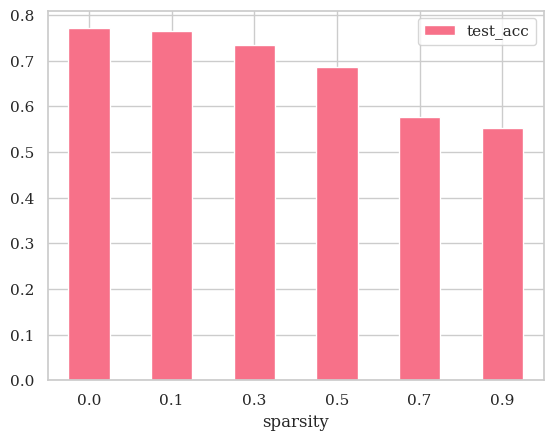

In [12]:
results_data_df.groupby("sparsity").mean().plot.bar(y="test_acc", rot=0)

/tmp/ipykernel_810729/2696730440.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = filtered_df.groupby('sparsity').mean()


<Axes: title={'center': 'Mean Test Accuracy by Sparsity and Model'}, xlabel='sparsity'>

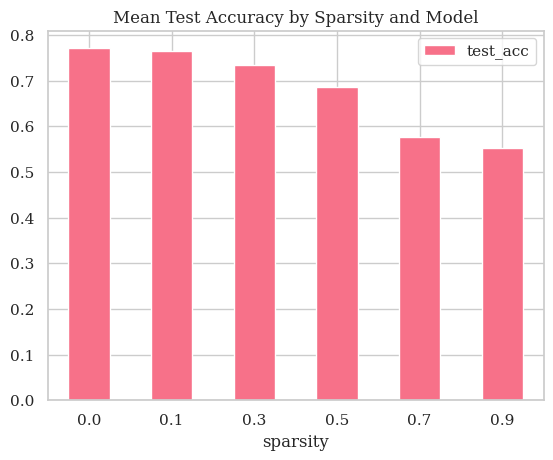

In [20]:
df = pd.DataFrame(results_data_df) 
# Filtering DataFrame for shallow_conv_net, deep_conv_net, and eeg_net 

filtered_df = df[df['model_name'].isin(['shallow_conv_net', 'deep_conv_net', 'eeg_net'])] 
# Grouping by sparsity and calculating mean test accuracy 

grouped_df = filtered_df.groupby('sparsity').mean() 

# Plotting bar graph 
grouped_df.plot.bar(y='test_acc', rot=0, title='Mean Test Accuracy by Sparsity and Model') 

/tmp/ipykernel_810729/1100830552.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = filtered_df.groupby(['sparsity', 'model_name']).mean().reset_index()


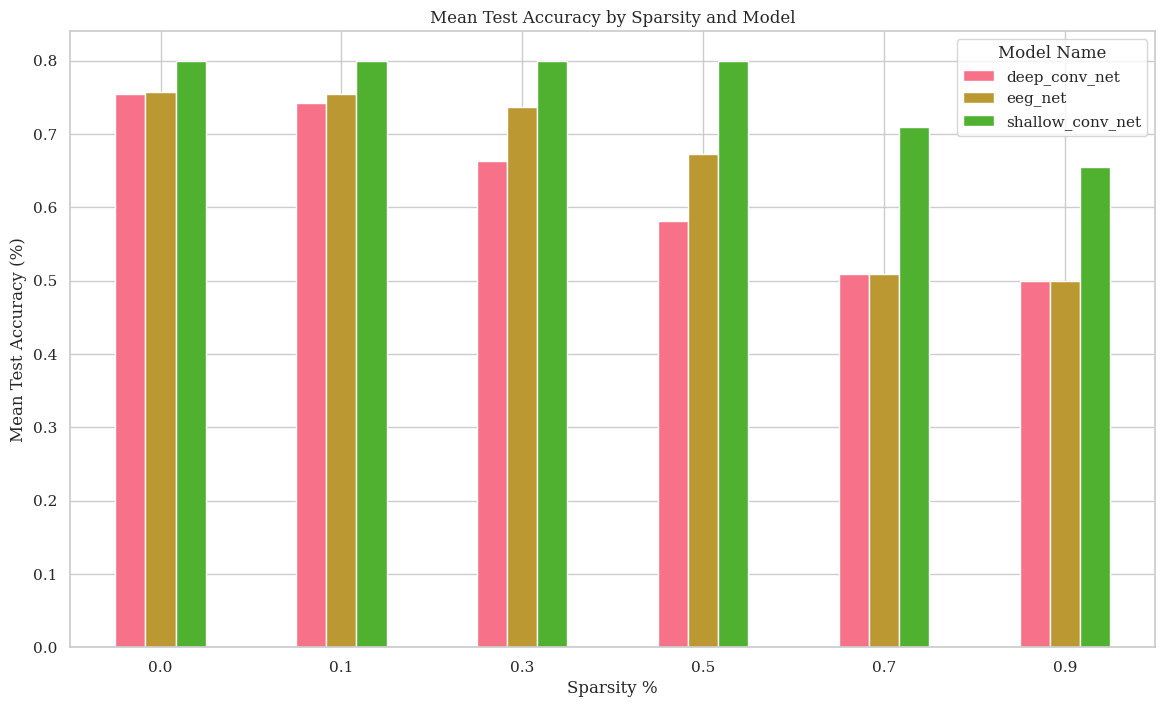

In [21]:
import pandas as pd 
import matplotlib.pyplot as plt 

# Convert results_data_df to a DataFrame 
df = pd.DataFrame(results_data_df) 

# Filtering DataFrame for shallow_conv_net, eeg_net, and deep_conv_net 
filtered_df = df[df['model_name'].isin(['shallow_conv_net', 'eeg_net', 'deep_conv_net'])] 

# Grouping by sparsity and model_name, then calculating mean test accuracy 
grouped_df = filtered_df.groupby(['sparsity', 'model_name']).mean().reset_index() 

# Increase the figure size 
fig, ax = plt.subplots(figsize=(14, 8))  # Adjust the width and height as needed 

# Plotting bar graph 
grouped_df.pivot(index='sparsity', columns='model_name', values='test_acc').plot(kind='bar', rot=0, title='Mean Test Accuracy by Sparsity and Model', ax=ax) 

# Optionally add labels and legend 
plt.xlabel('Sparsity %') 
plt.ylabel('Mean Test Accuracy (%)') 
plt.legend(title='Model Name') 

# Show the plot 
plt.show() 

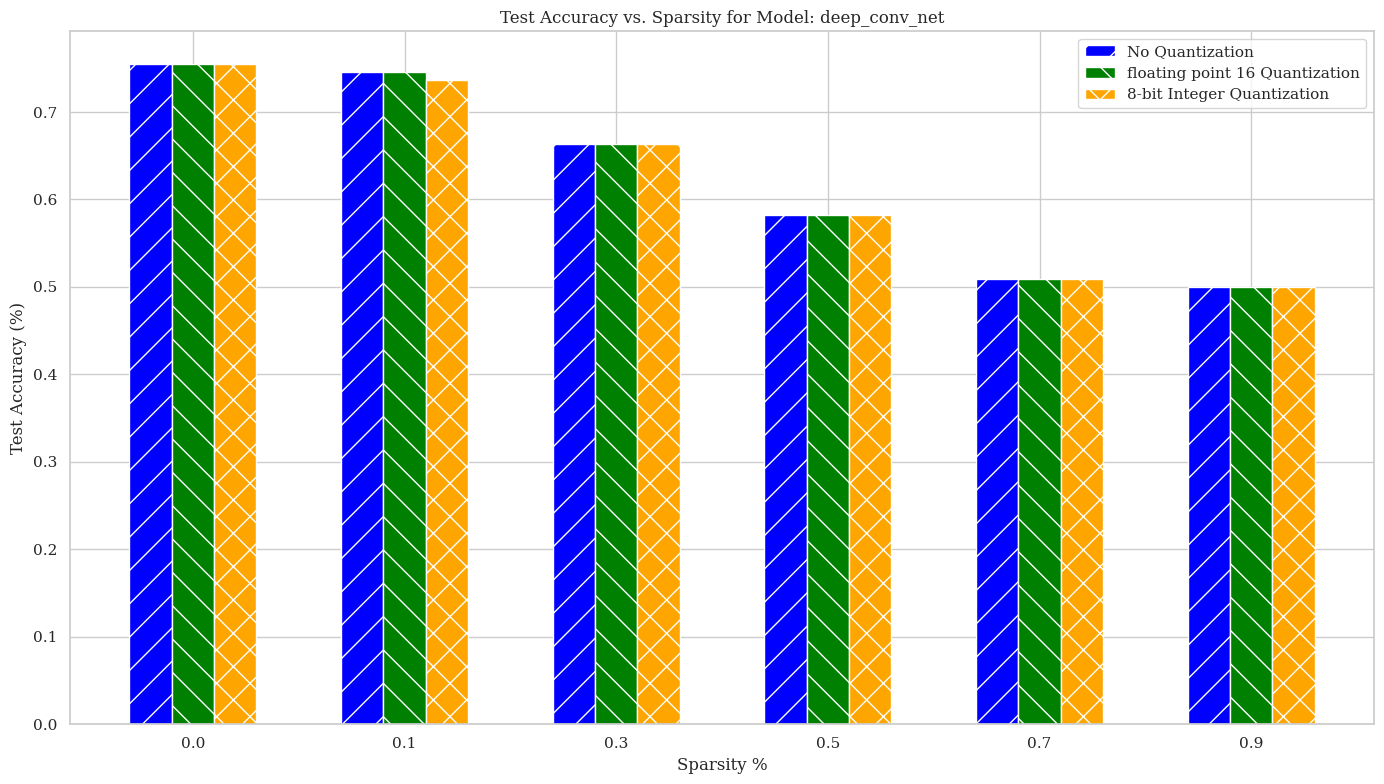

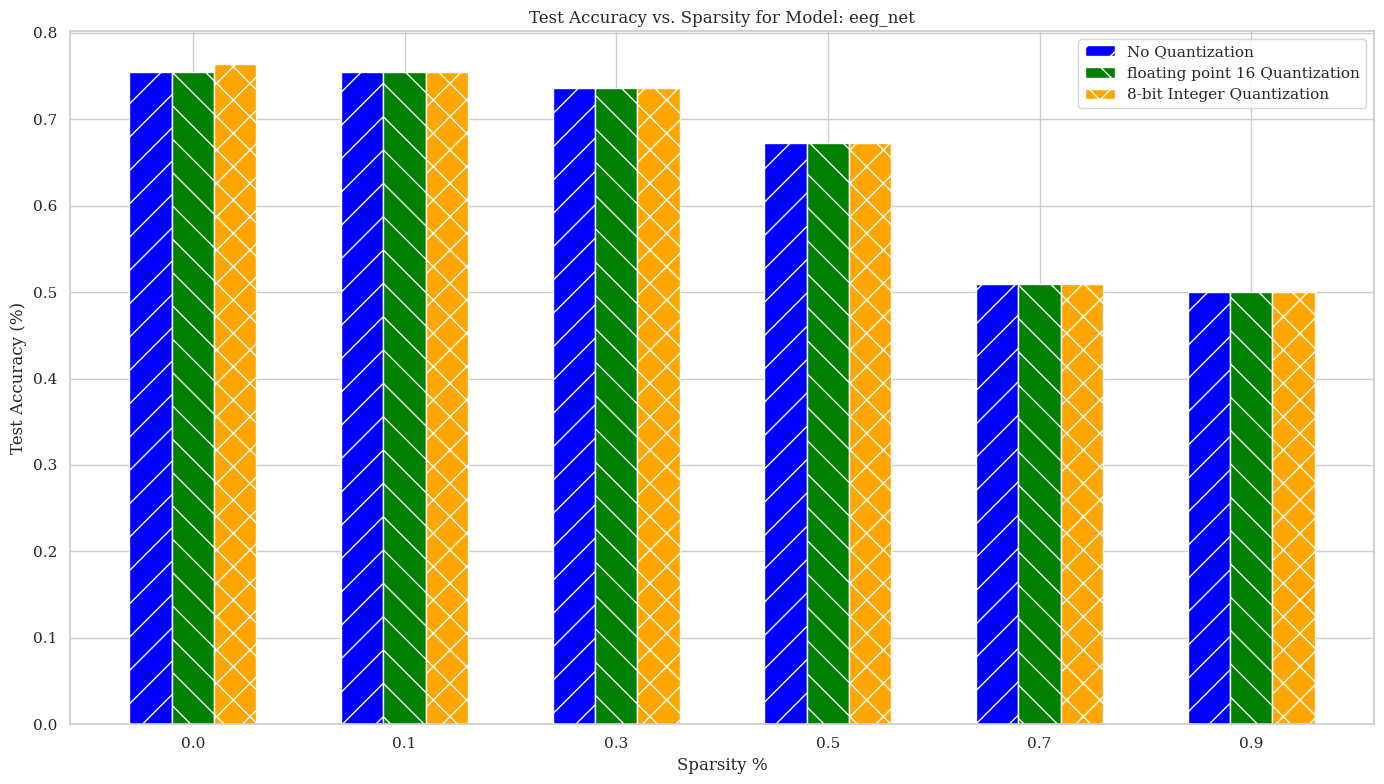

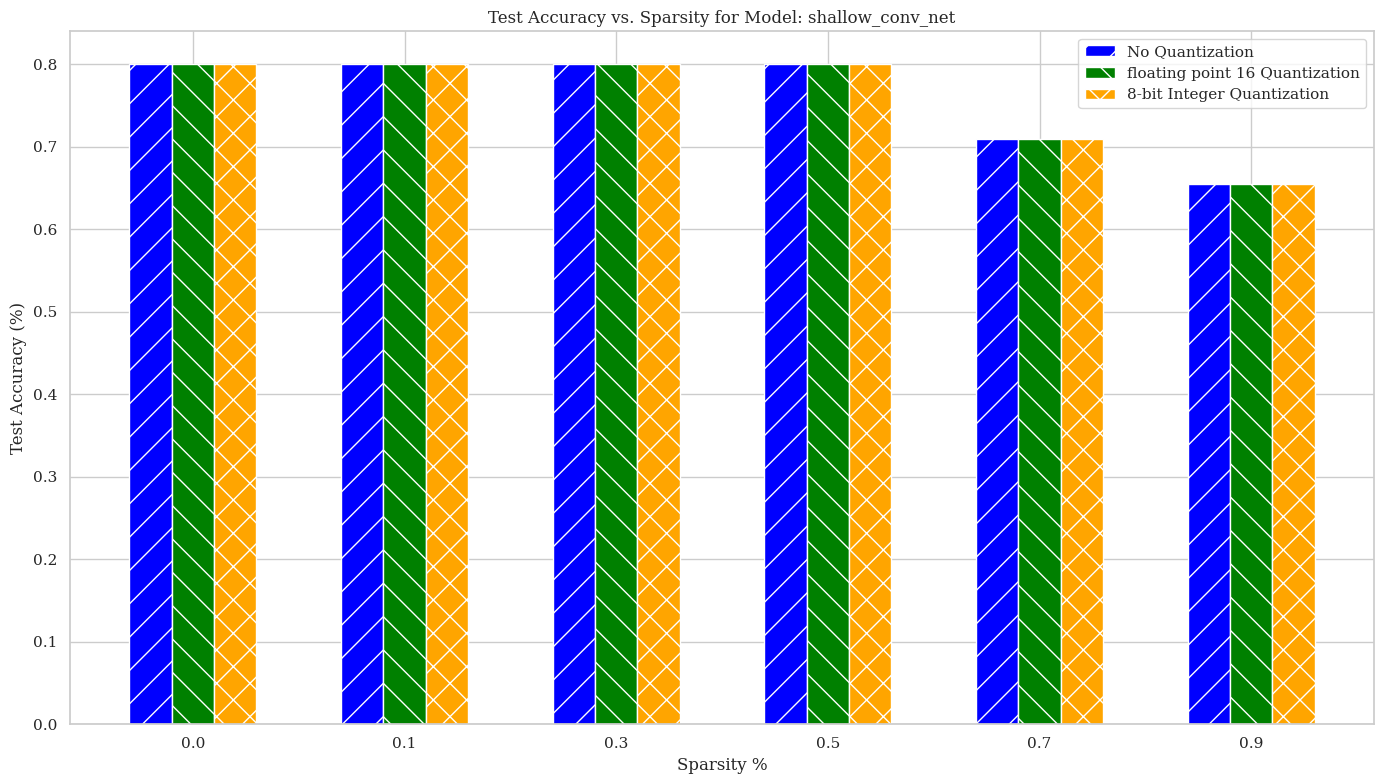

In [22]:
# Replace None with 'None' in the 'quantization' column 
results_data_df['quantization'] = results_data_df['quantization'].apply(lambda x: 'None' if x is None else x) 

# Define the sparsity levels and quantization levels for plotting 
sparsity_levels = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9] 
quantization_levels = ['None', 'float16', 'int8'] 

# Group the data by 'model_name', 'quantization', and 'sparsity', and calculate the mean of 'test_acc' 
grouped_data = results_data_df.groupby(['model_name', 'quantization', 'sparsity']).agg({'test_acc': 'mean'}).reset_index() 

# Loop through each model name and create a separate bar chart 
for model_name in grouped_data['model_name'].unique(): 
    model_data = grouped_data[grouped_data['model_name'] == model_name] 

    # Pivot the DataFrame for easy plotting 
    pivot_data = model_data.pivot(index='sparsity', columns='quantization', values='test_acc') 

    # Plotting 
    plt.figure(figsize=(14, 8)) 

    # Set the width of each bar 
    bar_width = 0.2 

    # Calculate the position of each bar group 
    index = range(len(sparsity_levels)) 

    # Define colors and hatch patterns for each quantization level 
    colors = {'None': 'blue', 'float16': 'green', 'int8': 'orange'} 
    hatches = {'None': '/', 'float16': '\\', 'int8': 'x'} 

    for i, quantization in enumerate(quantization_levels): 
        plt.bar([pos + i * bar_width for pos in index], pivot_data[quantization], width=bar_width, label=quantization, 
                color=colors[quantization], hatch=hatches[quantization]) 

    # Customize the legend labels 
    legend_labels = {'None':'No Quantization', 'float16':'floating point 16 Quantization', 'int8':'8-bit Integer Quantization'} 

    plt.xlabel('Sparsity %') 
    plt.ylabel('Test Accuracy (%)') 
    plt.title(f'Test Accuracy vs. Sparsity for Model: {model_name}') 

    handles, labels = plt.gca().get_legend_handles_labels() 
    plt.legend(handles, [legend_labels[label] for label in labels]) 

    plt.grid(True) 
    plt.xticks([pos + (len(quantization_levels) - 1) * bar_width / 2 for pos in index], sparsity_levels)  # Set x-axis ticks 
    plt.tight_layout()  # Adjust layout to prevent overlap of labels 

    plt.show() 

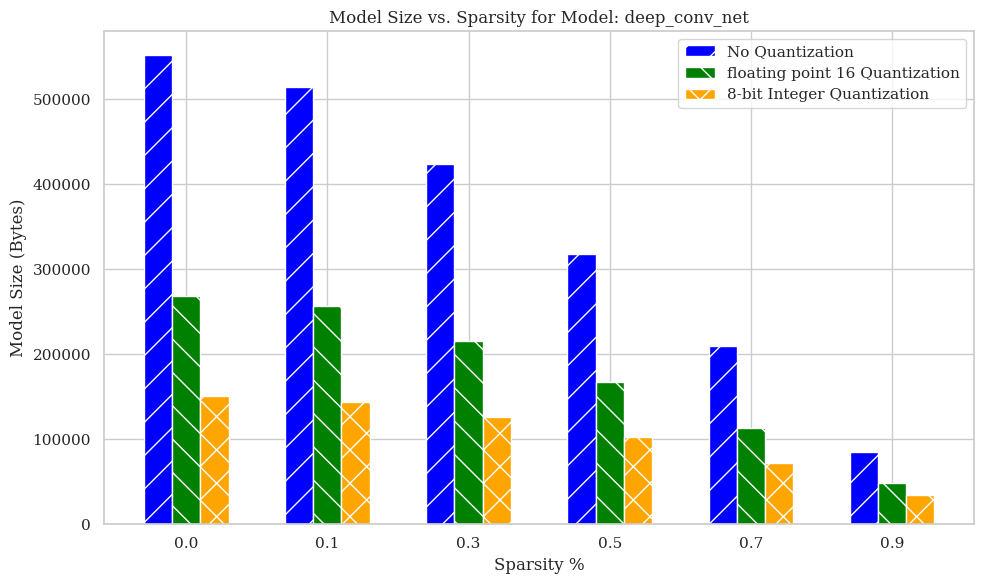

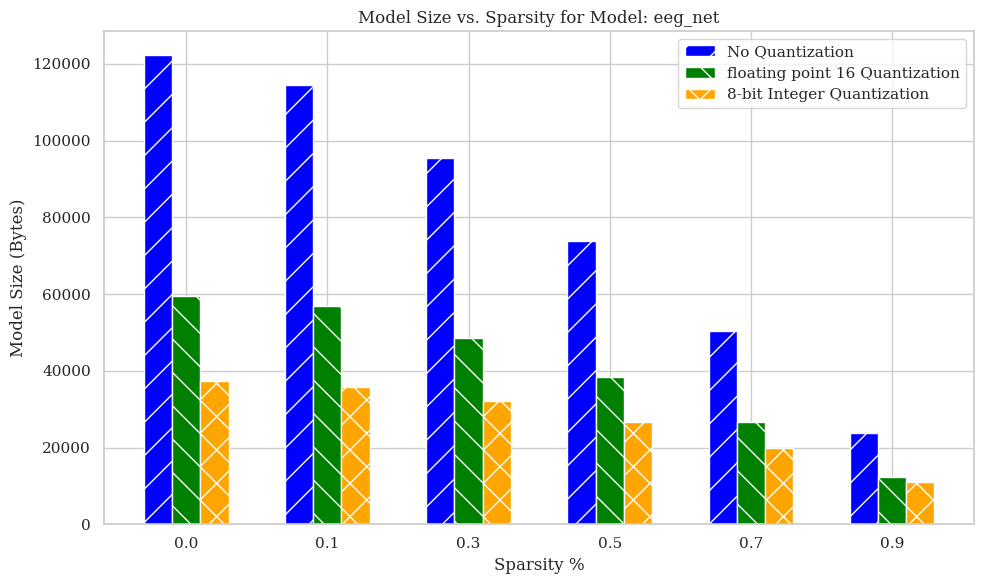

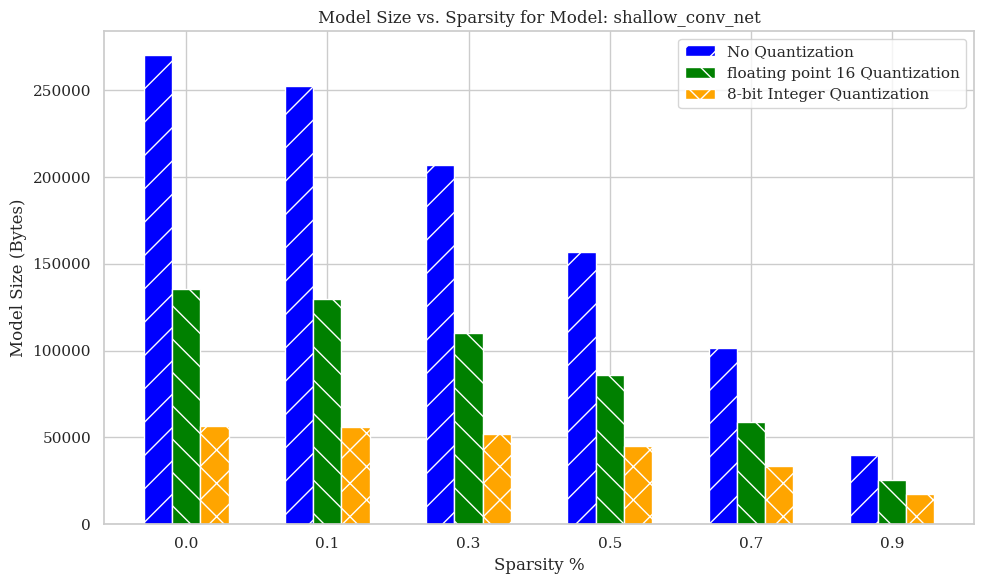

In [23]:
# Replace None with 'None' in the 'quantization' column 
results_data_df['quantization'] = results_data_df['quantization'].apply(lambda x: 'None' if x is None else x) 

# Define the sparsity levels and quantization levels for plotting 
sparsity_levels = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9] 
quantization_levels = ['None', 'float16', 'int8'] 

# Group the data by 'model_name', 'quantization', and 'sparsity', and calculate the mean of 'model_size' 
grouped_data = results_data_df.groupby(['model_name', 'quantization', 'sparsity']).agg({'model_size': 'mean'}).reset_index() 

# Loop through each model name and create a separate bar chart 
for model_name in grouped_data['model_name'].unique(): 
    model_data = grouped_data[grouped_data['model_name'] == model_name] 

    # Pivot the DataFrame for easy plotting 
    pivot_data = model_data.pivot(index='sparsity', columns='quantization', values='model_size') 

    # Plotting 
    plt.figure(figsize=(10, 6)) 

    # Set the width of each bar 
    bar_width = 0.2 

    # Calculate the position of each bar group 
    index = range(len(sparsity_levels))
    # Define colors and hatch patterns for each quantization level 
    colors = {'None': 'blue', 'float16': 'green', 'int8': 'orange'} 
    hatches = {'None': '/', 'float16': '\\', 'int8': 'x'} 

    for i, quantization in enumerate(quantization_levels): 
        plt.bar([pos + i * bar_width for pos in index], pivot_data[quantization], width=bar_width, label=quantization, 
                color=colors[quantization], hatch=hatches[quantization]) 

    # Customize the legend labels 
    legend_labels = {'None':'No Quantization', 'float16':'floating point 16 Quantization', 'int8':'8-bit Integer Quantization'} 

    plt.xlabel('Sparsity %') 
    plt.ylabel('Model Size (Bytes)') 
    plt.title(f'Model Size vs. Sparsity for Model: {model_name}') 

    handles, labels = plt.gca().get_legend_handles_labels() 
    plt.legend(handles, [legend_labels[label] for label in labels]) 
    plt.grid(True) 
    plt.xticks([pos + (len(quantization_levels) - 1) * bar_width / 2 for pos in index], sparsity_levels)  # Set x-axis ticks 
    plt.tight_layout()  # Adjust layout to prevent overlap of labels 
    plt.show() 

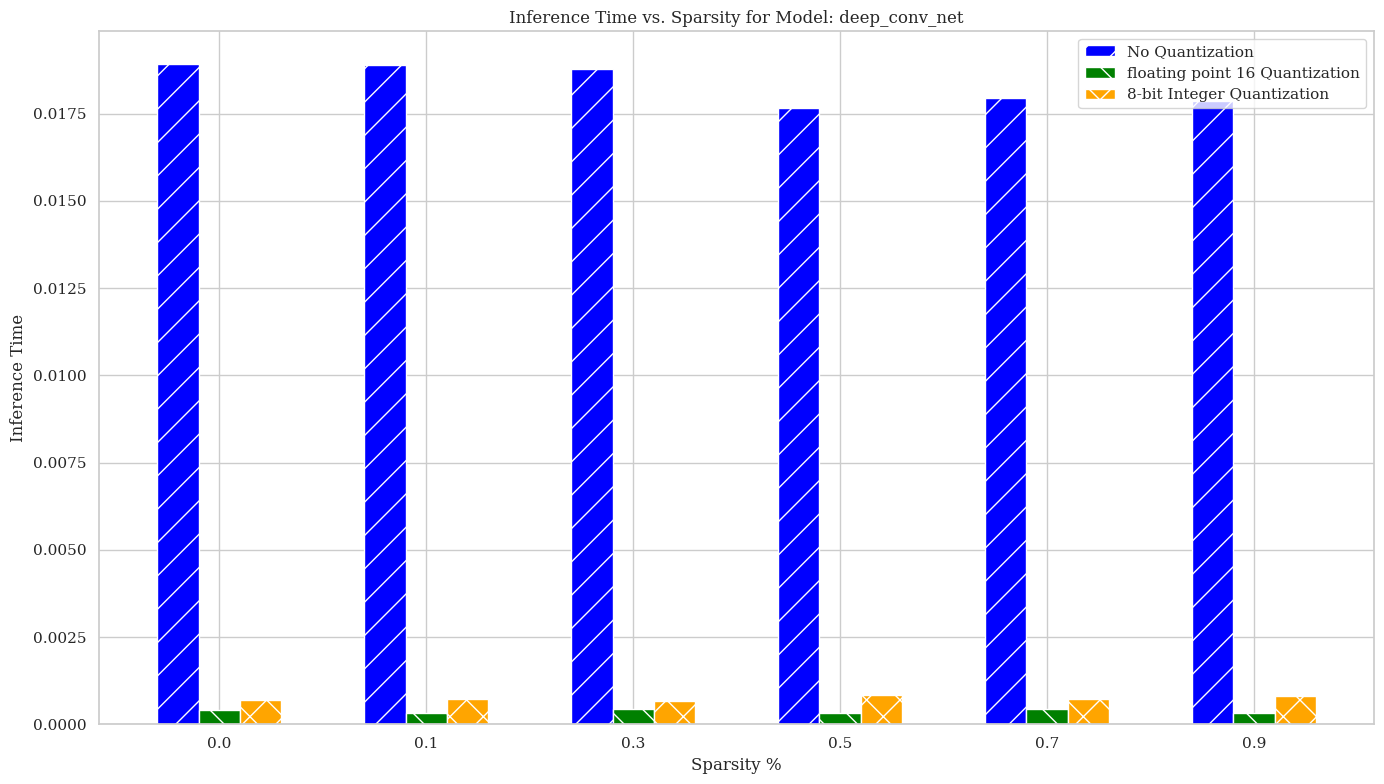

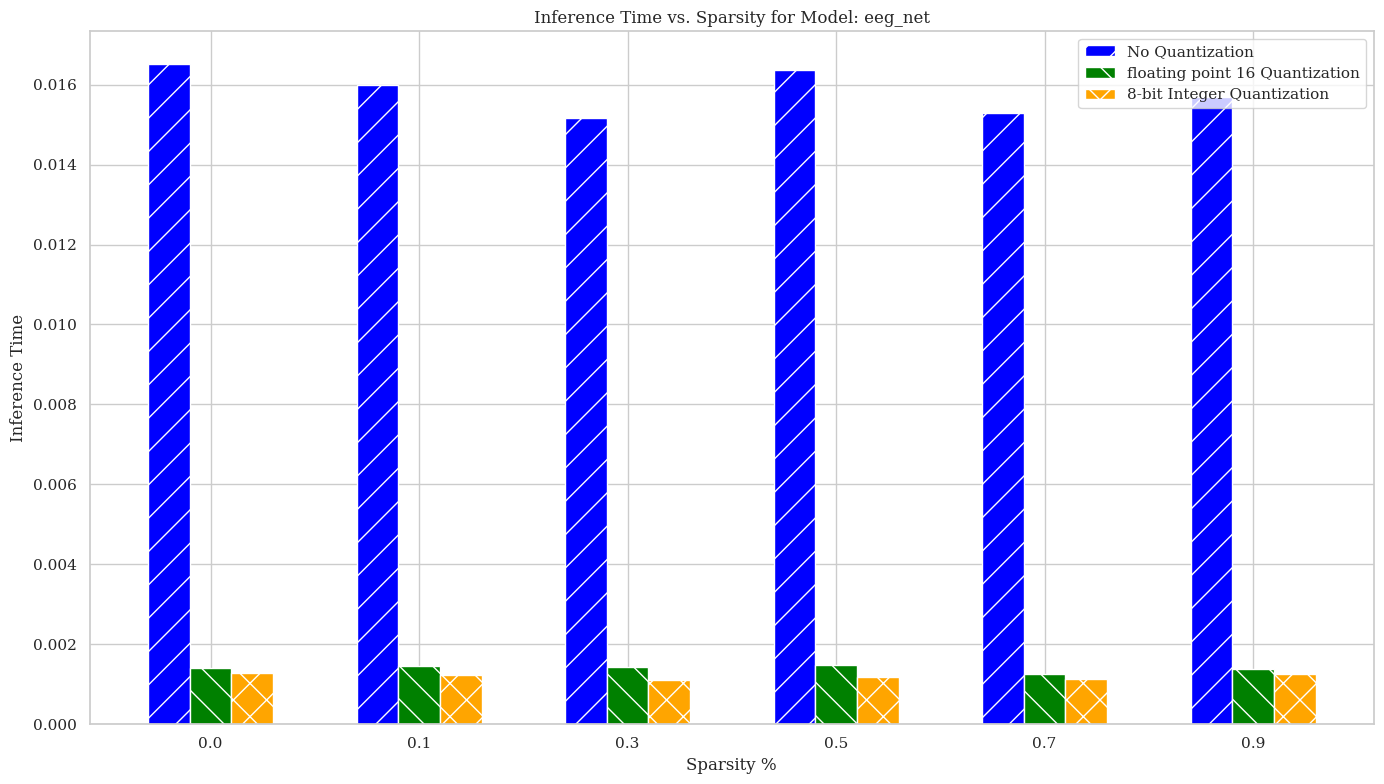

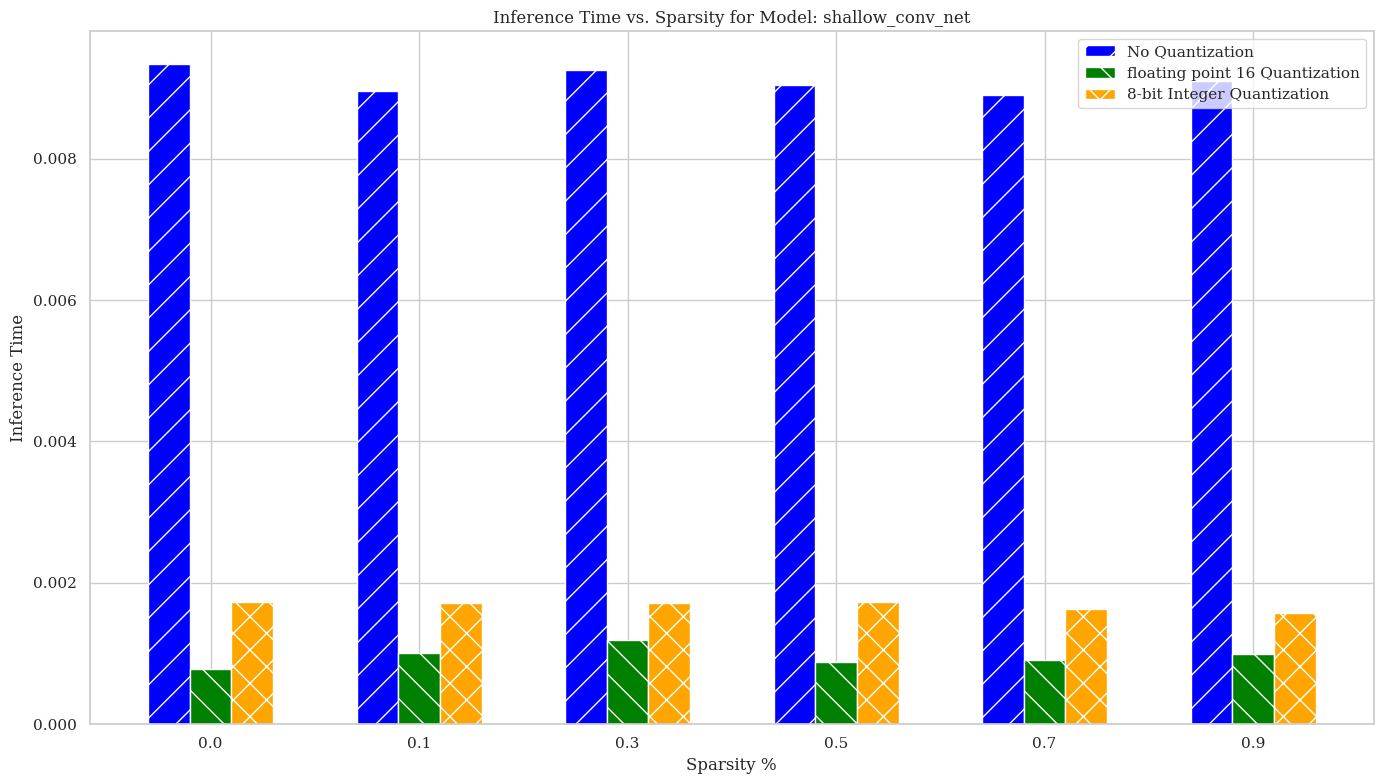

In [24]:
# Replace None with 'None' in the 'quantization' column 
results_data_df['quantization'] = results_data_df['quantization'].apply(lambda x: 'None' if x is None else x) 

# Define the sparsity levels and quantization levels for plotting 
sparsity_levels = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9] 
quantization_levels = ['None', 'float16', 'int8'] 

# Group the data by 'model_name', 'quantization', and 'sparsity', and calculate the mean of 'inf_time' 
grouped_data = results_data_df.groupby(['model_name', 'quantization', 'sparsity']).agg({'inf_time': 'mean'}).reset_index() 
# Loop through each model name and create a separate bar chart 

for model_name in grouped_data['model_name'].unique(): 
    model_data = grouped_data[grouped_data['model_name'] == model_name] 

    # Pivot the DataFrame for easy plotting 
    pivot_data = model_data.pivot(index='sparsity', columns='quantization', values='inf_time') 

    # Plotting 
    plt.figure(figsize=(14, 8)) 

    # Set the width of each bar 
    bar_width = 0.2 

    # Calculate the position of each bar group 
    index = range(len(sparsity_levels)) 

    # Define colors and hatch patterns for each quantization level 
    colors = {'None': 'blue', 'float16': 'green', 'int8': 'orange'} 
    hatches = {'None': '/', 'float16': '\\', 'int8': 'x'} 

    for i, quantization in enumerate(quantization_levels): 
        plt.bar([pos + i * bar_width for pos in index], pivot_data[quantization], width=bar_width, label=quantization, 
                color=colors[quantization], hatch=hatches[quantization]) 

    # Customize the legend labels 
    legend_labels = {'None':'No Quantization', 'float16':'floating point 16 Quantization', 'int8':'8-bit Integer Quantization'} 
    plt.xlabel('Sparsity %') 
    plt.ylabel('Inference Time') 
    plt.title(f'Inference Time vs. Sparsity for Model: {model_name}') 

    handles, labels = plt.gca().get_legend_handles_labels() 

    plt.legend(handles, [legend_labels[label] for label in labels]) 
    plt.grid(True) 
    plt.xticks([pos + (len(quantization_levels) - 1) * bar_width / 2 for pos in index], sparsity_levels)  # Set x-axis ticks 
    plt.tight_layout()  # Adjust layout to prevent overlap of labels 
    plt.show() 

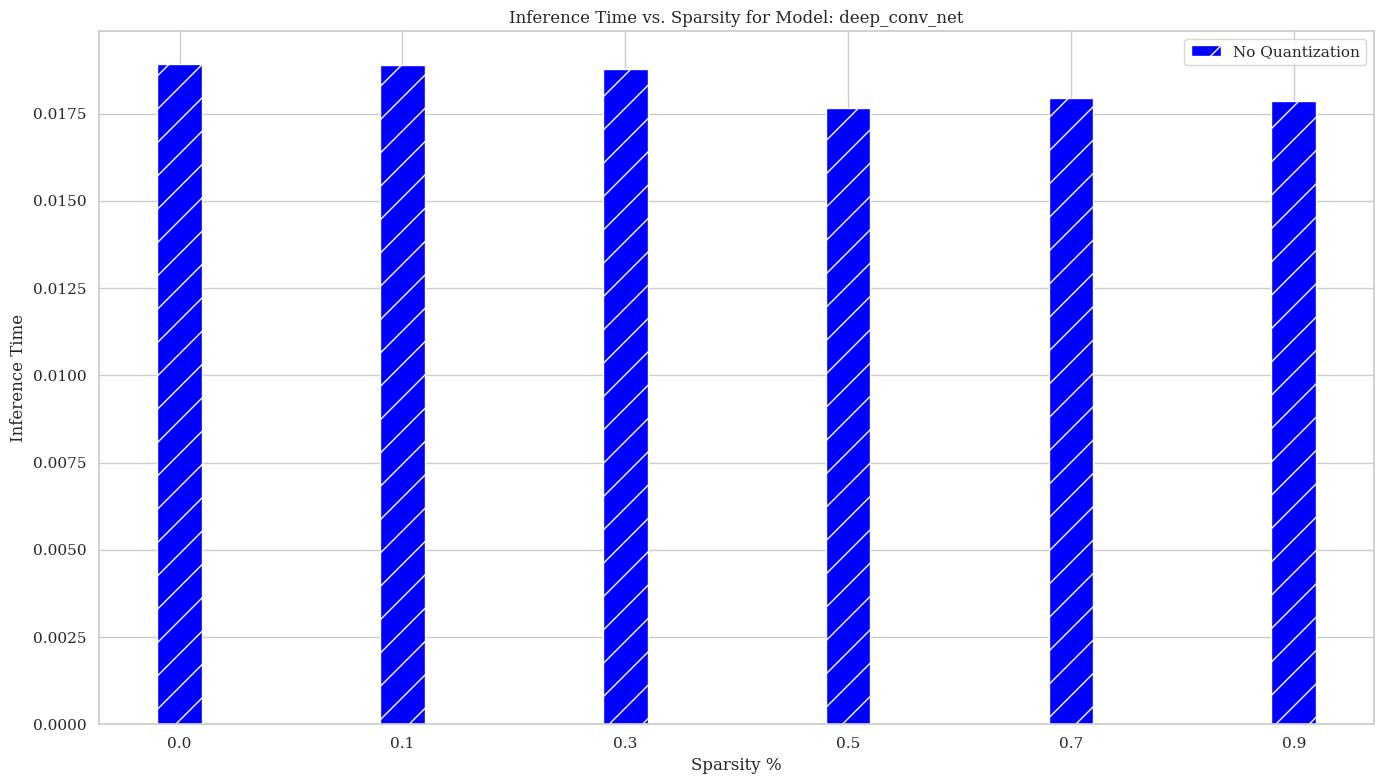

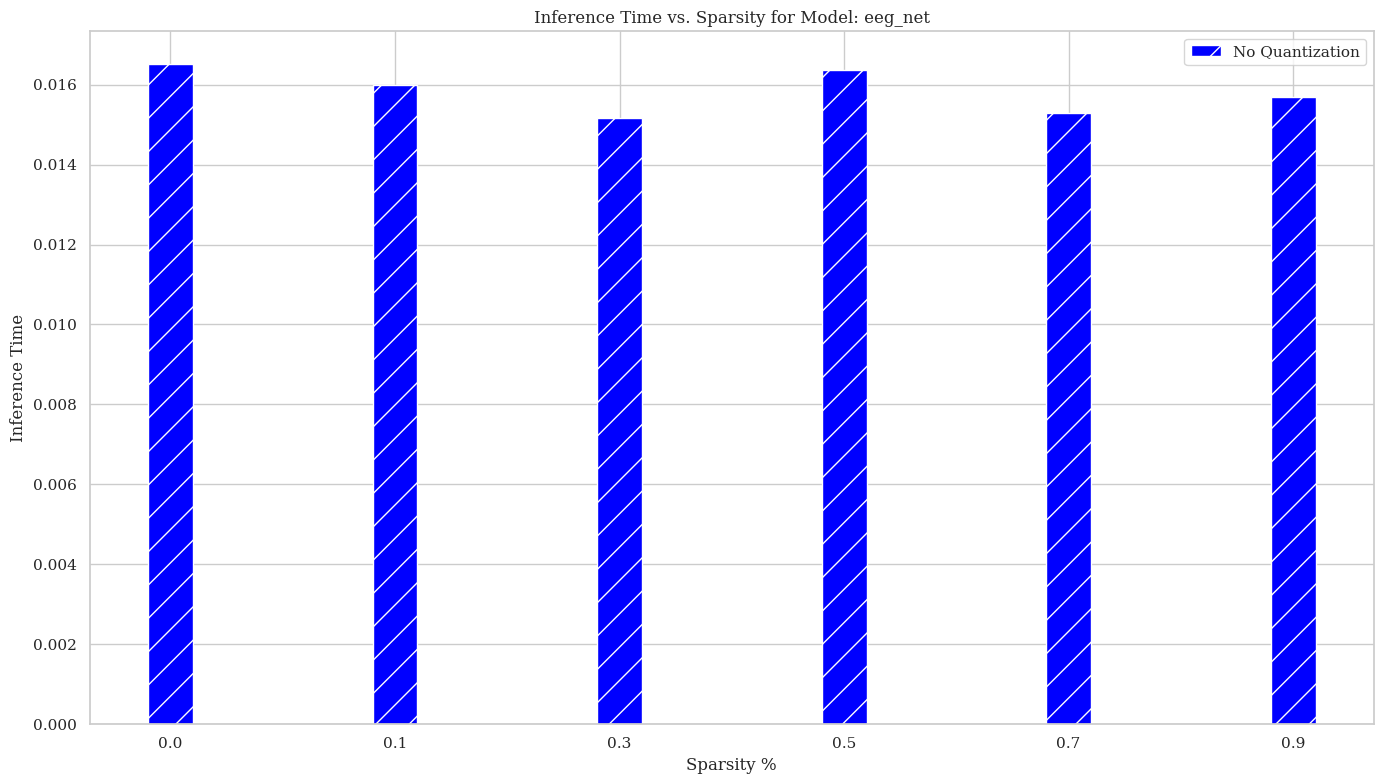

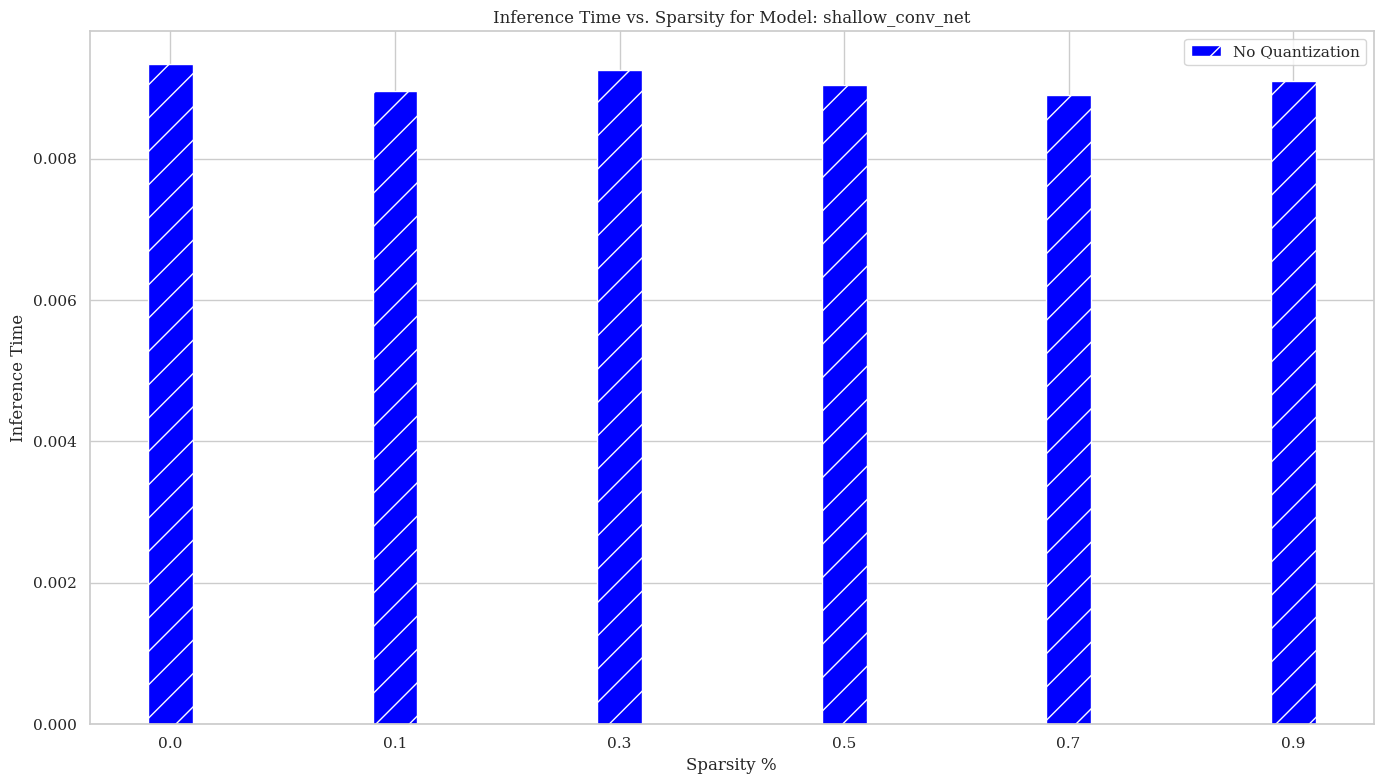

In [25]:
# Replace None with 'None' in the 'quantization' column 
results_data_df['quantization'] = results_data_df['quantization'].apply(lambda x: 'None' if x is None else x) 

# Define the sparsity levels and quantization levels for plotting 
sparsity_levels = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9] 
quantization_levels = ['None'] 

# Group the data by 'model_name', 'quantization', and 'sparsity', and calculate the mean of 'inf_time' 
grouped_data = results_data_df.groupby(['model_name', 'quantization', 'sparsity']).agg({'inf_time': 'mean'}).reset_index() 

# Loop through each model name and create a separate bar chart 
for model_name in grouped_data['model_name'].unique(): 
    model_data = grouped_data[grouped_data['model_name'] == model_name] 

    # Pivot the DataFrame for easy plotting 
    pivot_data = model_data.pivot(index='sparsity', columns='quantization', values='inf_time') 

    # Plotting 
    plt.figure(figsize=(14, 8)) 

    # Set the width of each bar 
    bar_width = 0.2 

    # Calculate the position of each bar group 
    index = range(len(sparsity_levels)) 

    # Define colors and hatch patterns for each quantization level 
    colors = {'None': 'blue', 'float16': 'green', 'int8': 'orange'} 
    hatches = {'None': '/', 'float16': '\\', 'int8': 'x'} 

    for i, quantization in enumerate(quantization_levels): 
        plt.bar([pos + i * bar_width for pos in index], pivot_data[quantization], width=bar_width, label=quantization, 
                color=colors[quantization], hatch=hatches[quantization]) 

    # Customize the legend labels 
    legend_labels = {'None':'No Quantization'} 
    plt.xlabel('Sparsity %') 
    plt.ylabel('Inference Time') 
    plt.title(f'Inference Time vs. Sparsity for Model: {model_name}') 
    handles, labels = plt.gca().get_legend_handles_labels() 
    plt.legend(handles, [legend_labels[label] for label in labels]) 
    plt.grid(True) 
    plt.xticks([pos + (len(quantization_levels) - 1) * bar_width / 2 for pos in index], sparsity_levels)  # Set x-axis ticks 
    plt.tight_layout()  # Adjust layout to prevent overlap of labels 
    plt.show()

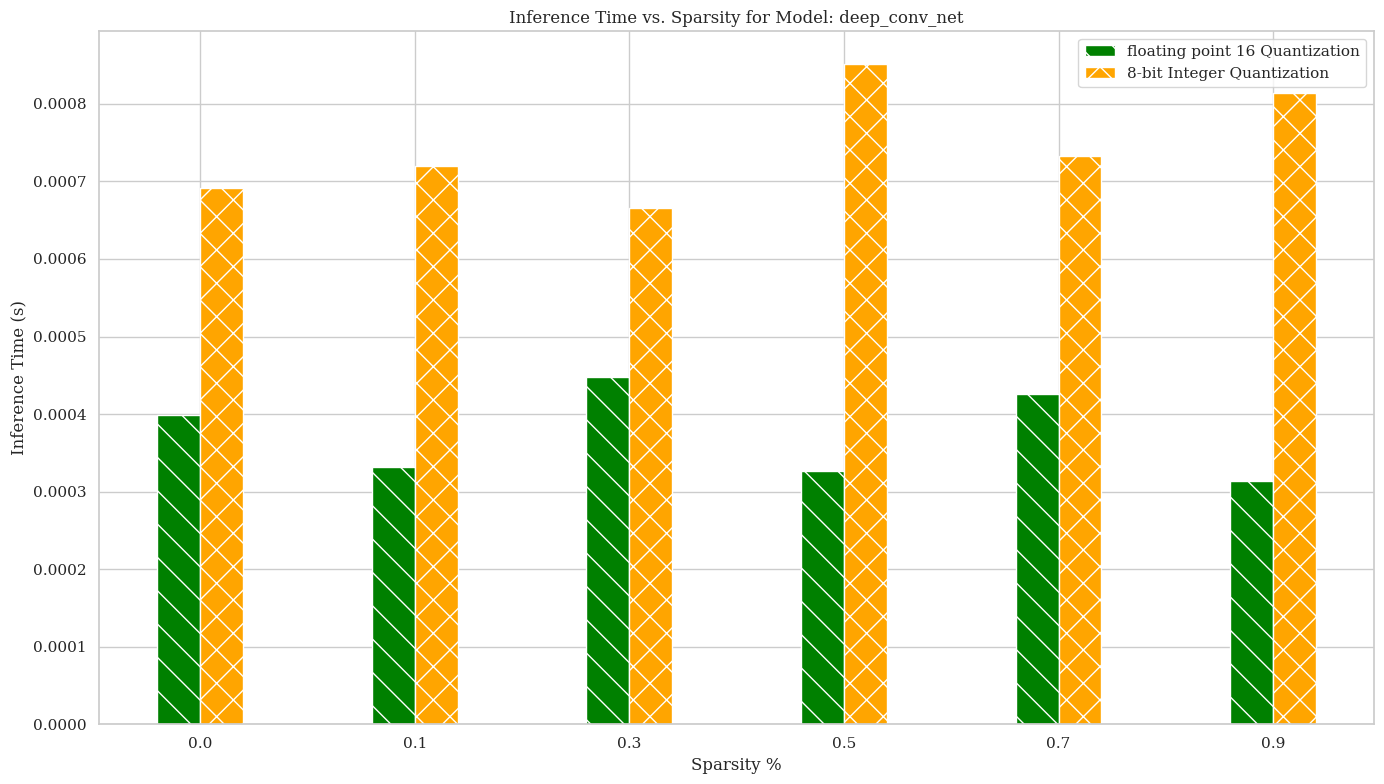

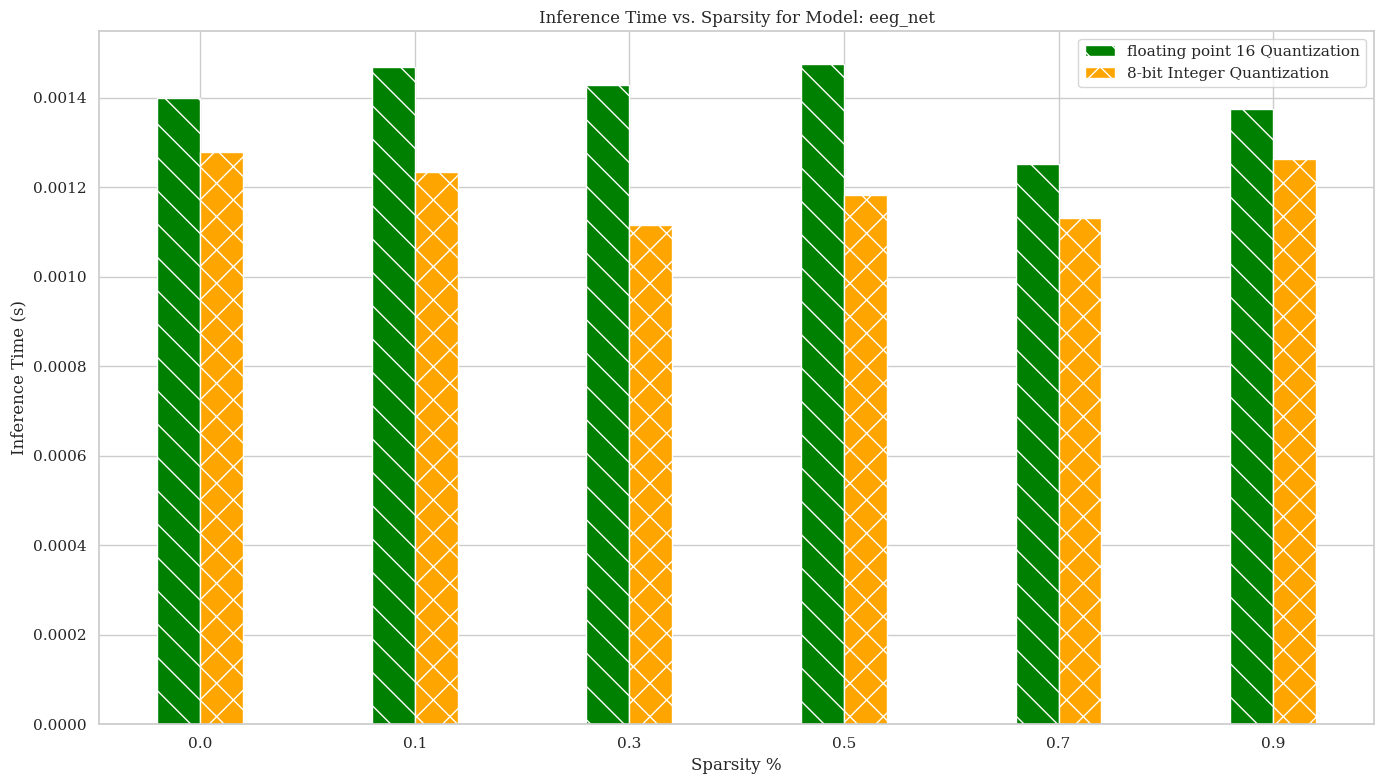

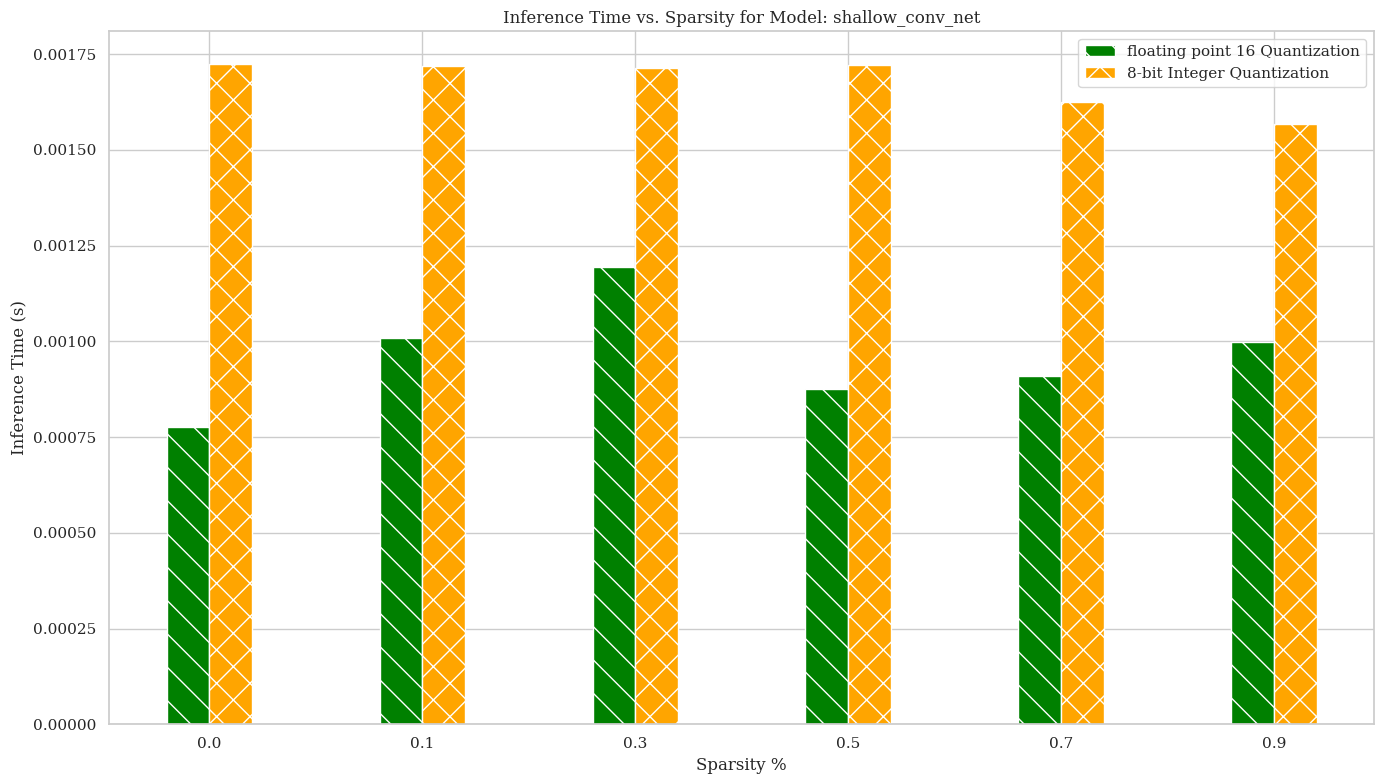

In [27]:
# Replace None with 'None' in the 'quantization' column 
results_data_df['quantization'] = results_data_df['quantization'].apply(lambda x: 'None' if x is None else x) 

# Define the sparsity levels and quantization levels for plotting 
sparsity_levels = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9] 
quantization_levels = ['float16', 'int8'] 

# Group the data by 'model_name', 'quantization', and 'sparsity', and calculate the mean of 'inf_time' 
grouped_data = results_data_df.groupby(['model_name', 'quantization', 'sparsity']).agg({'inf_time': 'mean'}).reset_index() 

# Loop through each model name and create a separate bar chart 
for model_name in grouped_data['model_name'].unique(): 
    model_data = grouped_data[grouped_data['model_name'] == model_name] 

    # Pivot the DataFrame for easy plotting 
    pivot_data = model_data.pivot(index='sparsity', columns='quantization', values='inf_time') 

    # Plotting 
    plt.figure(figsize=(14, 8)) 

    # Set the width of each bar 
    bar_width = 0.2 

    # Calculate the position of each bar group 
    index = range(len(sparsity_levels)) 

    # Define colors and hatch patterns for each quantization level 
    colors = {'None': 'blue', 'float16': 'green', 'int8': 'orange'} 
    hatches = {'None': '/', 'float16': '\\', 'int8': 'x'} 

    for i, quantization in enumerate(quantization_levels): 
        plt.bar([pos + i * bar_width for pos in index], pivot_data[quantization], width=bar_width, label=quantization, 
                color=colors[quantization], hatch=hatches[quantization]) 

    # Customize the legend labels 
    legend_labels = {'float16':'floating point 16 Quantization', 'int8':'8-bit Integer Quantization'} 
    plt.xlabel('Sparsity %') 
    plt.ylabel('Inference Time (s)') 
    plt.title(f'Inference Time vs. Sparsity for Model: {model_name}') 
    handles, labels = plt.gca().get_legend_handles_labels() 
    plt.legend(handles, [legend_labels[label] for label in labels]) 
    plt.grid(True) 
    plt.xticks([pos + (len(quantization_levels) - 1) * bar_width / 2 for pos in index], sparsity_levels)  # Set x-axis ticks 
    plt.tight_layout()  # Adjust layout to prevent overlap of labels 
    plt.show() 

In [ ]:
# Pruning [0, 0.1, 0.5, 0.9]
# 1. Load the best model
# 2. Loop through its layers
# 3. At each layer, set a random % of weights to zero (% sparsity)
# 4. Test